# UAM across layers on MNIST


### 1. Load required modules

In [1]:
import numbers
from torch.nn.parameter import Parameter
import torch.nn.init
import torch.nn.utils.weight_norm as weightNorm

import matplotlib as mpl
mpl.use('TkAgg')  # or whatever other backend that you want
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from numpy import linalg as LA
from torchvision.utils import save_image

from torch.optim import lr_scheduler
import pyro
import argparse
import time, os, copy
import numpy as np
import random
from IPython import display

import seaborn as sns
import seaborn as sns

import pandas as pd
import sklearn.metrics as sm

from scipy.stats import norm

from utils import *
from nn_model import *

torch.manual_seed(1)  


In [2]:
%matplotlib inline


### 2. Set hyperparameters for training

In [3]:

# Hyper Parameters

EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 128
TIME_STEP = 5        # rnn time step 
INPUT_SIZE = 784         # rnn input size
WINDOW_WIDTH = 5
WINDOW_SQUARE = WINDOW_WIDTH**2
IS_VISUALIZATION = True 

dtype = torch.FloatTensor
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor


### 3. Load MNIST data

In [4]:
train_data, test_data, IMAGE_WIDTH, IMAGE_HEIGHT = prepare_data_mnist()

num_train = len(train_data)
indices = list(range(num_train))

split = 5000
train_size = 60000 - split
valid_size = split
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=train_sampler, shuffle=False)
valid_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=split, sampler=valid_sampler, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False)

num_classes = 10
classe_labels = range(num_classes)


In [5]:
sample_probs = torch.rand(num_classes)

idx_to_del = [i for i, label in enumerate(train_loader.dataset.train_labels) 
              if random.random() > sample_probs[label]]
imbalanced_train_dataset = copy.deepcopy(train_data)


imbalanced_train_dataset.targets = np.delete(train_loader.dataset.train_labels.numpy(), np.array(idx_to_del), axis=0)
imbalanced_train_dataset.data = np.delete(train_loader.dataset.train_data, idx_to_del, axis=0)
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=BATCH_SIZE, shuffle=True)


/anaconda3/envs/mlenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/anaconda3/envs/mlenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Original dataset: 60000 training samples & 10000 testing samples

Distribution of classes in original dataset:


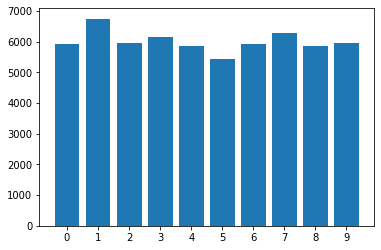

Sampling probability for each class:


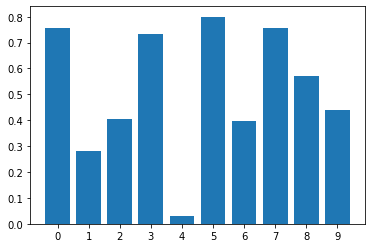

Imbalanced dataset: 30780 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


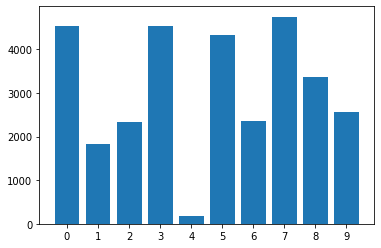

In [6]:

print('Original dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in original dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

print('Sampling probability for each class:')
fig, ax = plt.subplots()
ax.bar(classe_labels, sample_probs)
ax.set_xticks(classe_labels)
plt.show()
 
print('Imbalanced dataset: %d training samples & %d testing samples\n' % (
    len(imbalanced_train_loader.dataset), len(test_loader.dataset)))

print('Distribution of classes in imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()


### 4. Test different NN variants with or without MDL normalization

NN_UAM(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)
epoch  0 :  0 / 60000  (0 %)  | train loss:2.3052 | val loss:2.3026 | val acc:0.0838 | Time:2.1907
epoch  0 :  128 / 60000  (0 %)  | train loss:2.3104 | val loss:2.2906 | val acc:0.1294 | Time:3.3008
epoch  0 :  256 / 60000  (0 %)  | train loss:2.2828 | val loss:2.2737 | val acc:0.1980 | Time:4.3896
epoch  0 :  384 / 60000  (1 %)  | train loss:2.2628 | val loss:2.2518 | val acc:0.2964 | Time:5.4554
epoch  0 :  512 / 60000  (1 %)  | train loss:2.2449 | val loss:2.2256 | val acc:0.3918 | Time:6.5074
epoch  0 :  640 / 60000  (1 %)  | train loss:2.2216 | val loss:2.1959 | val acc:0.4560 | Time:7.6263
epoch  0 :  768 / 60000  (1 %)  | train loss:2.1934 | val loss:2.1634 | val acc:0.4904 | Time:8.6917
epoch  0 :  896 / 60000  (1 %)  | train loss:2.1663 | val loss:2.1287 | val acc:0.5160 | Time:9.

epoch  0 :  9984 / 60000  (17 %)  | train loss:0.2317 | val loss:0.3613 | val acc:0.8962 | Time:94.1490
epoch  0 :  10112 / 60000  (17 %)  | train loss:0.3058 | val loss:0.3570 | val acc:0.8990 | Time:95.2684
epoch  0 :  10240 / 60000  (17 %)  | train loss:0.5736 | val loss:0.3501 | val acc:0.8990 | Time:96.5050
epoch  0 :  10368 / 60000  (17 %)  | train loss:0.4685 | val loss:0.3467 | val acc:0.9006 | Time:98.0247
epoch  0 :  10496 / 60000  (17 %)  | train loss:0.3421 | val loss:0.3478 | val acc:0.8992 | Time:99.1191
epoch  0 :  10624 / 60000  (18 %)  | train loss:0.3406 | val loss:0.3492 | val acc:0.8972 | Time:100.2148
epoch  0 :  10752 / 60000  (18 %)  | train loss:0.3653 | val loss:0.3490 | val acc:0.8966 | Time:101.3414
epoch  0 :  10880 / 60000  (18 %)  | train loss:0.4827 | val loss:0.3542 | val acc:0.8938 | Time:102.5030
epoch  0 :  11008 / 60000  (18 %)  | train loss:0.4905 | val loss:0.3512 | val acc:0.8960 | Time:103.8511
epoch  0 :  11136 / 60000  (19 %)  | train loss:0.18

epoch  0 :  19968 / 60000  (33 %)  | train loss:0.2591 | val loss:0.2870 | val acc:0.9146 | Time:190.2663
epoch  0 :  20096 / 60000  (33 %)  | train loss:0.2389 | val loss:0.2886 | val acc:0.9156 | Time:191.9102
epoch  0 :  20224 / 60000  (34 %)  | train loss:0.2553 | val loss:0.2921 | val acc:0.9160 | Time:193.5418
epoch  0 :  20352 / 60000  (34 %)  | train loss:0.4280 | val loss:0.2914 | val acc:0.9170 | Time:195.0510
epoch  0 :  20480 / 60000  (34 %)  | train loss:0.2404 | val loss:0.2832 | val acc:0.9208 | Time:196.7237
epoch  0 :  20608 / 60000  (34 %)  | train loss:0.3049 | val loss:0.2725 | val acc:0.9274 | Time:198.2304
epoch  0 :  20736 / 60000  (35 %)  | train loss:0.2973 | val loss:0.2645 | val acc:0.9296 | Time:199.9758
epoch  0 :  20864 / 60000  (35 %)  | train loss:0.2683 | val loss:0.2602 | val acc:0.9284 | Time:201.4275
epoch  0 :  20992 / 60000  (35 %)  | train loss:0.2347 | val loss:0.2606 | val acc:0.9282 | Time:202.9165
epoch  0 :  21120 / 60000  (35 %)  | train los

epoch  0 :  29952 / 60000  (50 %)  | train loss:0.3306 | val loss:0.2541 | val acc:0.9264 | Time:287.7291
epoch  0 :  30080 / 60000  (50 %)  | train loss:0.2650 | val loss:0.2471 | val acc:0.9288 | Time:288.8063
epoch  0 :  30208 / 60000  (50 %)  | train loss:0.1515 | val loss:0.2416 | val acc:0.9296 | Time:289.9543
epoch  0 :  30336 / 60000  (51 %)  | train loss:0.2298 | val loss:0.2353 | val acc:0.9304 | Time:291.0591
epoch  0 :  30464 / 60000  (51 %)  | train loss:0.2614 | val loss:0.2282 | val acc:0.9340 | Time:292.1644
epoch  0 :  30592 / 60000  (51 %)  | train loss:0.3085 | val loss:0.2246 | val acc:0.9348 | Time:293.3804
epoch  0 :  30720 / 60000  (51 %)  | train loss:0.1500 | val loss:0.2231 | val acc:0.9342 | Time:294.4812
epoch  0 :  30848 / 60000  (51 %)  | train loss:0.2702 | val loss:0.2234 | val acc:0.9346 | Time:295.5792
epoch  0 :  30976 / 60000  (52 %)  | train loss:0.2137 | val loss:0.2254 | val acc:0.9340 | Time:296.6749
epoch  0 :  31104 / 60000  (52 %)  | train los

epoch  0 :  39936 / 60000  (67 %)  | train loss:0.1810 | val loss:0.2011 | val acc:0.9408 | Time:376.5635
epoch  0 :  40064 / 60000  (67 %)  | train loss:0.1980 | val loss:0.2027 | val acc:0.9402 | Time:378.0123
epoch  0 :  40192 / 60000  (67 %)  | train loss:0.2225 | val loss:0.2048 | val acc:0.9388 | Time:379.1068
epoch  0 :  40320 / 60000  (67 %)  | train loss:0.2018 | val loss:0.2055 | val acc:0.9388 | Time:380.3341
epoch  0 :  40448 / 60000  (67 %)  | train loss:0.3448 | val loss:0.2063 | val acc:0.9392 | Time:381.5511
epoch  0 :  40576 / 60000  (68 %)  | train loss:0.1636 | val loss:0.2072 | val acc:0.9390 | Time:382.7147
epoch  0 :  40704 / 60000  (68 %)  | train loss:0.1753 | val loss:0.2064 | val acc:0.9380 | Time:383.8080
epoch  0 :  40832 / 60000  (68 %)  | train loss:0.2064 | val loss:0.2045 | val acc:0.9376 | Time:384.8975
epoch  0 :  40960 / 60000  (68 %)  | train loss:0.2417 | val loss:0.2004 | val acc:0.9394 | Time:385.9808
epoch  0 :  41088 / 60000  (68 %)  | train los

epoch  0 :  49920 / 60000  (83 %)  | train loss:0.1533 | val loss:0.1755 | val acc:0.9542 | Time:464.8641
epoch  0 :  50048 / 60000  (83 %)  | train loss:0.1213 | val loss:0.1779 | val acc:0.9520 | Time:465.9781
epoch  0 :  50176 / 60000  (84 %)  | train loss:0.1637 | val loss:0.1783 | val acc:0.9524 | Time:467.2404
epoch  0 :  50304 / 60000  (84 %)  | train loss:0.1460 | val loss:0.1785 | val acc:0.9522 | Time:468.8009
epoch  0 :  50432 / 60000  (84 %)  | train loss:0.2596 | val loss:0.1766 | val acc:0.9542 | Time:469.9342
epoch  0 :  50560 / 60000  (84 %)  | train loss:0.1765 | val loss:0.1760 | val acc:0.9550 | Time:470.9884
epoch  0 :  50688 / 60000  (84 %)  | train loss:0.1354 | val loss:0.1762 | val acc:0.9538 | Time:472.1610
epoch  0 :  50816 / 60000  (85 %)  | train loss:0.1901 | val loss:0.1752 | val acc:0.9538 | Time:473.2478
epoch  0 :  50944 / 60000  (85 %)  | train loss:0.2035 | val loss:0.1754 | val acc:0.9524 | Time:474.3486
epoch  0 :  51072 / 60000  (85 %)  | train los

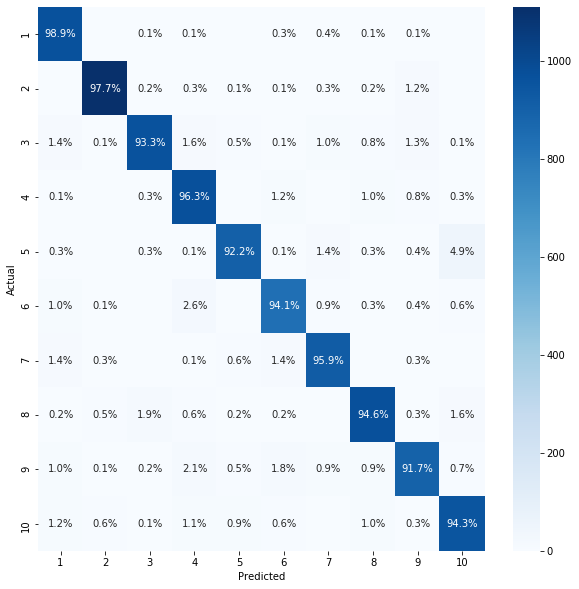

epoch  1 :  0 / 60000  (0 %)  | train loss:0.1349 | val loss:0.1705 | val acc:0.9520 | Time:1.3117
epoch  1 :  128 / 60000  (0 %)  | train loss:0.1413 | val loss:0.1691 | val acc:0.9544 | Time:2.4905
epoch  1 :  256 / 60000  (0 %)  | train loss:0.2844 | val loss:0.1662 | val acc:0.9552 | Time:3.8894
epoch  1 :  384 / 60000  (1 %)  | train loss:0.2351 | val loss:0.1657 | val acc:0.9558 | Time:5.0404
epoch  1 :  512 / 60000  (1 %)  | train loss:0.2304 | val loss:0.1664 | val acc:0.9556 | Time:6.1680
epoch  1 :  640 / 60000  (1 %)  | train loss:0.1623 | val loss:0.1670 | val acc:0.9566 | Time:7.8899
epoch  1 :  768 / 60000  (1 %)  | train loss:0.3178 | val loss:0.1686 | val acc:0.9550 | Time:9.2118
epoch  1 :  896 / 60000  (1 %)  | train loss:0.1452 | val loss:0.1702 | val acc:0.9546 | Time:10.4795
epoch  1 :  1024 / 60000  (2 %)  | train loss:0.3350 | val loss:0.1699 | val acc:0.9544 | Time:11.8738
epoch  1 :  1152 / 60000  (2 %)  | train loss:0.2056 | val loss:0.1685 | val acc:0.9552 | 

epoch  1 :  10240 / 60000  (17 %)  | train loss:0.2249 | val loss:0.1508 | val acc:0.9596 | Time:98.9546
epoch  1 :  10368 / 60000  (17 %)  | train loss:0.1399 | val loss:0.1505 | val acc:0.9596 | Time:100.0385
epoch  1 :  10496 / 60000  (17 %)  | train loss:0.0887 | val loss:0.1510 | val acc:0.9604 | Time:101.2491
epoch  1 :  10624 / 60000  (18 %)  | train loss:0.1575 | val loss:0.1517 | val acc:0.9600 | Time:102.3655
epoch  1 :  10752 / 60000  (18 %)  | train loss:0.1921 | val loss:0.1519 | val acc:0.9602 | Time:103.4784
epoch  1 :  10880 / 60000  (18 %)  | train loss:0.1305 | val loss:0.1520 | val acc:0.9598 | Time:104.5544
epoch  1 :  11008 / 60000  (18 %)  | train loss:0.1100 | val loss:0.1517 | val acc:0.9608 | Time:105.7630
epoch  1 :  11136 / 60000  (19 %)  | train loss:0.1963 | val loss:0.1520 | val acc:0.9596 | Time:106.8567
epoch  1 :  11264 / 60000  (19 %)  | train loss:0.1508 | val loss:0.1515 | val acc:0.9592 | Time:107.9566
epoch  1 :  11392 / 60000  (19 %)  | train loss

epoch  1 :  20224 / 60000  (34 %)  | train loss:0.2243 | val loss:0.1422 | val acc:0.9600 | Time:189.4779
epoch  1 :  20352 / 60000  (34 %)  | train loss:0.2233 | val loss:0.1423 | val acc:0.9606 | Time:190.5609
epoch  1 :  20480 / 60000  (34 %)  | train loss:0.0976 | val loss:0.1417 | val acc:0.9608 | Time:191.7123
epoch  1 :  20608 / 60000  (34 %)  | train loss:0.1038 | val loss:0.1408 | val acc:0.9610 | Time:192.9090
epoch  1 :  20736 / 60000  (35 %)  | train loss:0.1223 | val loss:0.1403 | val acc:0.9606 | Time:194.2691
epoch  1 :  20864 / 60000  (35 %)  | train loss:0.1374 | val loss:0.1389 | val acc:0.9602 | Time:195.6890
epoch  1 :  20992 / 60000  (35 %)  | train loss:0.1756 | val loss:0.1379 | val acc:0.9608 | Time:196.9491
epoch  1 :  21120 / 60000  (35 %)  | train loss:0.1714 | val loss:0.1374 | val acc:0.9610 | Time:198.0746
epoch  1 :  21248 / 60000  (35 %)  | train loss:0.1336 | val loss:0.1373 | val acc:0.9606 | Time:199.2028
epoch  1 :  21376 / 60000  (36 %)  | train los

epoch  1 :  30208 / 60000  (50 %)  | train loss:0.1278 | val loss:0.1258 | val acc:0.9658 | Time:277.9513
epoch  1 :  30336 / 60000  (51 %)  | train loss:0.1135 | val loss:0.1256 | val acc:0.9656 | Time:279.0099
epoch  1 :  30464 / 60000  (51 %)  | train loss:0.1092 | val loss:0.1260 | val acc:0.9656 | Time:280.2113
epoch  1 :  30592 / 60000  (51 %)  | train loss:0.0786 | val loss:0.1271 | val acc:0.9644 | Time:281.3898
epoch  1 :  30720 / 60000  (51 %)  | train loss:0.1317 | val loss:0.1284 | val acc:0.9642 | Time:282.6603
epoch  1 :  30848 / 60000  (51 %)  | train loss:0.0817 | val loss:0.1297 | val acc:0.9638 | Time:283.7733
epoch  1 :  30976 / 60000  (52 %)  | train loss:0.1024 | val loss:0.1299 | val acc:0.9640 | Time:284.8327
epoch  1 :  31104 / 60000  (52 %)  | train loss:0.1224 | val loss:0.1293 | val acc:0.9650 | Time:285.8747
epoch  1 :  31232 / 60000  (52 %)  | train loss:0.1604 | val loss:0.1288 | val acc:0.9652 | Time:286.9279
epoch  1 :  31360 / 60000  (52 %)  | train los

epoch  1 :  40192 / 60000  (67 %)  | train loss:0.1139 | val loss:0.1183 | val acc:0.9666 | Time:368.9149
epoch  1 :  40320 / 60000  (67 %)  | train loss:0.0922 | val loss:0.1185 | val acc:0.9654 | Time:369.9540
epoch  1 :  40448 / 60000  (67 %)  | train loss:0.0783 | val loss:0.1189 | val acc:0.9660 | Time:371.2060
epoch  1 :  40576 / 60000  (68 %)  | train loss:0.1319 | val loss:0.1188 | val acc:0.9654 | Time:372.3137
epoch  1 :  40704 / 60000  (68 %)  | train loss:0.2126 | val loss:0.1188 | val acc:0.9656 | Time:373.4534
epoch  1 :  40832 / 60000  (68 %)  | train loss:0.1283 | val loss:0.1190 | val acc:0.9656 | Time:374.5883
epoch  1 :  40960 / 60000  (68 %)  | train loss:0.0892 | val loss:0.1198 | val acc:0.9658 | Time:375.7227
epoch  1 :  41088 / 60000  (68 %)  | train loss:0.1816 | val loss:0.1197 | val acc:0.9662 | Time:376.9461
epoch  1 :  41216 / 60000  (69 %)  | train loss:0.0645 | val loss:0.1199 | val acc:0.9664 | Time:378.0771
epoch  1 :  41344 / 60000  (69 %)  | train los

epoch  1 :  50176 / 60000  (84 %)  | train loss:0.1419 | val loss:0.1121 | val acc:0.9674 | Time:465.0406
epoch  1 :  50304 / 60000  (84 %)  | train loss:0.1441 | val loss:0.1122 | val acc:0.9676 | Time:466.1599
epoch  1 :  50432 / 60000  (84 %)  | train loss:0.1086 | val loss:0.1132 | val acc:0.9674 | Time:467.2660
epoch  1 :  50560 / 60000  (84 %)  | train loss:0.2138 | val loss:0.1141 | val acc:0.9666 | Time:468.6451
epoch  1 :  50688 / 60000  (84 %)  | train loss:0.0541 | val loss:0.1154 | val acc:0.9664 | Time:469.7407
epoch  1 :  50816 / 60000  (85 %)  | train loss:0.2308 | val loss:0.1166 | val acc:0.9662 | Time:470.8069
epoch  1 :  50944 / 60000  (85 %)  | train loss:0.1625 | val loss:0.1163 | val acc:0.9672 | Time:471.8938
epoch  1 :  51072 / 60000  (85 %)  | train loss:0.0499 | val loss:0.1158 | val acc:0.9666 | Time:472.9744
epoch  1 :  51200 / 60000  (85 %)  | train loss:0.2113 | val loss:0.1143 | val acc:0.9672 | Time:474.0969
epoch  1 :  51328 / 60000  (86 %)  | train los

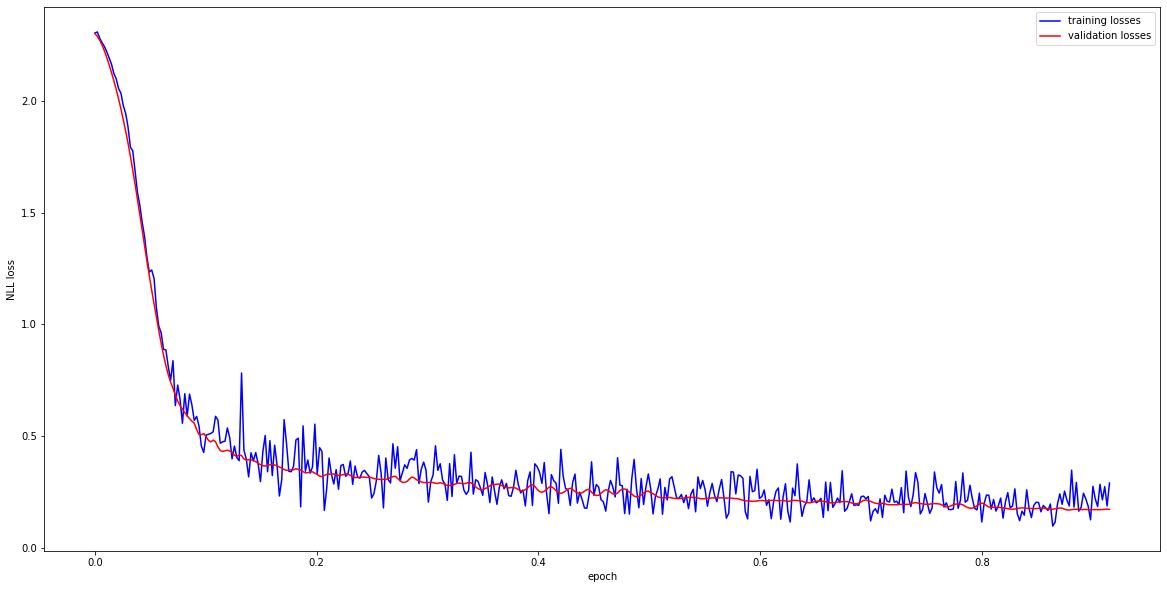

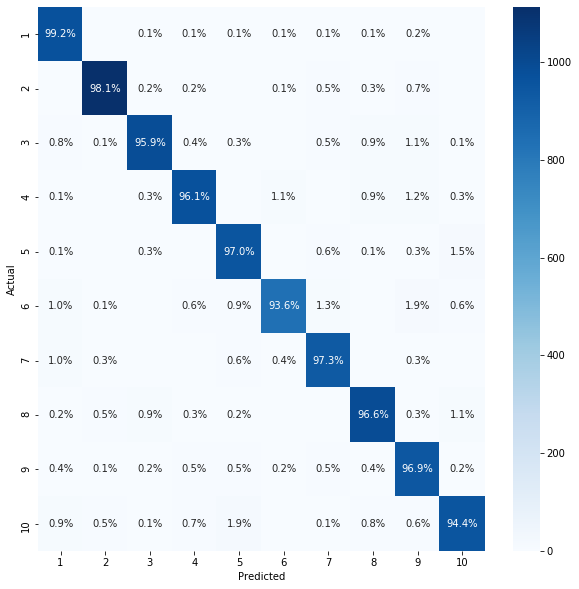

epoch  2 :  0 / 60000  (0 %)  | train loss:0.0860 | val loss:0.1137 | val acc:0.9682 | Time:1.1761
epoch  2 :  128 / 60000  (0 %)  | train loss:0.1111 | val loss:0.1129 | val acc:0.9688 | Time:2.7869
epoch  2 :  256 / 60000  (0 %)  | train loss:0.1289 | val loss:0.1120 | val acc:0.9688 | Time:4.6197
epoch  2 :  384 / 60000  (1 %)  | train loss:0.0832 | val loss:0.1109 | val acc:0.9692 | Time:6.0368
epoch  2 :  512 / 60000  (1 %)  | train loss:0.0448 | val loss:0.1099 | val acc:0.9678 | Time:7.8620
epoch  2 :  640 / 60000  (1 %)  | train loss:0.0642 | val loss:0.1092 | val acc:0.9688 | Time:9.7911
epoch  2 :  768 / 60000  (1 %)  | train loss:0.1245 | val loss:0.1087 | val acc:0.9686 | Time:11.0882
epoch  2 :  896 / 60000  (1 %)  | train loss:0.1353 | val loss:0.1087 | val acc:0.9684 | Time:12.5523
epoch  2 :  1024 / 60000  (2 %)  | train loss:0.1015 | val loss:0.1089 | val acc:0.9678 | Time:13.7429
epoch  2 :  1152 / 60000  (2 %)  | train loss:0.0808 | val loss:0.1088 | val acc:0.9680 |

epoch  2 :  10240 / 60000  (17 %)  | train loss:0.1653 | val loss:0.1034 | val acc:0.9680 | Time:98.8115
epoch  2 :  10368 / 60000  (17 %)  | train loss:0.0690 | val loss:0.1050 | val acc:0.9682 | Time:100.1157
epoch  2 :  10496 / 60000  (17 %)  | train loss:0.0708 | val loss:0.1067 | val acc:0.9694 | Time:101.3426
epoch  2 :  10624 / 60000  (18 %)  | train loss:0.1976 | val loss:0.1073 | val acc:0.9696 | Time:102.4744
epoch  2 :  10752 / 60000  (18 %)  | train loss:0.0602 | val loss:0.1079 | val acc:0.9692 | Time:103.6057
epoch  2 :  10880 / 60000  (18 %)  | train loss:0.0895 | val loss:0.1076 | val acc:0.9696 | Time:104.8266
epoch  2 :  11008 / 60000  (18 %)  | train loss:0.1109 | val loss:0.1068 | val acc:0.9692 | Time:105.9217
epoch  2 :  11136 / 60000  (19 %)  | train loss:0.1519 | val loss:0.1057 | val acc:0.9688 | Time:106.9850
epoch  2 :  11264 / 60000  (19 %)  | train loss:0.1425 | val loss:0.1031 | val acc:0.9710 | Time:108.0426
epoch  2 :  11392 / 60000  (19 %)  | train loss

epoch  2 :  20224 / 60000  (34 %)  | train loss:0.1547 | val loss:0.1024 | val acc:0.9684 | Time:184.7846
epoch  2 :  20352 / 60000  (34 %)  | train loss:0.1189 | val loss:0.1026 | val acc:0.9690 | Time:185.8551
epoch  2 :  20480 / 60000  (34 %)  | train loss:0.0913 | val loss:0.1021 | val acc:0.9692 | Time:186.9056
epoch  2 :  20608 / 60000  (34 %)  | train loss:0.1144 | val loss:0.1018 | val acc:0.9684 | Time:187.9474
epoch  2 :  20736 / 60000  (35 %)  | train loss:0.1679 | val loss:0.1016 | val acc:0.9690 | Time:188.9830
epoch  2 :  20864 / 60000  (35 %)  | train loss:0.0717 | val loss:0.1017 | val acc:0.9694 | Time:190.0101
epoch  2 :  20992 / 60000  (35 %)  | train loss:0.0661 | val loss:0.1025 | val acc:0.9694 | Time:191.0306
epoch  2 :  21120 / 60000  (35 %)  | train loss:0.1178 | val loss:0.1037 | val acc:0.9696 | Time:192.0560
epoch  2 :  21248 / 60000  (35 %)  | train loss:0.0465 | val loss:0.1050 | val acc:0.9690 | Time:193.1342
epoch  2 :  21376 / 60000  (36 %)  | train los

epoch  2 :  30208 / 60000  (50 %)  | train loss:0.0590 | val loss:0.0998 | val acc:0.9724 | Time:270.3943
epoch  2 :  30336 / 60000  (51 %)  | train loss:0.0600 | val loss:0.0998 | val acc:0.9722 | Time:271.6660
epoch  2 :  30464 / 60000  (51 %)  | train loss:0.1627 | val loss:0.0988 | val acc:0.9726 | Time:272.7364
epoch  2 :  30592 / 60000  (51 %)  | train loss:0.1200 | val loss:0.0980 | val acc:0.9732 | Time:273.7927
epoch  2 :  30720 / 60000  (51 %)  | train loss:0.0837 | val loss:0.0973 | val acc:0.9732 | Time:274.8879
epoch  2 :  30848 / 60000  (51 %)  | train loss:0.0998 | val loss:0.0967 | val acc:0.9728 | Time:275.9364
epoch  2 :  30976 / 60000  (52 %)  | train loss:0.0412 | val loss:0.0962 | val acc:0.9726 | Time:276.9843
epoch  2 :  31104 / 60000  (52 %)  | train loss:0.1175 | val loss:0.0956 | val acc:0.9734 | Time:278.0950
epoch  2 :  31232 / 60000  (52 %)  | train loss:0.0580 | val loss:0.0948 | val acc:0.9732 | Time:279.1372
epoch  2 :  31360 / 60000  (52 %)  | train los

epoch  2 :  40192 / 60000  (67 %)  | train loss:0.0369 | val loss:0.0918 | val acc:0.9748 | Time:357.3016
epoch  2 :  40320 / 60000  (67 %)  | train loss:0.1065 | val loss:0.0927 | val acc:0.9758 | Time:358.4406
epoch  2 :  40448 / 60000  (67 %)  | train loss:0.0313 | val loss:0.0942 | val acc:0.9754 | Time:359.5477
epoch  2 :  40576 / 60000  (68 %)  | train loss:0.1385 | val loss:0.0942 | val acc:0.9758 | Time:360.6900
epoch  2 :  40704 / 60000  (68 %)  | train loss:0.1205 | val loss:0.0944 | val acc:0.9754 | Time:361.9164
epoch  2 :  40832 / 60000  (68 %)  | train loss:0.0555 | val loss:0.0947 | val acc:0.9752 | Time:363.7294
epoch  2 :  40960 / 60000  (68 %)  | train loss:0.0380 | val loss:0.0957 | val acc:0.9748 | Time:365.0825
epoch  2 :  41088 / 60000  (68 %)  | train loss:0.1051 | val loss:0.0971 | val acc:0.9734 | Time:366.4155
epoch  2 :  41216 / 60000  (69 %)  | train loss:0.0709 | val loss:0.0984 | val acc:0.9728 | Time:367.8784
epoch  2 :  41344 / 60000  (69 %)  | train los

epoch  2 :  50176 / 60000  (84 %)  | train loss:0.0760 | val loss:0.0905 | val acc:0.9750 | Time:458.0872
epoch  2 :  50304 / 60000  (84 %)  | train loss:0.0828 | val loss:0.0904 | val acc:0.9742 | Time:459.4146
epoch  2 :  50432 / 60000  (84 %)  | train loss:0.1184 | val loss:0.0896 | val acc:0.9738 | Time:460.5375
epoch  2 :  50560 / 60000  (84 %)  | train loss:0.0952 | val loss:0.0887 | val acc:0.9750 | Time:461.7034
epoch  2 :  50688 / 60000  (84 %)  | train loss:0.0521 | val loss:0.0881 | val acc:0.9754 | Time:462.8297
epoch  2 :  50816 / 60000  (85 %)  | train loss:0.1992 | val loss:0.0883 | val acc:0.9754 | Time:463.9455
epoch  2 :  50944 / 60000  (85 %)  | train loss:0.0716 | val loss:0.0892 | val acc:0.9746 | Time:465.2092
epoch  2 :  51072 / 60000  (85 %)  | train loss:0.1914 | val loss:0.0897 | val acc:0.9746 | Time:466.9568
epoch  2 :  51200 / 60000  (85 %)  | train loss:0.1070 | val loss:0.0894 | val acc:0.9744 | Time:468.0931
epoch  2 :  51328 / 60000  (86 %)  | train los

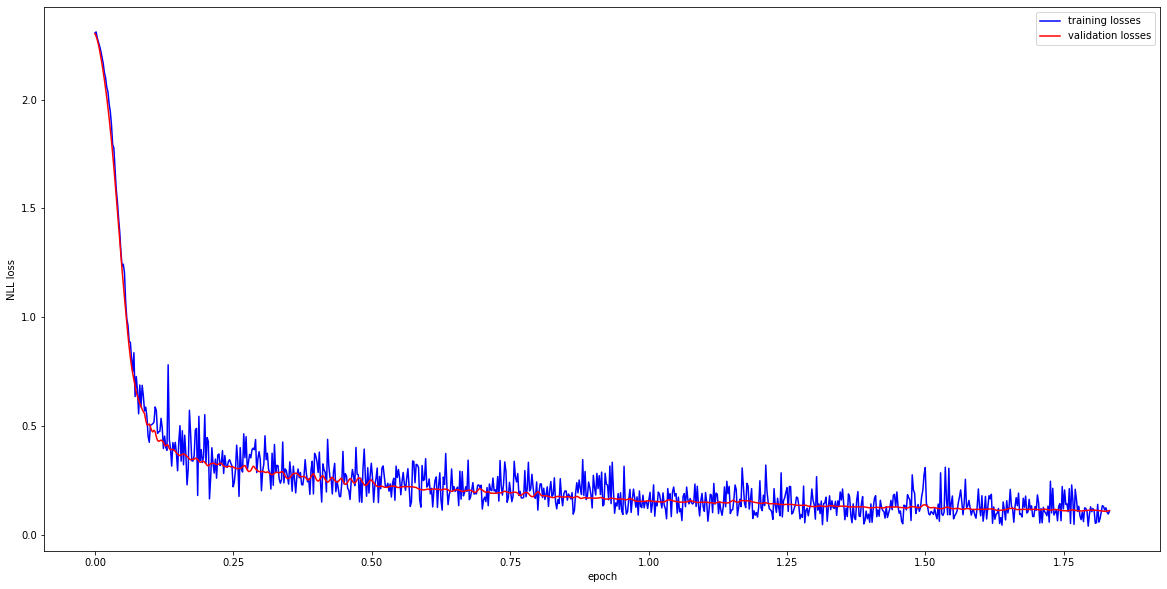

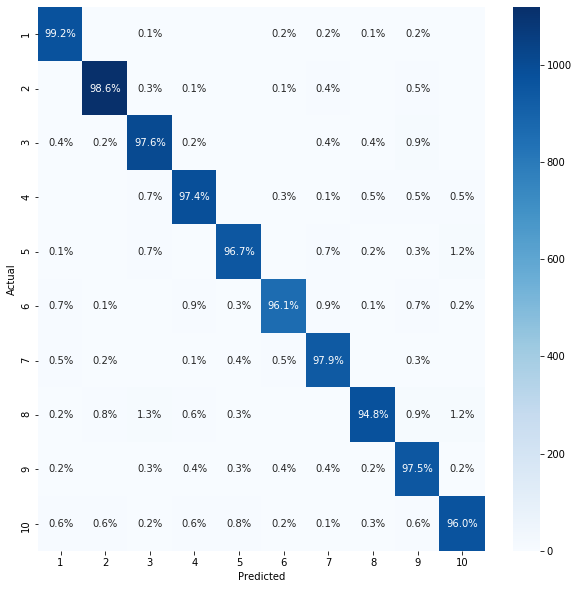

epoch  3 :  0 / 60000  (0 %)  | train loss:0.0700 | val loss:0.0907 | val acc:0.9750 | Time:1.1340
epoch  3 :  128 / 60000  (0 %)  | train loss:0.0914 | val loss:0.0894 | val acc:0.9760 | Time:2.3691
epoch  3 :  256 / 60000  (0 %)  | train loss:0.0438 | val loss:0.0886 | val acc:0.9756 | Time:3.6669
epoch  3 :  384 / 60000  (1 %)  | train loss:0.0751 | val loss:0.0886 | val acc:0.9748 | Time:5.0450
epoch  3 :  512 / 60000  (1 %)  | train loss:0.0545 | val loss:0.0887 | val acc:0.9750 | Time:6.5260
epoch  3 :  640 / 60000  (1 %)  | train loss:0.0814 | val loss:0.0886 | val acc:0.9756 | Time:8.1208
epoch  3 :  768 / 60000  (1 %)  | train loss:0.0234 | val loss:0.0886 | val acc:0.9746 | Time:9.3803
epoch  3 :  896 / 60000  (1 %)  | train loss:0.0409 | val loss:0.0888 | val acc:0.9742 | Time:10.7923
epoch  3 :  1024 / 60000  (2 %)  | train loss:0.0793 | val loss:0.0887 | val acc:0.9746 | Time:11.9860
epoch  3 :  1152 / 60000  (2 %)  | train loss:0.0284 | val loss:0.0886 | val acc:0.9748 | 

epoch  3 :  10240 / 60000  (17 %)  | train loss:0.0806 | val loss:0.0827 | val acc:0.9758 | Time:98.9358
epoch  3 :  10368 / 60000  (17 %)  | train loss:0.0332 | val loss:0.0823 | val acc:0.9770 | Time:100.3479
epoch  3 :  10496 / 60000  (17 %)  | train loss:0.0769 | val loss:0.0824 | val acc:0.9776 | Time:101.7064
epoch  3 :  10624 / 60000  (18 %)  | train loss:0.1743 | val loss:0.0824 | val acc:0.9770 | Time:103.1160
epoch  3 :  10752 / 60000  (18 %)  | train loss:0.0603 | val loss:0.0828 | val acc:0.9772 | Time:104.5230
epoch  3 :  10880 / 60000  (18 %)  | train loss:0.0393 | val loss:0.0829 | val acc:0.9774 | Time:105.7442
epoch  3 :  11008 / 60000  (18 %)  | train loss:0.0398 | val loss:0.0834 | val acc:0.9770 | Time:106.9635
epoch  3 :  11136 / 60000  (19 %)  | train loss:0.0428 | val loss:0.0842 | val acc:0.9770 | Time:108.2371
epoch  3 :  11264 / 60000  (19 %)  | train loss:0.0410 | val loss:0.0848 | val acc:0.9768 | Time:109.5418
epoch  3 :  11392 / 60000  (19 %)  | train loss

epoch  3 :  20224 / 60000  (34 %)  | train loss:0.0922 | val loss:0.0886 | val acc:0.9724 | Time:187.3904
epoch  3 :  20352 / 60000  (34 %)  | train loss:0.0639 | val loss:0.0898 | val acc:0.9722 | Time:188.4014
epoch  3 :  20480 / 60000  (34 %)  | train loss:0.1115 | val loss:0.0902 | val acc:0.9726 | Time:189.4803
epoch  3 :  20608 / 60000  (34 %)  | train loss:0.0334 | val loss:0.0902 | val acc:0.9722 | Time:190.5025
epoch  3 :  20736 / 60000  (35 %)  | train loss:0.0388 | val loss:0.0902 | val acc:0.9724 | Time:191.5068
epoch  3 :  20864 / 60000  (35 %)  | train loss:0.1098 | val loss:0.0894 | val acc:0.9720 | Time:192.5131
epoch  3 :  20992 / 60000  (35 %)  | train loss:0.1006 | val loss:0.0875 | val acc:0.9736 | Time:193.5638
epoch  3 :  21120 / 60000  (35 %)  | train loss:0.1234 | val loss:0.0850 | val acc:0.9752 | Time:194.6175
epoch  3 :  21248 / 60000  (35 %)  | train loss:0.0616 | val loss:0.0825 | val acc:0.9760 | Time:195.7487
epoch  3 :  21376 / 60000  (36 %)  | train los

epoch  3 :  30208 / 60000  (50 %)  | train loss:0.1147 | val loss:0.0817 | val acc:0.9774 | Time:278.6450
epoch  3 :  30336 / 60000  (51 %)  | train loss:0.0285 | val loss:0.0822 | val acc:0.9772 | Time:279.6557
epoch  3 :  30464 / 60000  (51 %)  | train loss:0.0782 | val loss:0.0829 | val acc:0.9770 | Time:280.6659
epoch  3 :  30592 / 60000  (51 %)  | train loss:0.0520 | val loss:0.0834 | val acc:0.9770 | Time:281.6802
epoch  3 :  30720 / 60000  (51 %)  | train loss:0.0664 | val loss:0.0837 | val acc:0.9764 | Time:282.6872
epoch  3 :  30848 / 60000  (51 %)  | train loss:0.0880 | val loss:0.0835 | val acc:0.9754 | Time:283.7522
epoch  3 :  30976 / 60000  (52 %)  | train loss:0.0883 | val loss:0.0831 | val acc:0.9760 | Time:284.7804
epoch  3 :  31104 / 60000  (52 %)  | train loss:0.0521 | val loss:0.0823 | val acc:0.9768 | Time:285.8215
epoch  3 :  31232 / 60000  (52 %)  | train loss:0.0310 | val loss:0.0819 | val acc:0.9762 | Time:286.8484
epoch  3 :  31360 / 60000  (52 %)  | train los

epoch  3 :  40192 / 60000  (67 %)  | train loss:0.1622 | val loss:0.0775 | val acc:0.9770 | Time:360.0838
epoch  3 :  40320 / 60000  (67 %)  | train loss:0.1049 | val loss:0.0768 | val acc:0.9760 | Time:361.1381
epoch  3 :  40448 / 60000  (67 %)  | train loss:0.0210 | val loss:0.0768 | val acc:0.9762 | Time:362.2696
epoch  3 :  40576 / 60000  (68 %)  | train loss:0.1183 | val loss:0.0773 | val acc:0.9776 | Time:363.2679
epoch  3 :  40704 / 60000  (68 %)  | train loss:0.0513 | val loss:0.0779 | val acc:0.9782 | Time:364.2745
epoch  3 :  40832 / 60000  (68 %)  | train loss:0.0724 | val loss:0.0788 | val acc:0.9782 | Time:365.3889
epoch  3 :  40960 / 60000  (68 %)  | train loss:0.0302 | val loss:0.0802 | val acc:0.9772 | Time:366.3942
epoch  3 :  41088 / 60000  (68 %)  | train loss:0.0348 | val loss:0.0816 | val acc:0.9762 | Time:367.4058
epoch  3 :  41216 / 60000  (69 %)  | train loss:0.0358 | val loss:0.0832 | val acc:0.9756 | Time:368.4156
epoch  3 :  41344 / 60000  (69 %)  | train los

epoch  3 :  50176 / 60000  (84 %)  | train loss:0.0098 | val loss:0.0774 | val acc:0.9780 | Time:444.2772
epoch  3 :  50304 / 60000  (84 %)  | train loss:0.0907 | val loss:0.0775 | val acc:0.9780 | Time:445.3468
epoch  3 :  50432 / 60000  (84 %)  | train loss:0.0345 | val loss:0.0777 | val acc:0.9780 | Time:446.4233
epoch  3 :  50560 / 60000  (84 %)  | train loss:0.0722 | val loss:0.0781 | val acc:0.9778 | Time:447.7796
epoch  3 :  50688 / 60000  (84 %)  | train loss:0.0428 | val loss:0.0784 | val acc:0.9782 | Time:449.0991
epoch  3 :  50816 / 60000  (85 %)  | train loss:0.0599 | val loss:0.0783 | val acc:0.9778 | Time:450.3244
epoch  3 :  50944 / 60000  (85 %)  | train loss:0.1007 | val loss:0.0777 | val acc:0.9772 | Time:451.5426
epoch  3 :  51072 / 60000  (85 %)  | train loss:0.0630 | val loss:0.0779 | val acc:0.9766 | Time:452.6479
epoch  3 :  51200 / 60000  (85 %)  | train loss:0.0269 | val loss:0.0782 | val acc:0.9766 | Time:454.1053
epoch  3 :  51328 / 60000  (86 %)  | train los

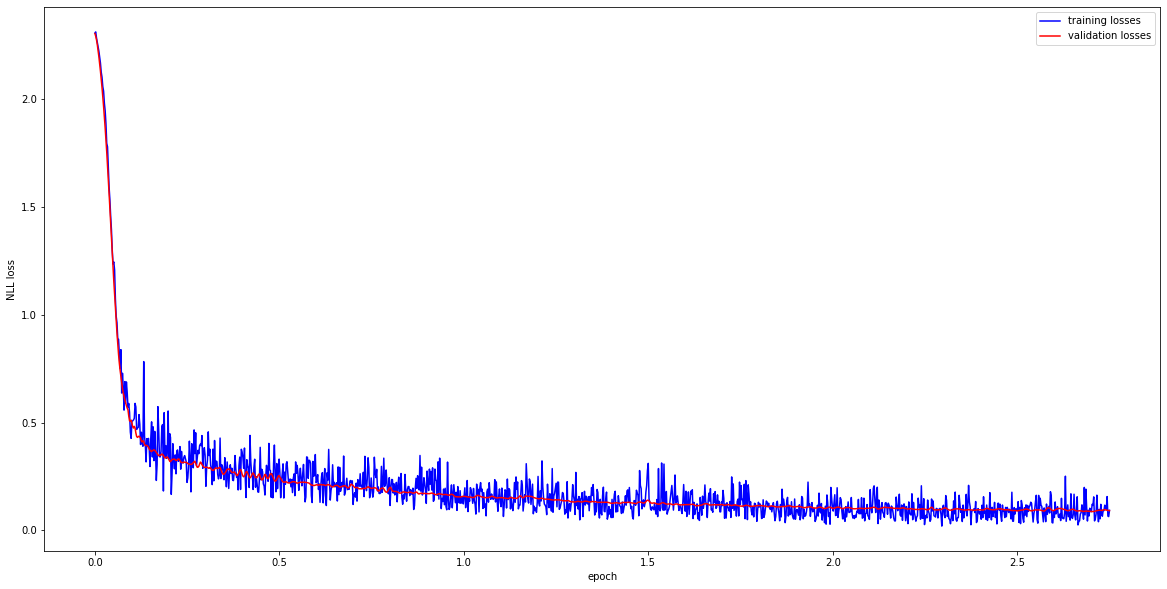

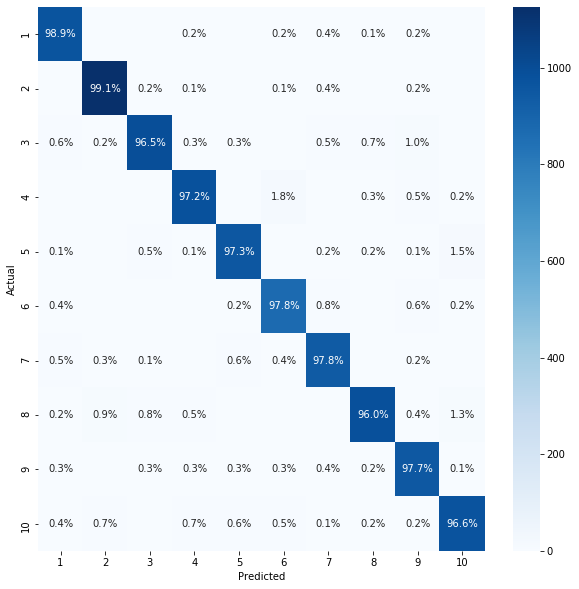

epoch  4 :  0 / 60000  (0 %)  | train loss:0.0324 | val loss:0.0778 | val acc:0.9776 | Time:1.0983
epoch  4 :  128 / 60000  (0 %)  | train loss:0.0218 | val loss:0.0778 | val acc:0.9774 | Time:2.1703
epoch  4 :  256 / 60000  (0 %)  | train loss:0.0717 | val loss:0.0778 | val acc:0.9784 | Time:3.4379
epoch  4 :  384 / 60000  (1 %)  | train loss:0.0431 | val loss:0.0782 | val acc:0.9782 | Time:4.5920
epoch  4 :  512 / 60000  (1 %)  | train loss:0.0229 | val loss:0.0787 | val acc:0.9774 | Time:5.7981
epoch  4 :  640 / 60000  (1 %)  | train loss:0.0529 | val loss:0.0791 | val acc:0.9766 | Time:7.0652
epoch  4 :  768 / 60000  (1 %)  | train loss:0.0259 | val loss:0.0796 | val acc:0.9758 | Time:8.3256
epoch  4 :  896 / 60000  (1 %)  | train loss:0.0436 | val loss:0.0795 | val acc:0.9760 | Time:9.8187
epoch  4 :  1024 / 60000  (2 %)  | train loss:0.0517 | val loss:0.0794 | val acc:0.9768 | Time:11.1013
epoch  4 :  1152 / 60000  (2 %)  | train loss:0.0473 | val loss:0.0790 | val acc:0.9770 | T

epoch  4 :  10240 / 60000  (17 %)  | train loss:0.0599 | val loss:0.0726 | val acc:0.9794 | Time:93.3357
epoch  4 :  10368 / 60000  (17 %)  | train loss:0.0204 | val loss:0.0728 | val acc:0.9790 | Time:94.9005
epoch  4 :  10496 / 60000  (17 %)  | train loss:0.1250 | val loss:0.0729 | val acc:0.9792 | Time:96.4824
epoch  4 :  10624 / 60000  (18 %)  | train loss:0.0205 | val loss:0.0730 | val acc:0.9794 | Time:97.9267
epoch  4 :  10752 / 60000  (18 %)  | train loss:0.0583 | val loss:0.0732 | val acc:0.9790 | Time:99.2292
epoch  4 :  10880 / 60000  (18 %)  | train loss:0.0537 | val loss:0.0735 | val acc:0.9792 | Time:100.4127
epoch  4 :  11008 / 60000  (18 %)  | train loss:0.0491 | val loss:0.0737 | val acc:0.9790 | Time:101.5760
epoch  4 :  11136 / 60000  (19 %)  | train loss:0.0862 | val loss:0.0732 | val acc:0.9792 | Time:102.7915
epoch  4 :  11264 / 60000  (19 %)  | train loss:0.0529 | val loss:0.0729 | val acc:0.9794 | Time:104.0982
epoch  4 :  11392 / 60000  (19 %)  | train loss:0.0

epoch  4 :  20224 / 60000  (34 %)  | train loss:0.0736 | val loss:0.0741 | val acc:0.9796 | Time:187.2871
epoch  4 :  20352 / 60000  (34 %)  | train loss:0.0524 | val loss:0.0733 | val acc:0.9798 | Time:188.3784
epoch  4 :  20480 / 60000  (34 %)  | train loss:0.0422 | val loss:0.0728 | val acc:0.9800 | Time:189.4740
epoch  4 :  20608 / 60000  (34 %)  | train loss:0.0511 | val loss:0.0724 | val acc:0.9798 | Time:190.5483
epoch  4 :  20736 / 60000  (35 %)  | train loss:0.0372 | val loss:0.0719 | val acc:0.9802 | Time:191.6779
epoch  4 :  20864 / 60000  (35 %)  | train loss:0.0169 | val loss:0.0716 | val acc:0.9792 | Time:192.7672
epoch  4 :  20992 / 60000  (35 %)  | train loss:0.0288 | val loss:0.0715 | val acc:0.9790 | Time:193.8501
epoch  4 :  21120 / 60000  (35 %)  | train loss:0.0444 | val loss:0.0713 | val acc:0.9790 | Time:195.0572
epoch  4 :  21248 / 60000  (35 %)  | train loss:0.0766 | val loss:0.0707 | val acc:0.9794 | Time:196.1221
epoch  4 :  21376 / 60000  (36 %)  | train los

epoch  4 :  30208 / 60000  (50 %)  | train loss:0.0856 | val loss:0.0725 | val acc:0.9794 | Time:276.1238
epoch  4 :  30336 / 60000  (51 %)  | train loss:0.0289 | val loss:0.0715 | val acc:0.9802 | Time:277.2298
epoch  4 :  30464 / 60000  (51 %)  | train loss:0.0168 | val loss:0.0710 | val acc:0.9808 | Time:278.3926
epoch  4 :  30592 / 60000  (51 %)  | train loss:0.0434 | val loss:0.0708 | val acc:0.9808 | Time:279.4828
epoch  4 :  30720 / 60000  (51 %)  | train loss:0.0420 | val loss:0.0710 | val acc:0.9800 | Time:280.6822
epoch  4 :  30848 / 60000  (51 %)  | train loss:0.0994 | val loss:0.0714 | val acc:0.9798 | Time:281.7712
epoch  4 :  30976 / 60000  (52 %)  | train loss:0.0207 | val loss:0.0721 | val acc:0.9794 | Time:282.8679
epoch  4 :  31104 / 60000  (52 %)  | train loss:0.0909 | val loss:0.0733 | val acc:0.9788 | Time:284.0252
epoch  4 :  31232 / 60000  (52 %)  | train loss:0.0845 | val loss:0.0737 | val acc:0.9786 | Time:285.1048
epoch  4 :  31360 / 60000  (52 %)  | train los

epoch  4 :  40192 / 60000  (67 %)  | train loss:0.0789 | val loss:0.0743 | val acc:0.9788 | Time:367.6604
epoch  4 :  40320 / 60000  (67 %)  | train loss:0.0628 | val loss:0.0729 | val acc:0.9792 | Time:368.7567
epoch  4 :  40448 / 60000  (67 %)  | train loss:0.0245 | val loss:0.0726 | val acc:0.9780 | Time:369.8742
epoch  4 :  40576 / 60000  (68 %)  | train loss:0.0224 | val loss:0.0728 | val acc:0.9782 | Time:371.0219
epoch  4 :  40704 / 60000  (68 %)  | train loss:0.0478 | val loss:0.0738 | val acc:0.9782 | Time:372.1112
epoch  4 :  40832 / 60000  (68 %)  | train loss:0.0524 | val loss:0.0748 | val acc:0.9786 | Time:373.2170
epoch  4 :  40960 / 60000  (68 %)  | train loss:0.0665 | val loss:0.0750 | val acc:0.9780 | Time:374.3190
epoch  4 :  41088 / 60000  (68 %)  | train loss:0.0753 | val loss:0.0744 | val acc:0.9784 | Time:375.4155
epoch  4 :  41216 / 60000  (69 %)  | train loss:0.0464 | val loss:0.0745 | val acc:0.9776 | Time:376.6345
epoch  4 :  41344 / 60000  (69 %)  | train los

epoch  4 :  50176 / 60000  (84 %)  | train loss:0.0286 | val loss:0.0767 | val acc:0.9770 | Time:457.3695
epoch  4 :  50304 / 60000  (84 %)  | train loss:0.0667 | val loss:0.0763 | val acc:0.9778 | Time:458.6206
epoch  4 :  50432 / 60000  (84 %)  | train loss:0.0515 | val loss:0.0756 | val acc:0.9778 | Time:459.7081
epoch  4 :  50560 / 60000  (84 %)  | train loss:0.0520 | val loss:0.0744 | val acc:0.9778 | Time:460.7724
epoch  4 :  50688 / 60000  (84 %)  | train loss:0.1317 | val loss:0.0735 | val acc:0.9784 | Time:462.0777
epoch  4 :  50816 / 60000  (85 %)  | train loss:0.0756 | val loss:0.0731 | val acc:0.9782 | Time:463.2391
epoch  4 :  50944 / 60000  (85 %)  | train loss:0.0976 | val loss:0.0731 | val acc:0.9780 | Time:464.6258
epoch  4 :  51072 / 60000  (85 %)  | train loss:0.0276 | val loss:0.0737 | val acc:0.9786 | Time:465.8379
epoch  4 :  51200 / 60000  (85 %)  | train loss:0.0506 | val loss:0.0744 | val acc:0.9784 | Time:467.0246
epoch  4 :  51328 / 60000  (86 %)  | train los

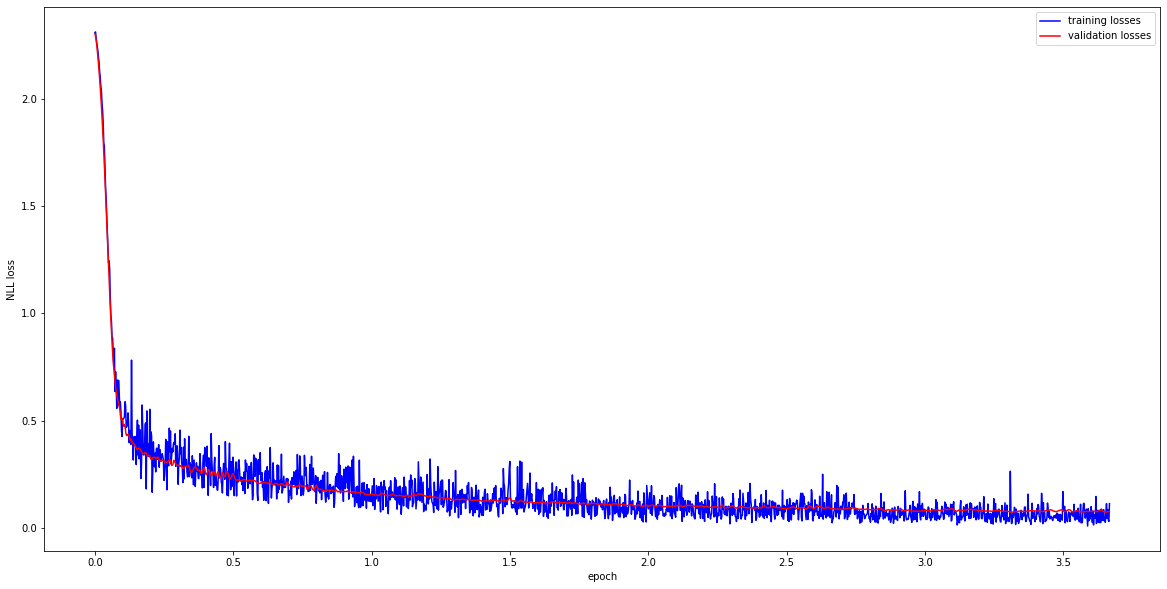

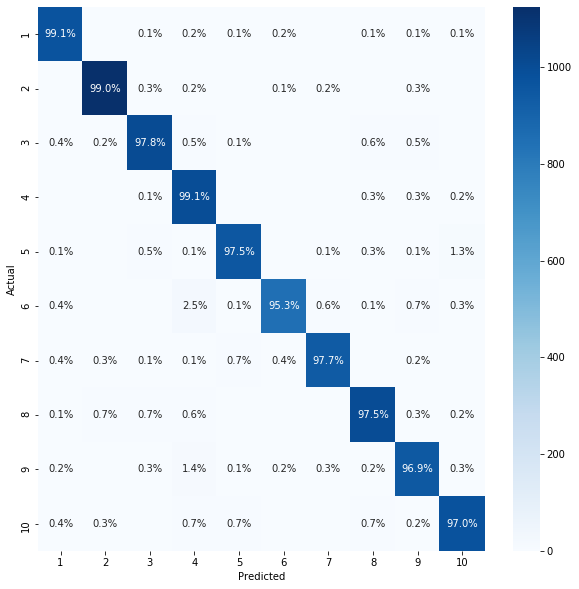

epoch  5 :  0 / 60000  (0 %)  | train loss:0.0398 | val loss:0.0691 | val acc:0.9794 | Time:1.4327
epoch  5 :  128 / 60000  (0 %)  | train loss:0.0278 | val loss:0.0688 | val acc:0.9800 | Time:3.1230
epoch  5 :  256 / 60000  (0 %)  | train loss:0.0253 | val loss:0.0685 | val acc:0.9800 | Time:4.3813
epoch  5 :  384 / 60000  (1 %)  | train loss:0.0428 | val loss:0.0675 | val acc:0.9804 | Time:5.5883
epoch  5 :  512 / 60000  (1 %)  | train loss:0.0415 | val loss:0.0668 | val acc:0.9808 | Time:6.9629
epoch  5 :  640 / 60000  (1 %)  | train loss:0.0249 | val loss:0.0662 | val acc:0.9810 | Time:8.3708
epoch  5 :  768 / 60000  (1 %)  | train loss:0.0309 | val loss:0.0658 | val acc:0.9816 | Time:9.6481
epoch  5 :  896 / 60000  (1 %)  | train loss:0.0420 | val loss:0.0652 | val acc:0.9818 | Time:10.9991
epoch  5 :  1024 / 60000  (2 %)  | train loss:0.0281 | val loss:0.0651 | val acc:0.9814 | Time:12.3644
epoch  5 :  1152 / 60000  (2 %)  | train loss:0.0225 | val loss:0.0651 | val acc:0.9814 | 

epoch  5 :  10240 / 60000  (17 %)  | train loss:0.0489 | val loss:0.0702 | val acc:0.9822 | Time:103.2379
epoch  5 :  10368 / 60000  (17 %)  | train loss:0.0520 | val loss:0.0713 | val acc:0.9802 | Time:104.6663
epoch  5 :  10496 / 60000  (17 %)  | train loss:0.0621 | val loss:0.0728 | val acc:0.9796 | Time:105.9214
epoch  5 :  10624 / 60000  (18 %)  | train loss:0.0135 | val loss:0.0743 | val acc:0.9786 | Time:107.0761
epoch  5 :  10752 / 60000  (18 %)  | train loss:0.0153 | val loss:0.0755 | val acc:0.9784 | Time:108.2113
epoch  5 :  10880 / 60000  (18 %)  | train loss:0.0474 | val loss:0.0765 | val acc:0.9776 | Time:109.4695
epoch  5 :  11008 / 60000  (18 %)  | train loss:0.0160 | val loss:0.0775 | val acc:0.9782 | Time:110.6520
epoch  5 :  11136 / 60000  (19 %)  | train loss:0.0324 | val loss:0.0779 | val acc:0.9776 | Time:112.1208
epoch  5 :  11264 / 60000  (19 %)  | train loss:0.0567 | val loss:0.0772 | val acc:0.9784 | Time:113.7457
epoch  5 :  11392 / 60000  (19 %)  | train los

epoch  5 :  20224 / 60000  (34 %)  | train loss:0.0138 | val loss:0.0711 | val acc:0.9802 | Time:196.7626
epoch  5 :  20352 / 60000  (34 %)  | train loss:0.0672 | val loss:0.0702 | val acc:0.9806 | Time:197.9830
epoch  5 :  20480 / 60000  (34 %)  | train loss:0.0239 | val loss:0.0695 | val acc:0.9812 | Time:199.0547
epoch  5 :  20608 / 60000  (34 %)  | train loss:0.0193 | val loss:0.0690 | val acc:0.9816 | Time:200.1218
epoch  5 :  20736 / 60000  (35 %)  | train loss:0.0191 | val loss:0.0687 | val acc:0.9814 | Time:201.2122
epoch  5 :  20864 / 60000  (35 %)  | train loss:0.0410 | val loss:0.0682 | val acc:0.9816 | Time:202.3139
epoch  5 :  20992 / 60000  (35 %)  | train loss:0.0696 | val loss:0.0679 | val acc:0.9814 | Time:203.3696
epoch  5 :  21120 / 60000  (35 %)  | train loss:0.0125 | val loss:0.0677 | val acc:0.9814 | Time:204.4364
epoch  5 :  21248 / 60000  (35 %)  | train loss:0.0166 | val loss:0.0675 | val acc:0.9814 | Time:205.4965
epoch  5 :  21376 / 60000  (36 %)  | train los

epoch  5 :  30208 / 60000  (50 %)  | train loss:0.0349 | val loss:0.0670 | val acc:0.9806 | Time:283.6127
epoch  5 :  30336 / 60000  (51 %)  | train loss:0.0117 | val loss:0.0664 | val acc:0.9806 | Time:285.1545
epoch  5 :  30464 / 60000  (51 %)  | train loss:0.0301 | val loss:0.0658 | val acc:0.9806 | Time:286.4710
epoch  5 :  30592 / 60000  (51 %)  | train loss:0.0098 | val loss:0.0655 | val acc:0.9810 | Time:287.7017
epoch  5 :  30720 / 60000  (51 %)  | train loss:0.0285 | val loss:0.0654 | val acc:0.9806 | Time:289.0087
epoch  5 :  30848 / 60000  (51 %)  | train loss:0.0292 | val loss:0.0657 | val acc:0.9806 | Time:290.0977
epoch  5 :  30976 / 60000  (52 %)  | train loss:0.0383 | val loss:0.0659 | val acc:0.9804 | Time:291.3518
epoch  5 :  31104 / 60000  (52 %)  | train loss:0.0430 | val loss:0.0661 | val acc:0.9798 | Time:292.5179
epoch  5 :  31232 / 60000  (52 %)  | train loss:0.0332 | val loss:0.0661 | val acc:0.9798 | Time:293.6951
epoch  5 :  31360 / 60000  (52 %)  | train los

epoch  5 :  40192 / 60000  (67 %)  | train loss:0.0319 | val loss:0.0642 | val acc:0.9824 | Time:384.0116
epoch  5 :  40320 / 60000  (67 %)  | train loss:0.0321 | val loss:0.0645 | val acc:0.9824 | Time:385.2126
epoch  5 :  40448 / 60000  (67 %)  | train loss:0.0176 | val loss:0.0652 | val acc:0.9818 | Time:386.4464
epoch  5 :  40576 / 60000  (68 %)  | train loss:0.0219 | val loss:0.0661 | val acc:0.9814 | Time:388.0004
epoch  5 :  40704 / 60000  (68 %)  | train loss:0.0374 | val loss:0.0672 | val acc:0.9816 | Time:389.3971
epoch  5 :  40832 / 60000  (68 %)  | train loss:0.0200 | val loss:0.0685 | val acc:0.9806 | Time:391.2319
epoch  5 :  40960 / 60000  (68 %)  | train loss:0.0094 | val loss:0.0699 | val acc:0.9804 | Time:392.6847
epoch  5 :  41088 / 60000  (68 %)  | train loss:0.0392 | val loss:0.0710 | val acc:0.9798 | Time:394.2404
epoch  5 :  41216 / 60000  (69 %)  | train loss:0.0345 | val loss:0.0710 | val acc:0.9804 | Time:395.6081
epoch  5 :  41344 / 60000  (69 %)  | train los

epoch  5 :  50176 / 60000  (84 %)  | train loss:0.0529 | val loss:0.0681 | val acc:0.9810 | Time:489.2415
epoch  5 :  50304 / 60000  (84 %)  | train loss:0.0283 | val loss:0.0673 | val acc:0.9812 | Time:490.3749
epoch  5 :  50432 / 60000  (84 %)  | train loss:0.0237 | val loss:0.0667 | val acc:0.9818 | Time:491.4995
epoch  5 :  50560 / 60000  (84 %)  | train loss:0.0321 | val loss:0.0662 | val acc:0.9820 | Time:492.7324
epoch  5 :  50688 / 60000  (84 %)  | train loss:0.0294 | val loss:0.0659 | val acc:0.9816 | Time:493.8932
epoch  5 :  50816 / 60000  (85 %)  | train loss:0.0661 | val loss:0.0658 | val acc:0.9816 | Time:495.0320
epoch  5 :  50944 / 60000  (85 %)  | train loss:0.0360 | val loss:0.0655 | val acc:0.9820 | Time:496.3424
epoch  5 :  51072 / 60000  (85 %)  | train loss:0.0677 | val loss:0.0652 | val acc:0.9826 | Time:497.6094
epoch  5 :  51200 / 60000  (85 %)  | train loss:0.0268 | val loss:0.0653 | val acc:0.9822 | Time:499.0202
epoch  5 :  51328 / 60000  (86 %)  | train los

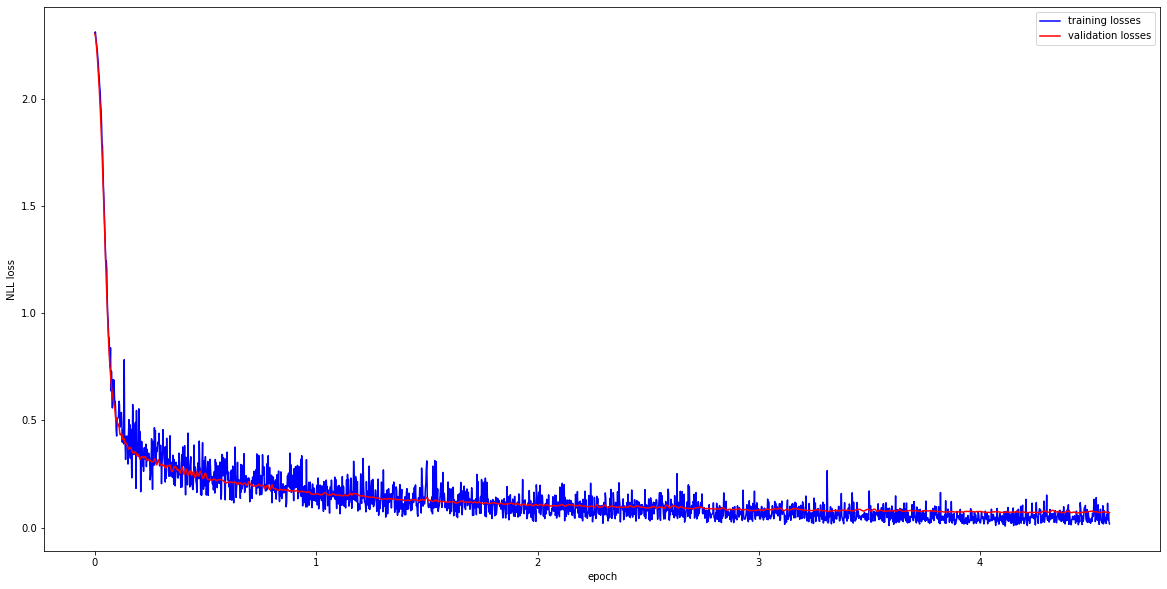

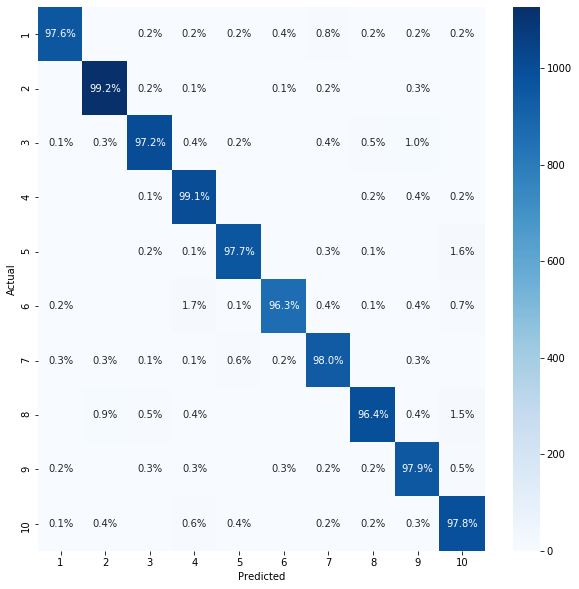

epoch  6 :  0 / 60000  (0 %)  | train loss:0.0499 | val loss:0.0683 | val acc:0.9800 | Time:1.2579
epoch  6 :  128 / 60000  (0 %)  | train loss:0.0440 | val loss:0.0678 | val acc:0.9796 | Time:2.8390
epoch  6 :  256 / 60000  (0 %)  | train loss:0.0271 | val loss:0.0671 | val acc:0.9802 | Time:4.3853
epoch  6 :  384 / 60000  (1 %)  | train loss:0.0158 | val loss:0.0667 | val acc:0.9808 | Time:5.8933
epoch  6 :  512 / 60000  (1 %)  | train loss:0.0237 | val loss:0.0665 | val acc:0.9812 | Time:7.6065
epoch  6 :  640 / 60000  (1 %)  | train loss:0.0209 | val loss:0.0665 | val acc:0.9808 | Time:9.0406
epoch  6 :  768 / 60000  (1 %)  | train loss:0.0294 | val loss:0.0670 | val acc:0.9812 | Time:10.5451
epoch  6 :  896 / 60000  (1 %)  | train loss:0.0060 | val loss:0.0676 | val acc:0.9816 | Time:11.9121
epoch  6 :  1024 / 60000  (2 %)  | train loss:0.0187 | val loss:0.0684 | val acc:0.9800 | Time:13.2441
epoch  6 :  1152 / 60000  (2 %)  | train loss:0.0217 | val loss:0.0692 | val acc:0.9798 |

epoch  6 :  10240 / 60000  (17 %)  | train loss:0.0202 | val loss:0.0662 | val acc:0.9810 | Time:102.9154
epoch  6 :  10368 / 60000  (17 %)  | train loss:0.0321 | val loss:0.0659 | val acc:0.9806 | Time:103.9653
epoch  6 :  10496 / 60000  (17 %)  | train loss:0.0189 | val loss:0.0656 | val acc:0.9812 | Time:105.0073
epoch  6 :  10624 / 60000  (18 %)  | train loss:0.0501 | val loss:0.0654 | val acc:0.9818 | Time:106.0620
epoch  6 :  10752 / 60000  (18 %)  | train loss:0.0498 | val loss:0.0652 | val acc:0.9818 | Time:107.1616
epoch  6 :  10880 / 60000  (18 %)  | train loss:0.0094 | val loss:0.0653 | val acc:0.9812 | Time:108.2254
epoch  6 :  11008 / 60000  (18 %)  | train loss:0.0297 | val loss:0.0657 | val acc:0.9816 | Time:109.2732
epoch  6 :  11136 / 60000  (19 %)  | train loss:0.0435 | val loss:0.0654 | val acc:0.9816 | Time:110.3437
epoch  6 :  11264 / 60000  (19 %)  | train loss:0.0120 | val loss:0.0655 | val acc:0.9808 | Time:111.3845
epoch  6 :  11392 / 60000  (19 %)  | train los

epoch  6 :  20224 / 60000  (34 %)  | train loss:0.0388 | val loss:0.0661 | val acc:0.9812 | Time:190.4137
epoch  6 :  20352 / 60000  (34 %)  | train loss:0.0390 | val loss:0.0664 | val acc:0.9810 | Time:191.4100
epoch  6 :  20480 / 60000  (34 %)  | train loss:0.0210 | val loss:0.0665 | val acc:0.9808 | Time:192.3983
epoch  6 :  20608 / 60000  (34 %)  | train loss:0.0089 | val loss:0.0667 | val acc:0.9812 | Time:193.4187
epoch  6 :  20736 / 60000  (35 %)  | train loss:0.0424 | val loss:0.0662 | val acc:0.9812 | Time:194.4283
epoch  6 :  20864 / 60000  (35 %)  | train loss:0.0099 | val loss:0.0659 | val acc:0.9812 | Time:195.4458
epoch  6 :  20992 / 60000  (35 %)  | train loss:0.0664 | val loss:0.0653 | val acc:0.9814 | Time:196.4481
epoch  6 :  21120 / 60000  (35 %)  | train loss:0.0301 | val loss:0.0653 | val acc:0.9804 | Time:197.4908
epoch  6 :  21248 / 60000  (35 %)  | train loss:0.0124 | val loss:0.0657 | val acc:0.9806 | Time:198.5014
epoch  6 :  21376 / 60000  (36 %)  | train los

epoch  6 :  30208 / 60000  (50 %)  | train loss:0.0437 | val loss:0.0624 | val acc:0.9814 | Time:281.2058
epoch  6 :  30336 / 60000  (51 %)  | train loss:0.0102 | val loss:0.0623 | val acc:0.9816 | Time:282.4493
epoch  6 :  30464 / 60000  (51 %)  | train loss:0.0501 | val loss:0.0623 | val acc:0.9814 | Time:283.7600
epoch  6 :  30592 / 60000  (51 %)  | train loss:0.0554 | val loss:0.0624 | val acc:0.9816 | Time:285.1181
epoch  6 :  30720 / 60000  (51 %)  | train loss:0.0118 | val loss:0.0626 | val acc:0.9812 | Time:286.2469
epoch  6 :  30848 / 60000  (51 %)  | train loss:0.0427 | val loss:0.0627 | val acc:0.9816 | Time:287.3101
epoch  6 :  30976 / 60000  (52 %)  | train loss:0.0159 | val loss:0.0631 | val acc:0.9808 | Time:288.3577
epoch  6 :  31104 / 60000  (52 %)  | train loss:0.0113 | val loss:0.0635 | val acc:0.9804 | Time:289.3897
epoch  6 :  31232 / 60000  (52 %)  | train loss:0.0093 | val loss:0.0639 | val acc:0.9800 | Time:290.4515
epoch  6 :  31360 / 60000  (52 %)  | train los

epoch  6 :  40192 / 60000  (67 %)  | train loss:0.0068 | val loss:0.0649 | val acc:0.9830 | Time:372.9468
epoch  6 :  40320 / 60000  (67 %)  | train loss:0.0217 | val loss:0.0652 | val acc:0.9826 | Time:374.0959
epoch  6 :  40448 / 60000  (67 %)  | train loss:0.0104 | val loss:0.0653 | val acc:0.9822 | Time:375.3327
epoch  6 :  40576 / 60000  (68 %)  | train loss:0.0268 | val loss:0.0650 | val acc:0.9822 | Time:376.6450
epoch  6 :  40704 / 60000  (68 %)  | train loss:0.0379 | val loss:0.0646 | val acc:0.9824 | Time:378.0829
epoch  6 :  40832 / 60000  (68 %)  | train loss:0.0286 | val loss:0.0643 | val acc:0.9824 | Time:379.2536
epoch  6 :  40960 / 60000  (68 %)  | train loss:0.0079 | val loss:0.0641 | val acc:0.9822 | Time:380.4254
epoch  6 :  41088 / 60000  (68 %)  | train loss:0.0142 | val loss:0.0640 | val acc:0.9826 | Time:381.5990
epoch  6 :  41216 / 60000  (69 %)  | train loss:0.0096 | val loss:0.0640 | val acc:0.9828 | Time:382.6363
epoch  6 :  41344 / 60000  (69 %)  | train los

epoch  6 :  50176 / 60000  (84 %)  | train loss:0.0127 | val loss:0.0619 | val acc:0.9822 | Time:463.4950
epoch  6 :  50304 / 60000  (84 %)  | train loss:0.0759 | val loss:0.0620 | val acc:0.9826 | Time:464.8805
epoch  6 :  50432 / 60000  (84 %)  | train loss:0.0192 | val loss:0.0622 | val acc:0.9822 | Time:466.1980
epoch  6 :  50560 / 60000  (84 %)  | train loss:0.0280 | val loss:0.0623 | val acc:0.9820 | Time:467.4996
epoch  6 :  50688 / 60000  (84 %)  | train loss:0.0212 | val loss:0.0626 | val acc:0.9822 | Time:468.7963
epoch  6 :  50816 / 60000  (85 %)  | train loss:0.0207 | val loss:0.0627 | val acc:0.9820 | Time:470.0862
epoch  6 :  50944 / 60000  (85 %)  | train loss:0.0212 | val loss:0.0624 | val acc:0.9816 | Time:471.3632
epoch  6 :  51072 / 60000  (85 %)  | train loss:0.0331 | val loss:0.0624 | val acc:0.9816 | Time:472.4373
epoch  6 :  51200 / 60000  (85 %)  | train loss:0.0650 | val loss:0.0623 | val acc:0.9818 | Time:473.5116
epoch  6 :  51328 / 60000  (86 %)  | train los

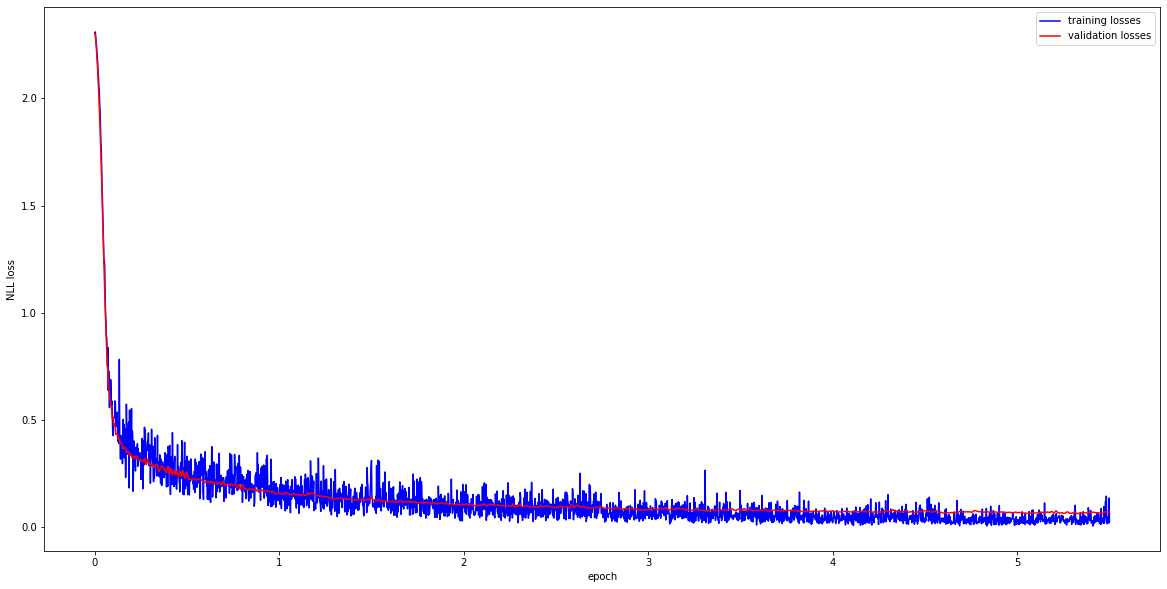

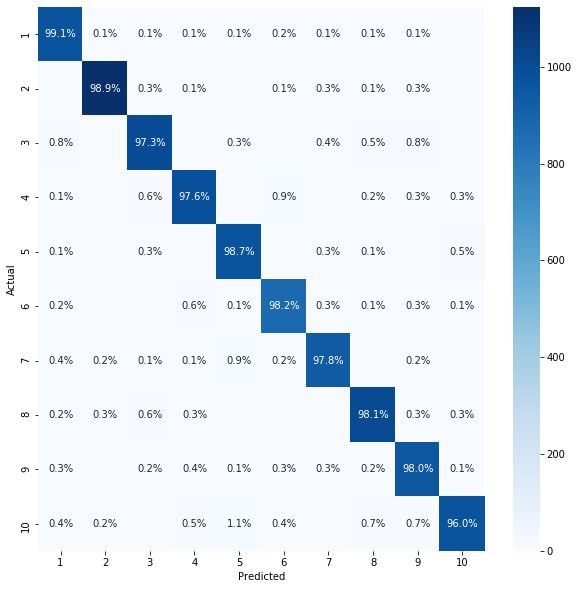

epoch  7 :  0 / 60000  (0 %)  | train loss:0.0075 | val loss:0.0647 | val acc:0.9818 | Time:1.0700
epoch  7 :  128 / 60000  (0 %)  | train loss:0.0273 | val loss:0.0648 | val acc:0.9822 | Time:2.1399
epoch  7 :  256 / 60000  (0 %)  | train loss:0.0203 | val loss:0.0649 | val acc:0.9822 | Time:3.3246
epoch  7 :  384 / 60000  (1 %)  | train loss:0.0083 | val loss:0.0650 | val acc:0.9818 | Time:4.3612
epoch  7 :  512 / 60000  (1 %)  | train loss:0.0232 | val loss:0.0646 | val acc:0.9814 | Time:5.5816
epoch  7 :  640 / 60000  (1 %)  | train loss:0.0147 | val loss:0.0639 | val acc:0.9826 | Time:6.8021
epoch  7 :  768 / 60000  (1 %)  | train loss:0.0756 | val loss:0.0633 | val acc:0.9826 | Time:8.2107
epoch  7 :  896 / 60000  (1 %)  | train loss:0.0109 | val loss:0.0630 | val acc:0.9822 | Time:9.5037
epoch  7 :  1024 / 60000  (2 %)  | train loss:0.0086 | val loss:0.0631 | val acc:0.9826 | Time:10.9996
epoch  7 :  1152 / 60000  (2 %)  | train loss:0.0058 | val loss:0.0634 | val acc:0.9828 | T

epoch  7 :  10240 / 60000  (17 %)  | train loss:0.0265 | val loss:0.0609 | val acc:0.9820 | Time:104.7764
epoch  7 :  10368 / 60000  (17 %)  | train loss:0.0485 | val loss:0.0609 | val acc:0.9816 | Time:106.1281
epoch  7 :  10496 / 60000  (17 %)  | train loss:0.0076 | val loss:0.0611 | val acc:0.9820 | Time:107.4051
epoch  7 :  10624 / 60000  (18 %)  | train loss:0.0126 | val loss:0.0614 | val acc:0.9820 | Time:108.6422
epoch  7 :  10752 / 60000  (18 %)  | train loss:0.0108 | val loss:0.0618 | val acc:0.9818 | Time:109.8998
epoch  7 :  10880 / 60000  (18 %)  | train loss:0.0123 | val loss:0.0622 | val acc:0.9814 | Time:111.0642
epoch  7 :  11008 / 60000  (18 %)  | train loss:0.0148 | val loss:0.0627 | val acc:0.9812 | Time:112.2169
epoch  7 :  11136 / 60000  (19 %)  | train loss:0.0103 | val loss:0.0633 | val acc:0.9816 | Time:113.3402
epoch  7 :  11264 / 60000  (19 %)  | train loss:0.0280 | val loss:0.0640 | val acc:0.9814 | Time:114.5036
epoch  7 :  11392 / 60000  (19 %)  | train los

epoch  7 :  20224 / 60000  (34 %)  | train loss:0.0082 | val loss:0.0618 | val acc:0.9812 | Time:201.6089
epoch  7 :  20352 / 60000  (34 %)  | train loss:0.0105 | val loss:0.0612 | val acc:0.9818 | Time:202.7864
epoch  7 :  20480 / 60000  (34 %)  | train loss:0.0157 | val loss:0.0607 | val acc:0.9814 | Time:204.1726
epoch  7 :  20608 / 60000  (34 %)  | train loss:0.0191 | val loss:0.0601 | val acc:0.9818 | Time:205.5672
epoch  7 :  20736 / 60000  (35 %)  | train loss:0.0168 | val loss:0.0595 | val acc:0.9822 | Time:207.0408
epoch  7 :  20864 / 60000  (35 %)  | train loss:0.0390 | val loss:0.0592 | val acc:0.9826 | Time:208.2007
epoch  7 :  20992 / 60000  (35 %)  | train loss:0.0162 | val loss:0.0589 | val acc:0.9826 | Time:209.4510
epoch  7 :  21120 / 60000  (35 %)  | train loss:0.0158 | val loss:0.0587 | val acc:0.9828 | Time:210.6122
epoch  7 :  21248 / 60000  (35 %)  | train loss:0.0339 | val loss:0.0585 | val acc:0.9832 | Time:211.7866
epoch  7 :  21376 / 60000  (36 %)  | train los

epoch  7 :  30208 / 60000  (50 %)  | train loss:0.0051 | val loss:0.0628 | val acc:0.9824 | Time:298.8009
epoch  7 :  30336 / 60000  (51 %)  | train loss:0.0274 | val loss:0.0624 | val acc:0.9818 | Time:299.9519
epoch  7 :  30464 / 60000  (51 %)  | train loss:0.0288 | val loss:0.0621 | val acc:0.9816 | Time:301.1832
epoch  7 :  30592 / 60000  (51 %)  | train loss:0.0119 | val loss:0.0620 | val acc:0.9816 | Time:302.2722
epoch  7 :  30720 / 60000  (51 %)  | train loss:0.0202 | val loss:0.0622 | val acc:0.9818 | Time:303.3888
epoch  7 :  30848 / 60000  (51 %)  | train loss:0.0125 | val loss:0.0623 | val acc:0.9818 | Time:304.5294
epoch  7 :  30976 / 60000  (52 %)  | train loss:0.0202 | val loss:0.0623 | val acc:0.9820 | Time:305.6674
epoch  7 :  31104 / 60000  (52 %)  | train loss:0.0181 | val loss:0.0624 | val acc:0.9816 | Time:306.7834
epoch  7 :  31232 / 60000  (52 %)  | train loss:0.0304 | val loss:0.0624 | val acc:0.9820 | Time:307.9563
epoch  7 :  31360 / 60000  (52 %)  | train los

epoch  7 :  40192 / 60000  (67 %)  | train loss:0.0119 | val loss:0.0606 | val acc:0.9830 | Time:393.8765
epoch  7 :  40320 / 60000  (67 %)  | train loss:0.0472 | val loss:0.0610 | val acc:0.9836 | Time:395.0418
epoch  7 :  40448 / 60000  (67 %)  | train loss:0.0272 | val loss:0.0618 | val acc:0.9834 | Time:396.2631
epoch  7 :  40576 / 60000  (68 %)  | train loss:0.0100 | val loss:0.0629 | val acc:0.9830 | Time:397.3800
epoch  7 :  40704 / 60000  (68 %)  | train loss:0.0101 | val loss:0.0638 | val acc:0.9820 | Time:398.5180
epoch  7 :  40832 / 60000  (68 %)  | train loss:0.0122 | val loss:0.0646 | val acc:0.9820 | Time:399.6128
epoch  7 :  40960 / 60000  (68 %)  | train loss:0.0456 | val loss:0.0648 | val acc:0.9820 | Time:400.8090
epoch  7 :  41088 / 60000  (68 %)  | train loss:0.0158 | val loss:0.0646 | val acc:0.9818 | Time:401.9144
epoch  7 :  41216 / 60000  (69 %)  | train loss:0.0163 | val loss:0.0643 | val acc:0.9822 | Time:403.0517
epoch  7 :  41344 / 60000  (69 %)  | train los

epoch  7 :  50176 / 60000  (84 %)  | train loss:0.0163 | val loss:0.0598 | val acc:0.9838 | Time:488.5598
epoch  7 :  50304 / 60000  (84 %)  | train loss:0.0178 | val loss:0.0595 | val acc:0.9836 | Time:489.8148
epoch  7 :  50432 / 60000  (84 %)  | train loss:0.0075 | val loss:0.0595 | val acc:0.9836 | Time:490.9381
epoch  7 :  50560 / 60000  (84 %)  | train loss:0.0256 | val loss:0.0597 | val acc:0.9832 | Time:492.0886
epoch  7 :  50688 / 60000  (84 %)  | train loss:0.0043 | val loss:0.0600 | val acc:0.9832 | Time:493.3037
epoch  7 :  50816 / 60000  (85 %)  | train loss:0.0177 | val loss:0.0604 | val acc:0.9828 | Time:494.5444
epoch  7 :  50944 / 60000  (85 %)  | train loss:0.0077 | val loss:0.0609 | val acc:0.9832 | Time:495.6499
epoch  7 :  51072 / 60000  (85 %)  | train loss:0.0103 | val loss:0.0615 | val acc:0.9826 | Time:496.8278
epoch  7 :  51200 / 60000  (85 %)  | train loss:0.0174 | val loss:0.0620 | val acc:0.9824 | Time:498.0079
epoch  7 :  51328 / 60000  (86 %)  | train los

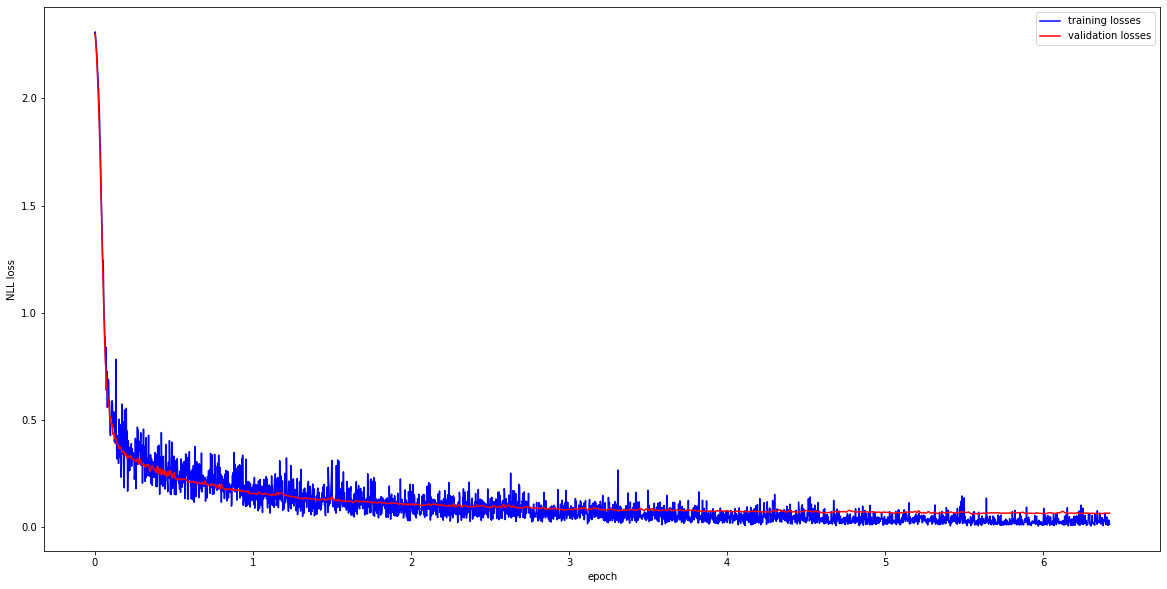

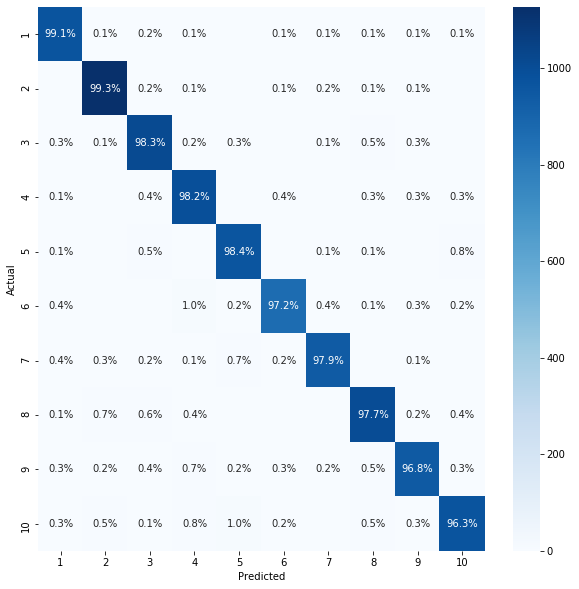

epoch  8 :  0 / 60000  (0 %)  | train loss:0.0036 | val loss:0.0647 | val acc:0.9802 | Time:1.3740
epoch  8 :  128 / 60000  (0 %)  | train loss:0.0260 | val loss:0.0644 | val acc:0.9808 | Time:2.5773
epoch  8 :  256 / 60000  (0 %)  | train loss:0.0196 | val loss:0.0643 | val acc:0.9816 | Time:3.8069
epoch  8 :  384 / 60000  (1 %)  | train loss:0.0227 | val loss:0.0641 | val acc:0.9826 | Time:5.1136
epoch  8 :  512 / 60000  (1 %)  | train loss:0.0238 | val loss:0.0637 | val acc:0.9824 | Time:6.6512
epoch  8 :  640 / 60000  (1 %)  | train loss:0.0106 | val loss:0.0637 | val acc:0.9822 | Time:8.1588
epoch  8 :  768 / 60000  (1 %)  | train loss:0.0207 | val loss:0.0633 | val acc:0.9830 | Time:9.7077
epoch  8 :  896 / 60000  (1 %)  | train loss:0.0305 | val loss:0.0626 | val acc:0.9834 | Time:11.2712
epoch  8 :  1024 / 60000  (2 %)  | train loss:0.0212 | val loss:0.0620 | val acc:0.9834 | Time:12.6495
epoch  8 :  1152 / 60000  (2 %)  | train loss:0.0074 | val loss:0.0617 | val acc:0.9834 | 

epoch  8 :  10240 / 60000  (17 %)  | train loss:0.0151 | val loss:0.0635 | val acc:0.9822 | Time:100.3192
epoch  8 :  10368 / 60000  (17 %)  | train loss:0.0179 | val loss:0.0638 | val acc:0.9820 | Time:101.4002
epoch  8 :  10496 / 60000  (17 %)  | train loss:0.0096 | val loss:0.0641 | val acc:0.9820 | Time:102.4728
epoch  8 :  10624 / 60000  (18 %)  | train loss:0.0126 | val loss:0.0643 | val acc:0.9822 | Time:103.5293
epoch  8 :  10752 / 60000  (18 %)  | train loss:0.0222 | val loss:0.0640 | val acc:0.9824 | Time:104.6758
epoch  8 :  10880 / 60000  (18 %)  | train loss:0.0111 | val loss:0.0639 | val acc:0.9824 | Time:106.1760
epoch  8 :  11008 / 60000  (18 %)  | train loss:0.0121 | val loss:0.0634 | val acc:0.9828 | Time:107.3581
epoch  8 :  11136 / 60000  (19 %)  | train loss:0.0117 | val loss:0.0630 | val acc:0.9828 | Time:108.5597
epoch  8 :  11264 / 60000  (19 %)  | train loss:0.0102 | val loss:0.0622 | val acc:0.9830 | Time:109.7469
epoch  8 :  11392 / 60000  (19 %)  | train los

epoch  8 :  20224 / 60000  (34 %)  | train loss:0.0114 | val loss:0.0664 | val acc:0.9810 | Time:198.0578
epoch  8 :  20352 / 60000  (34 %)  | train loss:0.0053 | val loss:0.0661 | val acc:0.9808 | Time:199.8683
epoch  8 :  20480 / 60000  (34 %)  | train loss:0.0140 | val loss:0.0655 | val acc:0.9806 | Time:201.3653
epoch  8 :  20608 / 60000  (34 %)  | train loss:0.0187 | val loss:0.0651 | val acc:0.9808 | Time:202.7731
epoch  8 :  20736 / 60000  (35 %)  | train loss:0.0299 | val loss:0.0644 | val acc:0.9812 | Time:204.2435
epoch  8 :  20864 / 60000  (35 %)  | train loss:0.0114 | val loss:0.0637 | val acc:0.9814 | Time:205.6695
epoch  8 :  20992 / 60000  (35 %)  | train loss:0.0110 | val loss:0.0628 | val acc:0.9820 | Time:206.9580
epoch  8 :  21120 / 60000  (35 %)  | train loss:0.0237 | val loss:0.0625 | val acc:0.9822 | Time:208.4057
epoch  8 :  21248 / 60000  (35 %)  | train loss:0.0135 | val loss:0.0626 | val acc:0.9818 | Time:209.9519
epoch  8 :  21376 / 60000  (36 %)  | train los

epoch  8 :  30208 / 60000  (50 %)  | train loss:0.0273 | val loss:0.0614 | val acc:0.9810 | Time:310.8392
epoch  8 :  30336 / 60000  (51 %)  | train loss:0.0260 | val loss:0.0612 | val acc:0.9814 | Time:312.0621
epoch  8 :  30464 / 60000  (51 %)  | train loss:0.0036 | val loss:0.0611 | val acc:0.9814 | Time:313.2952
epoch  8 :  30592 / 60000  (51 %)  | train loss:0.0109 | val loss:0.0612 | val acc:0.9818 | Time:314.4675
epoch  8 :  30720 / 60000  (51 %)  | train loss:0.0137 | val loss:0.0615 | val acc:0.9822 | Time:315.5946
epoch  8 :  30848 / 60000  (51 %)  | train loss:0.0121 | val loss:0.0620 | val acc:0.9822 | Time:316.7706
epoch  8 :  30976 / 60000  (52 %)  | train loss:0.0089 | val loss:0.0626 | val acc:0.9818 | Time:317.9425
epoch  8 :  31104 / 60000  (52 %)  | train loss:0.0055 | val loss:0.0632 | val acc:0.9816 | Time:319.2778
epoch  8 :  31232 / 60000  (52 %)  | train loss:0.0035 | val loss:0.0638 | val acc:0.9814 | Time:320.4565
epoch  8 :  31360 / 60000  (52 %)  | train los

epoch  8 :  40192 / 60000  (67 %)  | train loss:0.0227 | val loss:0.0641 | val acc:0.9812 | Time:416.3304
epoch  8 :  40320 / 60000  (67 %)  | train loss:0.0139 | val loss:0.0643 | val acc:0.9814 | Time:417.6987
epoch  8 :  40448 / 60000  (67 %)  | train loss:0.0257 | val loss:0.0643 | val acc:0.9818 | Time:419.0685
epoch  8 :  40576 / 60000  (68 %)  | train loss:0.0062 | val loss:0.0642 | val acc:0.9820 | Time:420.3462
epoch  8 :  40704 / 60000  (68 %)  | train loss:0.0107 | val loss:0.0643 | val acc:0.9818 | Time:421.6279
epoch  8 :  40832 / 60000  (68 %)  | train loss:0.0127 | val loss:0.0645 | val acc:0.9818 | Time:423.0273
epoch  8 :  40960 / 60000  (68 %)  | train loss:0.0106 | val loss:0.0648 | val acc:0.9816 | Time:424.4575
epoch  8 :  41088 / 60000  (68 %)  | train loss:0.0538 | val loss:0.0644 | val acc:0.9818 | Time:425.7112
epoch  8 :  41216 / 60000  (69 %)  | train loss:0.0171 | val loss:0.0640 | val acc:0.9824 | Time:426.9587
epoch  8 :  41344 / 60000  (69 %)  | train los

epoch  8 :  50176 / 60000  (84 %)  | train loss:0.0221 | val loss:0.0620 | val acc:0.9834 | Time:526.3026
epoch  8 :  50304 / 60000  (84 %)  | train loss:0.0152 | val loss:0.0620 | val acc:0.9832 | Time:527.7089
epoch  8 :  50432 / 60000  (84 %)  | train loss:0.0292 | val loss:0.0620 | val acc:0.9836 | Time:529.0527
epoch  8 :  50560 / 60000  (84 %)  | train loss:0.0073 | val loss:0.0622 | val acc:0.9834 | Time:530.5482
epoch  8 :  50688 / 60000  (84 %)  | train loss:0.0240 | val loss:0.0624 | val acc:0.9830 | Time:532.1007
epoch  8 :  50816 / 60000  (85 %)  | train loss:0.0276 | val loss:0.0623 | val acc:0.9836 | Time:533.7084
epoch  8 :  50944 / 60000  (85 %)  | train loss:0.0169 | val loss:0.0623 | val acc:0.9830 | Time:535.0598
epoch  8 :  51072 / 60000  (85 %)  | train loss:0.0031 | val loss:0.0624 | val acc:0.9828 | Time:536.3279
epoch  8 :  51200 / 60000  (85 %)  | train loss:0.0072 | val loss:0.0625 | val acc:0.9824 | Time:537.6990
epoch  8 :  51328 / 60000  (86 %)  | train los

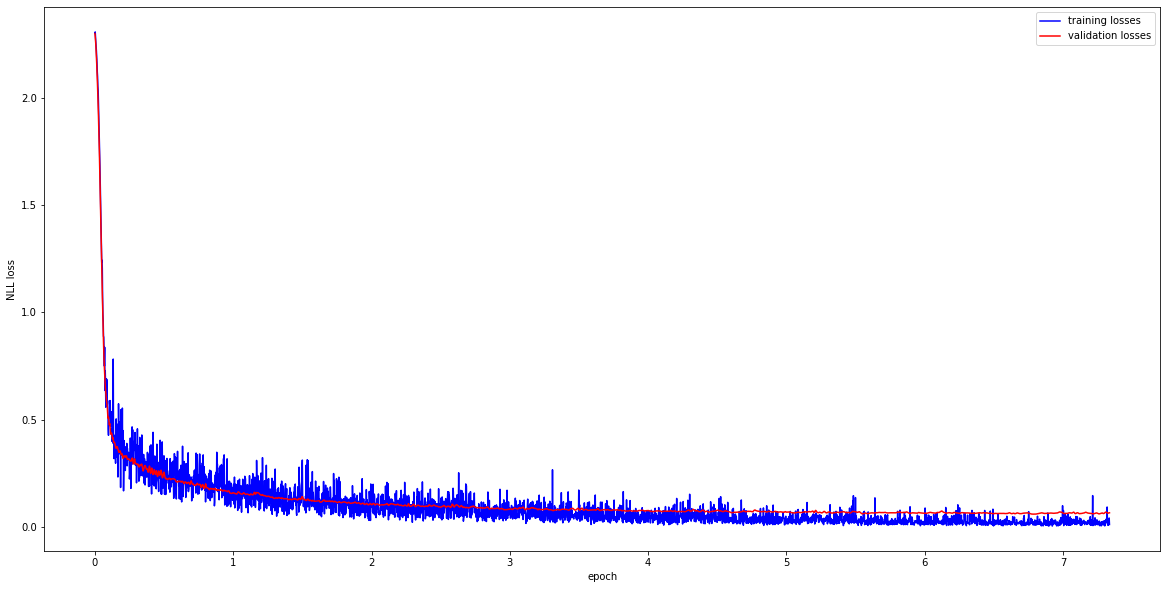

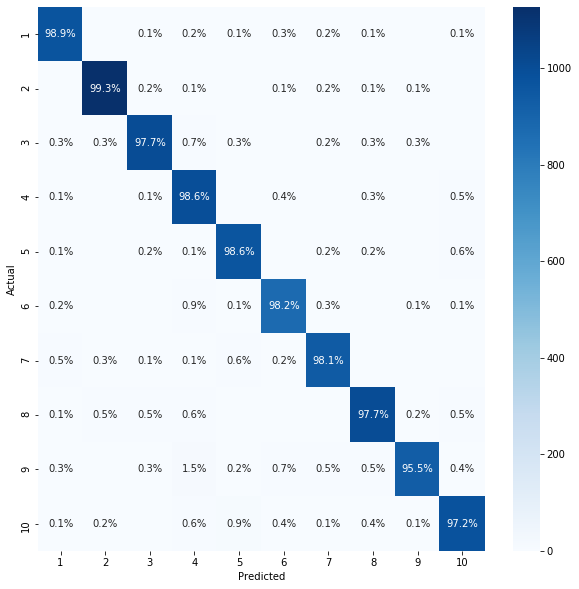

epoch  9 :  0 / 60000  (0 %)  | train loss:0.0082 | val loss:0.0676 | val acc:0.9800 | Time:1.3096
epoch  9 :  128 / 60000  (0 %)  | train loss:0.0143 | val loss:0.0663 | val acc:0.9810 | Time:2.7082
epoch  9 :  256 / 60000  (0 %)  | train loss:0.0085 | val loss:0.0652 | val acc:0.9822 | Time:4.0139
epoch  9 :  384 / 60000  (1 %)  | train loss:0.0173 | val loss:0.0635 | val acc:0.9820 | Time:5.2111
epoch  9 :  512 / 60000  (1 %)  | train loss:0.0037 | val loss:0.0625 | val acc:0.9820 | Time:6.6637
epoch  9 :  640 / 60000  (1 %)  | train loss:0.0089 | val loss:0.0619 | val acc:0.9816 | Time:8.0669
epoch  9 :  768 / 60000  (1 %)  | train loss:0.0071 | val loss:0.0617 | val acc:0.9820 | Time:9.6827
epoch  9 :  896 / 60000  (1 %)  | train loss:0.0078 | val loss:0.0617 | val acc:0.9822 | Time:11.1818
epoch  9 :  1024 / 60000  (2 %)  | train loss:0.0093 | val loss:0.0617 | val acc:0.9818 | Time:12.6671
epoch  9 :  1152 / 60000  (2 %)  | train loss:0.0130 | val loss:0.0618 | val acc:0.9816 | 

epoch  9 :  10240 / 60000  (17 %)  | train loss:0.0090 | val loss:0.0630 | val acc:0.9820 | Time:120.8287
epoch  9 :  10368 / 60000  (17 %)  | train loss:0.0074 | val loss:0.0628 | val acc:0.9820 | Time:122.0924
epoch  9 :  10496 / 60000  (17 %)  | train loss:0.0065 | val loss:0.0626 | val acc:0.9826 | Time:123.6388
epoch  9 :  10624 / 60000  (18 %)  | train loss:0.0076 | val loss:0.0623 | val acc:0.9828 | Time:124.9159
epoch  9 :  10752 / 60000  (18 %)  | train loss:0.0069 | val loss:0.0620 | val acc:0.9824 | Time:126.3838
epoch  9 :  10880 / 60000  (18 %)  | train loss:0.0121 | val loss:0.0618 | val acc:0.9826 | Time:128.0406
epoch  9 :  11008 / 60000  (18 %)  | train loss:0.0070 | val loss:0.0616 | val acc:0.9824 | Time:129.4891
epoch  9 :  11136 / 60000  (19 %)  | train loss:0.0098 | val loss:0.0613 | val acc:0.9828 | Time:130.8730
epoch  9 :  11264 / 60000  (19 %)  | train loss:0.0112 | val loss:0.0610 | val acc:0.9830 | Time:132.1817
epoch  9 :  11392 / 60000  (19 %)  | train los

epoch  9 :  20224 / 60000  (34 %)  | train loss:0.0092 | val loss:0.0652 | val acc:0.9828 | Time:227.1983
epoch  9 :  20352 / 60000  (34 %)  | train loss:0.0090 | val loss:0.0657 | val acc:0.9816 | Time:228.4119
epoch  9 :  20480 / 60000  (34 %)  | train loss:0.0067 | val loss:0.0663 | val acc:0.9814 | Time:229.7139
epoch  9 :  20608 / 60000  (34 %)  | train loss:0.0477 | val loss:0.0664 | val acc:0.9804 | Time:230.8665
epoch  9 :  20736 / 60000  (35 %)  | train loss:0.0135 | val loss:0.0666 | val acc:0.9802 | Time:232.0302
epoch  9 :  20864 / 60000  (35 %)  | train loss:0.0185 | val loss:0.0664 | val acc:0.9806 | Time:233.2338
epoch  9 :  20992 / 60000  (35 %)  | train loss:0.0041 | val loss:0.0664 | val acc:0.9804 | Time:234.5742
epoch  9 :  21120 / 60000  (35 %)  | train loss:0.0010 | val loss:0.0666 | val acc:0.9804 | Time:235.7068
epoch  9 :  21248 / 60000  (35 %)  | train loss:0.0112 | val loss:0.0667 | val acc:0.9802 | Time:236.9463
epoch  9 :  21376 / 60000  (36 %)  | train los

epoch  9 :  30208 / 60000  (50 %)  | train loss:0.1057 | val loss:0.0604 | val acc:0.9836 | Time:314.7076
epoch  9 :  30336 / 60000  (51 %)  | train loss:0.0098 | val loss:0.0603 | val acc:0.9834 | Time:315.8348
epoch  9 :  30464 / 60000  (51 %)  | train loss:0.0046 | val loss:0.0603 | val acc:0.9838 | Time:316.8981
epoch  9 :  30592 / 60000  (51 %)  | train loss:0.0065 | val loss:0.0603 | val acc:0.9838 | Time:317.9606
epoch  9 :  30720 / 60000  (51 %)  | train loss:0.0051 | val loss:0.0604 | val acc:0.9838 | Time:319.0291
epoch  9 :  30848 / 60000  (51 %)  | train loss:0.0082 | val loss:0.0604 | val acc:0.9838 | Time:320.0846
epoch  9 :  30976 / 60000  (52 %)  | train loss:0.0129 | val loss:0.0605 | val acc:0.9832 | Time:321.1351
epoch  9 :  31104 / 60000  (52 %)  | train loss:0.0416 | val loss:0.0604 | val acc:0.9828 | Time:322.3409
epoch  9 :  31232 / 60000  (52 %)  | train loss:0.0037 | val loss:0.0604 | val acc:0.9828 | Time:323.4904
epoch  9 :  31360 / 60000  (52 %)  | train los

epoch  9 :  40192 / 60000  (67 %)  | train loss:0.0130 | val loss:0.0613 | val acc:0.9830 | Time:401.2164
epoch  9 :  40320 / 60000  (67 %)  | train loss:0.0279 | val loss:0.0608 | val acc:0.9832 | Time:402.2458
epoch  9 :  40448 / 60000  (67 %)  | train loss:0.0177 | val loss:0.0605 | val acc:0.9830 | Time:403.2955
epoch  9 :  40576 / 60000  (68 %)  | train loss:0.0083 | val loss:0.0602 | val acc:0.9830 | Time:404.3455
epoch  9 :  40704 / 60000  (68 %)  | train loss:0.0121 | val loss:0.0601 | val acc:0.9826 | Time:405.4259
epoch  9 :  40832 / 60000  (68 %)  | train loss:0.0067 | val loss:0.0600 | val acc:0.9830 | Time:406.4491
epoch  9 :  40960 / 60000  (68 %)  | train loss:0.0252 | val loss:0.0601 | val acc:0.9834 | Time:407.4821
epoch  9 :  41088 / 60000  (68 %)  | train loss:0.0106 | val loss:0.0603 | val acc:0.9834 | Time:408.5358
epoch  9 :  41216 / 60000  (69 %)  | train loss:0.0069 | val loss:0.0604 | val acc:0.9836 | Time:409.5746
epoch  9 :  41344 / 60000  (69 %)  | train los

epoch  9 :  50176 / 60000  (84 %)  | train loss:0.0091 | val loss:0.0654 | val acc:0.9826 | Time:487.5811
epoch  9 :  50304 / 60000  (84 %)  | train loss:0.0131 | val loss:0.0650 | val acc:0.9826 | Time:488.6672
epoch  9 :  50432 / 60000  (84 %)  | train loss:0.0164 | val loss:0.0647 | val acc:0.9828 | Time:489.8287
epoch  9 :  50560 / 60000  (84 %)  | train loss:0.0020 | val loss:0.0646 | val acc:0.9832 | Time:490.9478
epoch  9 :  50688 / 60000  (84 %)  | train loss:0.0123 | val loss:0.0644 | val acc:0.9834 | Time:492.0404
epoch  9 :  50816 / 60000  (85 %)  | train loss:0.0145 | val loss:0.0638 | val acc:0.9838 | Time:493.1106
epoch  9 :  50944 / 60000  (85 %)  | train loss:0.0098 | val loss:0.0631 | val acc:0.9838 | Time:494.2911
epoch  9 :  51072 / 60000  (85 %)  | train loss:0.0030 | val loss:0.0626 | val acc:0.9838 | Time:495.5714
epoch  9 :  51200 / 60000  (85 %)  | train loss:0.0075 | val loss:0.0623 | val acc:0.9834 | Time:496.7306
epoch  9 :  51328 / 60000  (86 %)  | train los

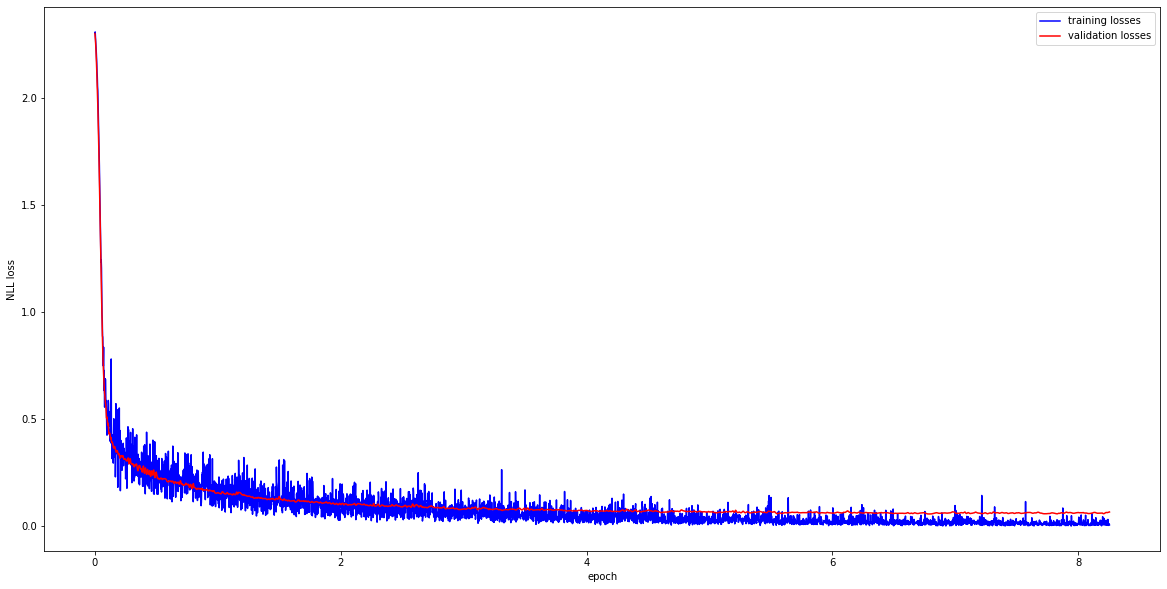

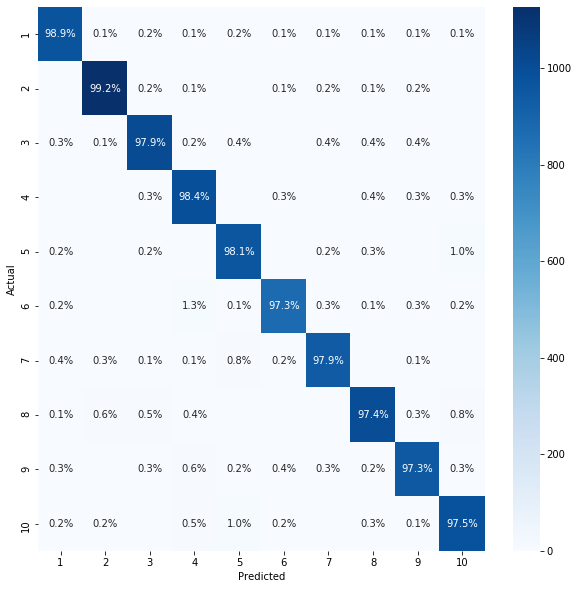

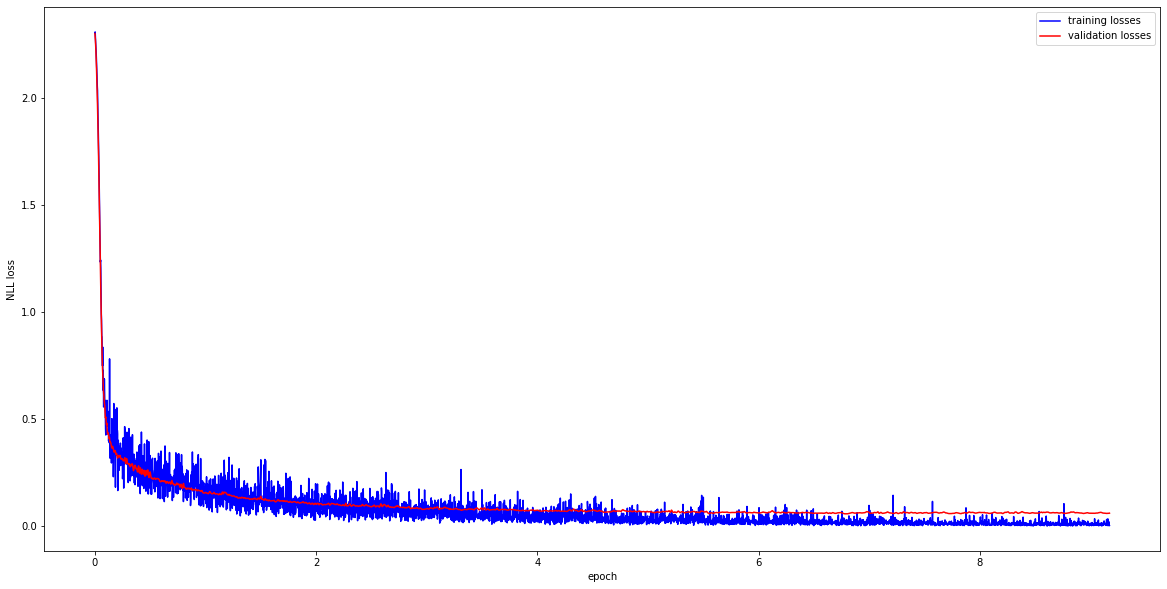

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 5
n_down = 7
p_down = 0.01

# name = 'imb-nn-784-1000-1000-10-baseline-'+str(seed)+'-'+str(n_down)+'-'+str(p_down)
name = 'nn-uam'
model = NN_UAM()
model.to(device)
# rnn.cuda()
isImbalanced = False
getMDL = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 10
train_losses = []
val_losses = []
test_acces = []
l_list = []

# training and testing
for epoch in range(EPOCH):
    if epoch == 0:
        x_history_stack=None
        COMP_stack=None
        
    train_losses, val_losses, x_history_stack, COMP_stack, used_train_size, l = train_RN(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses,x_history_stack,COMP_stack,isImbalanced=isImbalanced,getMDL=getMDL)
    test_acces, x_history_stack_test, COMP_stack_test, confusion_mtx, _ = test_RN(model, device, test_loader, test_acces,x_history_stack,COMP_stack,getMDL=getMDL)
    for bl in l:
         l_list.append(bl)
    
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')


    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])

np.save('models/'+name+'_mdl.npy',np.array(l_list))
l_nn_list = l_list

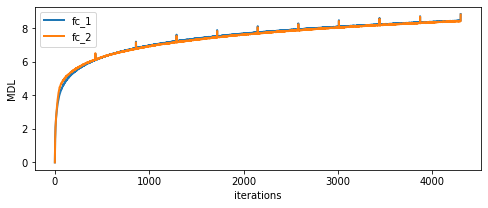

In [66]:
l_list = np.load('models/nn-uam_mdl.npy')
T = np.arange(l_list.shape[0]) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

ax.plot(T,l_list[:,1],label='fc_1',linewidth=lw)
ax.plot(T,l_list[:,2],label='fc_2',linewidth=lw)

ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()

fig.savefig('./figures/l_nn.png',layout='tight')

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 1
n_down = 1
p_down = 0.01

name = 'nnrn-uam'
model = NNRN_UAM()
model.to(device)
# rnn.cuda()
isImbalanced = False
getMDL = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 10
train_losses = []
val_losses = []
test_acces = []
l_list = []

# training and testing
for epoch in range(EPOCH):
    if epoch == 0:
        x_history_stack=None
        COMP_stack=None
        
    train_losses, val_losses, x_history_stack, COMP_stack, used_train_size, l = train_RN(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses,x_history_stack,COMP_stack,isImbalanced=isImbalanced,getMDL=getMDL)
#     test_acces, x_history_stack_test, COMP_stack_test, confusion_mtx, _ = test_RN(model, device, test_loader, test_acces,x_history_stack,COMP_stack,getMDL=getMDL)
    for bl in l:
         l_list.append(bl)
            
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
#     fig = vis_confusion(confusion_mtx, np.arange(10)+1)
#     fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')


#     plt.rcParams['figure.figsize'] = [20, 10]
#     fig, ax = plt.subplots()
#     ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
#     ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
#     ax.legend()
#     ax.set_xlabel('epoch')
#     ax.set_ylabel('NLL loss')
#     fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
#     np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])
    
np.save('models/'+name+'_mdl.npy',np.array(l_list))
l_nnrn_list = l_list

NNRN_UAM(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)
epoch  0 :  0 / 60000  (0 %)  | train loss:2.3030 | val loss:2.3141 | val acc:0.0634 | Time:1.1681
epoch  0 :  128 / 60000  (0 %)  | train loss:2.3276 | val loss:2.3113 | val acc:0.0666 | Time:2.3794
epoch  0 :  256 / 60000  (0 %)  | train loss:2.3078 | val loss:2.3042 | val acc:0.0814 | Time:3.6347
epoch  0 :  384 / 60000  (1 %)  | train loss:2.2925 | val loss:2.2934 | val acc:0.0996 | Time:4.8272
epoch  0 :  512 / 60000  (1 %)  | train loss:1.9740 | val loss:2.2797 | val acc:0.1438 | Time:6.1110
epoch  0 :  640 / 60000  (1 %)  | train loss:1.7259 | val loss:2.2651 | val acc:0.1990 | Time:7.2998
epoch  0 :  768 / 60000  (1 %)  | train loss:1.3523 | val loss:2.2536 | val acc:0.2374 | Time:8.4623
epoch  0 :  896 / 60000  (1 %)  | train loss:1.0273 | val loss:2.2461 | val acc:0.3198 | Time:

epoch  0 :  9984 / 60000  (17 %)  | train loss:0.3813 | val loss:1.9766 | val acc:0.9348 | Time:128.6034
epoch  0 :  10112 / 60000  (17 %)  | train loss:0.1934 | val loss:1.9712 | val acc:0.9310 | Time:130.5224
epoch  0 :  10240 / 60000  (17 %)  | train loss:0.2943 | val loss:1.9632 | val acc:0.9328 | Time:132.4890
epoch  0 :  10368 / 60000  (17 %)  | train loss:0.1627 | val loss:1.9555 | val acc:0.9298 | Time:134.4473
epoch  0 :  10496 / 60000  (17 %)  | train loss:0.4214 | val loss:1.9498 | val acc:0.9354 | Time:136.3878
epoch  0 :  10624 / 60000  (18 %)  | train loss:0.2062 | val loss:1.9450 | val acc:0.9318 | Time:138.2721
epoch  0 :  10752 / 60000  (18 %)  | train loss:0.4246 | val loss:1.9416 | val acc:0.9262 | Time:140.1560
epoch  0 :  10880 / 60000  (18 %)  | train loss:0.3635 | val loss:1.9364 | val acc:0.9230 | Time:142.1141
epoch  0 :  11008 / 60000  (18 %)  | train loss:0.2040 | val loss:1.9308 | val acc:0.9144 | Time:144.0268
epoch  0 :  11136 / 60000  (19 %)  | train loss

epoch  0 :  19968 / 60000  (33 %)  | train loss:0.0978 | val loss:1.4842 | val acc:0.9516 | Time:313.3184
epoch  0 :  20096 / 60000  (33 %)  | train loss:0.1706 | val loss:1.4871 | val acc:0.9518 | Time:316.1664
epoch  0 :  20224 / 60000  (34 %)  | train loss:0.1311 | val loss:1.4847 | val acc:0.9508 | Time:318.8739
epoch  0 :  20352 / 60000  (34 %)  | train loss:0.1120 | val loss:1.4769 | val acc:0.9506 | Time:321.5665
epoch  0 :  20480 / 60000  (34 %)  | train loss:0.1494 | val loss:1.4690 | val acc:0.9528 | Time:324.2041
epoch  0 :  20608 / 60000  (34 %)  | train loss:0.1417 | val loss:1.4629 | val acc:0.9552 | Time:326.9339
epoch  0 :  20736 / 60000  (35 %)  | train loss:0.1330 | val loss:1.4535 | val acc:0.9556 | Time:329.8083
epoch  0 :  20864 / 60000  (35 %)  | train loss:0.2517 | val loss:1.4513 | val acc:0.9534 | Time:332.7437
epoch  0 :  20992 / 60000  (35 %)  | train loss:0.1119 | val loss:1.4478 | val acc:0.9508 | Time:335.8208
epoch  0 :  21120 / 60000  (35 %)  | train los

KeyboardInterrupt: 

In [ ]:
l_list = np.load('models/nnrn-uam_mdl.npy')
T = np.arange(l_list.shape[0]) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

ax.plot(T,l_list[:,1],label='fc_1',linewidth=lw)
ax.plot(T,l_list[:,2],label='fc_2',linewidth=lw)

ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()

fig.savefig('./figures/l_nnrn.png',layout='tight')

RNN_UAM(
  (rnn): RNNCell(784, 100)
  (out): Linear(in_features=100, out_features=10, bias=True)
)
epoch  0 :  0 / 60000  (0 %)  | train loss:2.3904 | val loss:2.3479 | val acc:0.1150 | Time:0.9451
epoch  0 :  128 / 60000  (0 %)  | train loss:2.3340 | val loss:2.3135 | val acc:0.1308 | Time:1.8492
epoch  0 :  256 / 60000  (0 %)  | train loss:2.3145 | val loss:2.2635 | val acc:0.1546 | Time:2.7117
epoch  0 :  384 / 60000  (1 %)  | train loss:2.3202 | val loss:2.2022 | val acc:0.1992 | Time:3.6419
epoch  0 :  512 / 60000  (1 %)  | train loss:2.2007 | val loss:2.1326 | val acc:0.2600 | Time:4.4939
epoch  0 :  640 / 60000  (1 %)  | train loss:2.1911 | val loss:2.0586 | val acc:0.3320 | Time:5.3491
epoch  0 :  768 / 60000  (1 %)  | train loss:2.0510 | val loss:1.9810 | val acc:0.4036 | Time:6.2037
epoch  0 :  896 / 60000  (1 %)  | train loss:2.0072 | val loss:1.9030 | val acc:0.4656 | Time:7.0522
epoch  0 :  1024 / 60000  (2 %)  | train loss:1.9320 | val loss:1.8241 | val acc:0.5266 | Time:

epoch  0 :  10112 / 60000  (17 %)  | train loss:0.4957 | val loss:0.4268 | val acc:0.8816 | Time:78.4452
epoch  0 :  10240 / 60000  (17 %)  | train loss:0.3641 | val loss:0.4249 | val acc:0.8830 | Time:79.3645
epoch  0 :  10368 / 60000  (17 %)  | train loss:0.3806 | val loss:0.4232 | val acc:0.8836 | Time:80.2578
epoch  0 :  10496 / 60000  (17 %)  | train loss:0.4055 | val loss:0.4214 | val acc:0.8834 | Time:81.1489
epoch  0 :  10624 / 60000  (18 %)  | train loss:0.3977 | val loss:0.4199 | val acc:0.8844 | Time:82.0457
epoch  0 :  10752 / 60000  (18 %)  | train loss:0.3892 | val loss:0.4183 | val acc:0.8836 | Time:82.9570
epoch  0 :  10880 / 60000  (18 %)  | train loss:0.3654 | val loss:0.4168 | val acc:0.8834 | Time:83.8268
epoch  0 :  11008 / 60000  (18 %)  | train loss:0.4121 | val loss:0.4150 | val acc:0.8840 | Time:84.6907
epoch  0 :  11136 / 60000  (19 %)  | train loss:0.4578 | val loss:0.4133 | val acc:0.8840 | Time:85.5593
epoch  0 :  11264 / 60000  (19 %)  | train loss:0.4222 

epoch  0 :  20096 / 60000  (33 %)  | train loss:0.3701 | val loss:0.3235 | val acc:0.9074 | Time:150.3995
epoch  0 :  20224 / 60000  (34 %)  | train loss:0.3796 | val loss:0.3227 | val acc:0.9082 | Time:151.2841
epoch  0 :  20352 / 60000  (34 %)  | train loss:0.4218 | val loss:0.3218 | val acc:0.9070 | Time:152.3095
epoch  0 :  20480 / 60000  (34 %)  | train loss:0.2542 | val loss:0.3215 | val acc:0.9070 | Time:153.4493
epoch  0 :  20608 / 60000  (34 %)  | train loss:0.2978 | val loss:0.3213 | val acc:0.9088 | Time:154.4408
epoch  0 :  20736 / 60000  (35 %)  | train loss:0.3281 | val loss:0.3212 | val acc:0.9080 | Time:155.4203
epoch  0 :  20864 / 60000  (35 %)  | train loss:0.3893 | val loss:0.3217 | val acc:0.9074 | Time:156.3841
epoch  0 :  20992 / 60000  (35 %)  | train loss:0.3422 | val loss:0.3222 | val acc:0.9076 | Time:157.2840
epoch  0 :  21120 / 60000  (35 %)  | train loss:0.3377 | val loss:0.3234 | val acc:0.9082 | Time:158.1911
epoch  0 :  21248 / 60000  (35 %)  | train los

epoch  0 :  30080 / 60000  (50 %)  | train loss:0.2802 | val loss:0.2788 | val acc:0.9208 | Time:229.1638
epoch  0 :  30208 / 60000  (50 %)  | train loss:0.2860 | val loss:0.2783 | val acc:0.9216 | Time:230.0558
epoch  0 :  30336 / 60000  (51 %)  | train loss:0.1760 | val loss:0.2775 | val acc:0.9220 | Time:230.9389
epoch  0 :  30464 / 60000  (51 %)  | train loss:0.2383 | val loss:0.2765 | val acc:0.9220 | Time:231.9134
epoch  0 :  30592 / 60000  (51 %)  | train loss:0.3726 | val loss:0.2757 | val acc:0.9222 | Time:232.8477
epoch  0 :  30720 / 60000  (51 %)  | train loss:0.4026 | val loss:0.2750 | val acc:0.9218 | Time:233.7721
epoch  0 :  30848 / 60000  (51 %)  | train loss:0.3724 | val loss:0.2747 | val acc:0.9224 | Time:234.6333
epoch  0 :  30976 / 60000  (52 %)  | train loss:0.2343 | val loss:0.2745 | val acc:0.9214 | Time:235.7006
epoch  0 :  31104 / 60000  (52 %)  | train loss:0.1961 | val loss:0.2746 | val acc:0.9210 | Time:236.6700
epoch  0 :  31232 / 60000  (52 %)  | train los

epoch  0 :  40064 / 60000  (67 %)  | train loss:0.2139 | val loss:0.2463 | val acc:0.9314 | Time:306.4103
epoch  0 :  40192 / 60000  (67 %)  | train loss:0.2270 | val loss:0.2455 | val acc:0.9320 | Time:307.3252
epoch  0 :  40320 / 60000  (67 %)  | train loss:0.4081 | val loss:0.2452 | val acc:0.9324 | Time:308.2754
epoch  0 :  40448 / 60000  (67 %)  | train loss:0.2812 | val loss:0.2452 | val acc:0.9326 | Time:309.2819
epoch  0 :  40576 / 60000  (68 %)  | train loss:0.1663 | val loss:0.2453 | val acc:0.9316 | Time:310.2222
epoch  0 :  40704 / 60000  (68 %)  | train loss:0.2802 | val loss:0.2454 | val acc:0.9312 | Time:311.1307
epoch  0 :  40832 / 60000  (68 %)  | train loss:0.1900 | val loss:0.2455 | val acc:0.9306 | Time:312.0488
epoch  0 :  40960 / 60000  (68 %)  | train loss:0.2806 | val loss:0.2456 | val acc:0.9306 | Time:313.0000
epoch  0 :  41088 / 60000  (68 %)  | train loss:0.2215 | val loss:0.2457 | val acc:0.9304 | Time:313.9628
epoch  0 :  41216 / 60000  (69 %)  | train los

epoch  0 :  50048 / 60000  (83 %)  | train loss:0.2180 | val loss:0.2270 | val acc:0.9362 | Time:382.4024
epoch  0 :  50176 / 60000  (84 %)  | train loss:0.2310 | val loss:0.2264 | val acc:0.9358 | Time:383.4119
epoch  0 :  50304 / 60000  (84 %)  | train loss:0.2181 | val loss:0.2257 | val acc:0.9370 | Time:384.3782
epoch  0 :  50432 / 60000  (84 %)  | train loss:0.2335 | val loss:0.2250 | val acc:0.9380 | Time:385.4395
epoch  0 :  50560 / 60000  (84 %)  | train loss:0.2079 | val loss:0.2246 | val acc:0.9380 | Time:386.4607
epoch  0 :  50688 / 60000  (84 %)  | train loss:0.1825 | val loss:0.2245 | val acc:0.9384 | Time:387.7689
epoch  0 :  50816 / 60000  (85 %)  | train loss:0.1963 | val loss:0.2246 | val acc:0.9380 | Time:388.9714
epoch  0 :  50944 / 60000  (85 %)  | train loss:0.2497 | val loss:0.2248 | val acc:0.9378 | Time:389.9927
epoch  0 :  51072 / 60000  (85 %)  | train loss:0.2836 | val loss:0.2250 | val acc:0.9368 | Time:391.0352
epoch  0 :  51200 / 60000  (85 %)  | train los

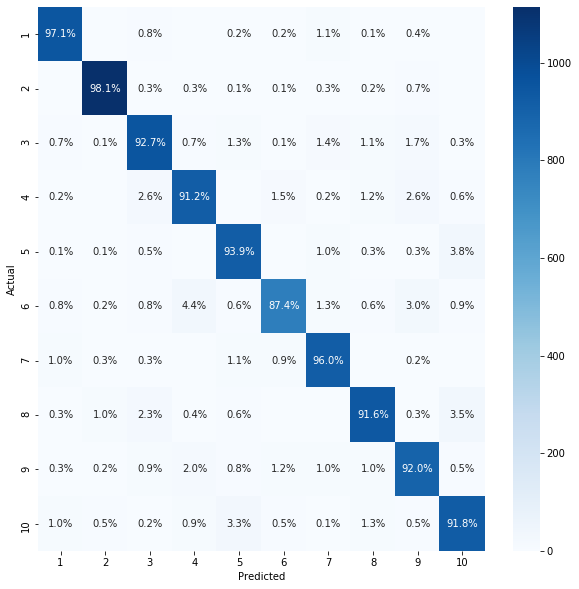

epoch  1 :  0 / 60000  (0 %)  | train loss:0.2092 | val loss:0.2190 | val acc:0.9370 | Time:0.9766
epoch  1 :  128 / 60000  (0 %)  | train loss:0.1562 | val loss:0.2188 | val acc:0.9370 | Time:2.0614
epoch  1 :  256 / 60000  (0 %)  | train loss:0.1913 | val loss:0.2186 | val acc:0.9368 | Time:3.1262
epoch  1 :  384 / 60000  (1 %)  | train loss:0.2434 | val loss:0.2184 | val acc:0.9376 | Time:4.2917
epoch  1 :  512 / 60000  (1 %)  | train loss:0.1703 | val loss:0.2183 | val acc:0.9372 | Time:5.5035
epoch  1 :  640 / 60000  (1 %)  | train loss:0.1827 | val loss:0.2178 | val acc:0.9374 | Time:6.6362
epoch  1 :  768 / 60000  (1 %)  | train loss:0.1814 | val loss:0.2174 | val acc:0.9372 | Time:7.7967
epoch  1 :  896 / 60000  (1 %)  | train loss:0.1838 | val loss:0.2171 | val acc:0.9372 | Time:8.8553
epoch  1 :  1024 / 60000  (2 %)  | train loss:0.1650 | val loss:0.2166 | val acc:0.9376 | Time:10.0921
epoch  1 :  1152 / 60000  (2 %)  | train loss:0.1873 | val loss:0.2164 | val acc:0.9372 | T

epoch  1 :  10240 / 60000  (17 %)  | train loss:0.0904 | val loss:0.2048 | val acc:0.9418 | Time:87.2887
epoch  1 :  10368 / 60000  (17 %)  | train loss:0.1366 | val loss:0.2048 | val acc:0.9420 | Time:88.2765
epoch  1 :  10496 / 60000  (17 %)  | train loss:0.1354 | val loss:0.2047 | val acc:0.9414 | Time:89.2847
epoch  1 :  10624 / 60000  (18 %)  | train loss:0.1576 | val loss:0.2045 | val acc:0.9420 | Time:90.5920
epoch  1 :  10752 / 60000  (18 %)  | train loss:0.3435 | val loss:0.2043 | val acc:0.9420 | Time:91.5333
epoch  1 :  10880 / 60000  (18 %)  | train loss:0.1773 | val loss:0.2039 | val acc:0.9426 | Time:92.5089
epoch  1 :  11008 / 60000  (18 %)  | train loss:0.2406 | val loss:0.2035 | val acc:0.9424 | Time:93.7739
epoch  1 :  11136 / 60000  (19 %)  | train loss:0.1335 | val loss:0.2029 | val acc:0.9424 | Time:94.7372
epoch  1 :  11264 / 60000  (19 %)  | train loss:0.2123 | val loss:0.2026 | val acc:0.9430 | Time:95.7051
epoch  1 :  11392 / 60000  (19 %)  | train loss:0.2205 

epoch  1 :  20224 / 60000  (34 %)  | train loss:0.1319 | val loss:0.1933 | val acc:0.9436 | Time:163.9995
epoch  1 :  20352 / 60000  (34 %)  | train loss:0.1483 | val loss:0.1934 | val acc:0.9440 | Time:164.9239
epoch  1 :  20480 / 60000  (34 %)  | train loss:0.2069 | val loss:0.1940 | val acc:0.9434 | Time:165.7957
epoch  1 :  20608 / 60000  (34 %)  | train loss:0.2193 | val loss:0.1942 | val acc:0.9430 | Time:166.6911
epoch  1 :  20736 / 60000  (35 %)  | train loss:0.2847 | val loss:0.1946 | val acc:0.9432 | Time:167.5690
epoch  1 :  20864 / 60000  (35 %)  | train loss:0.2984 | val loss:0.1947 | val acc:0.9426 | Time:168.4563
epoch  1 :  20992 / 60000  (35 %)  | train loss:0.2207 | val loss:0.1947 | val acc:0.9426 | Time:169.3522
epoch  1 :  21120 / 60000  (35 %)  | train loss:0.1749 | val loss:0.1946 | val acc:0.9426 | Time:170.2357
epoch  1 :  21248 / 60000  (35 %)  | train loss:0.1437 | val loss:0.1943 | val acc:0.9430 | Time:171.0895
epoch  1 :  21376 / 60000  (36 %)  | train los

epoch  1 :  30208 / 60000  (50 %)  | train loss:0.2861 | val loss:0.1818 | val acc:0.9476 | Time:231.5202
epoch  1 :  30336 / 60000  (51 %)  | train loss:0.1909 | val loss:0.1817 | val acc:0.9486 | Time:232.3635
epoch  1 :  30464 / 60000  (51 %)  | train loss:0.1105 | val loss:0.1816 | val acc:0.9484 | Time:233.2227
epoch  1 :  30592 / 60000  (51 %)  | train loss:0.1681 | val loss:0.1816 | val acc:0.9488 | Time:234.0720
epoch  1 :  30720 / 60000  (51 %)  | train loss:0.1674 | val loss:0.1815 | val acc:0.9490 | Time:234.9147
epoch  1 :  30848 / 60000  (51 %)  | train loss:0.2082 | val loss:0.1815 | val acc:0.9492 | Time:235.8280
epoch  1 :  30976 / 60000  (52 %)  | train loss:0.1894 | val loss:0.1814 | val acc:0.9488 | Time:236.7092
epoch  1 :  31104 / 60000  (52 %)  | train loss:0.1761 | val loss:0.1813 | val acc:0.9488 | Time:237.5684
epoch  1 :  31232 / 60000  (52 %)  | train loss:0.0685 | val loss:0.1813 | val acc:0.9486 | Time:238.4327
epoch  1 :  31360 / 60000  (52 %)  | train los

epoch  1 :  40192 / 60000  (67 %)  | train loss:0.2052 | val loss:0.1758 | val acc:0.9490 | Time:299.0576
epoch  1 :  40320 / 60000  (67 %)  | train loss:0.2017 | val loss:0.1766 | val acc:0.9490 | Time:299.9570
epoch  1 :  40448 / 60000  (67 %)  | train loss:0.2433 | val loss:0.1774 | val acc:0.9478 | Time:300.8024
epoch  1 :  40576 / 60000  (68 %)  | train loss:0.1300 | val loss:0.1778 | val acc:0.9474 | Time:301.6444
epoch  1 :  40704 / 60000  (68 %)  | train loss:0.1284 | val loss:0.1783 | val acc:0.9476 | Time:302.4961
epoch  1 :  40832 / 60000  (68 %)  | train loss:0.1662 | val loss:0.1785 | val acc:0.9478 | Time:303.3355
epoch  1 :  40960 / 60000  (68 %)  | train loss:0.2183 | val loss:0.1785 | val acc:0.9480 | Time:304.1840
epoch  1 :  41088 / 60000  (68 %)  | train loss:0.2425 | val loss:0.1780 | val acc:0.9476 | Time:305.0339
epoch  1 :  41216 / 60000  (69 %)  | train loss:0.1885 | val loss:0.1773 | val acc:0.9478 | Time:305.9206
epoch  1 :  41344 / 60000  (69 %)  | train los

epoch  1 :  50176 / 60000  (84 %)  | train loss:0.1002 | val loss:0.1702 | val acc:0.9530 | Time:368.1687
epoch  1 :  50304 / 60000  (84 %)  | train loss:0.1766 | val loss:0.1701 | val acc:0.9532 | Time:369.1538
epoch  1 :  50432 / 60000  (84 %)  | train loss:0.1668 | val loss:0.1704 | val acc:0.9536 | Time:370.1355
epoch  1 :  50560 / 60000  (84 %)  | train loss:0.1109 | val loss:0.1707 | val acc:0.9534 | Time:371.1224
epoch  1 :  50688 / 60000  (84 %)  | train loss:0.1280 | val loss:0.1710 | val acc:0.9528 | Time:372.0872
epoch  1 :  50816 / 60000  (85 %)  | train loss:0.1798 | val loss:0.1711 | val acc:0.9528 | Time:372.9882
epoch  1 :  50944 / 60000  (85 %)  | train loss:0.2069 | val loss:0.1711 | val acc:0.9522 | Time:373.8932
epoch  1 :  51072 / 60000  (85 %)  | train loss:0.0541 | val loss:0.1710 | val acc:0.9524 | Time:374.7521
epoch  1 :  51200 / 60000  (85 %)  | train loss:0.1796 | val loss:0.1709 | val acc:0.9518 | Time:375.6345
epoch  1 :  51328 / 60000  (86 %)  | train los

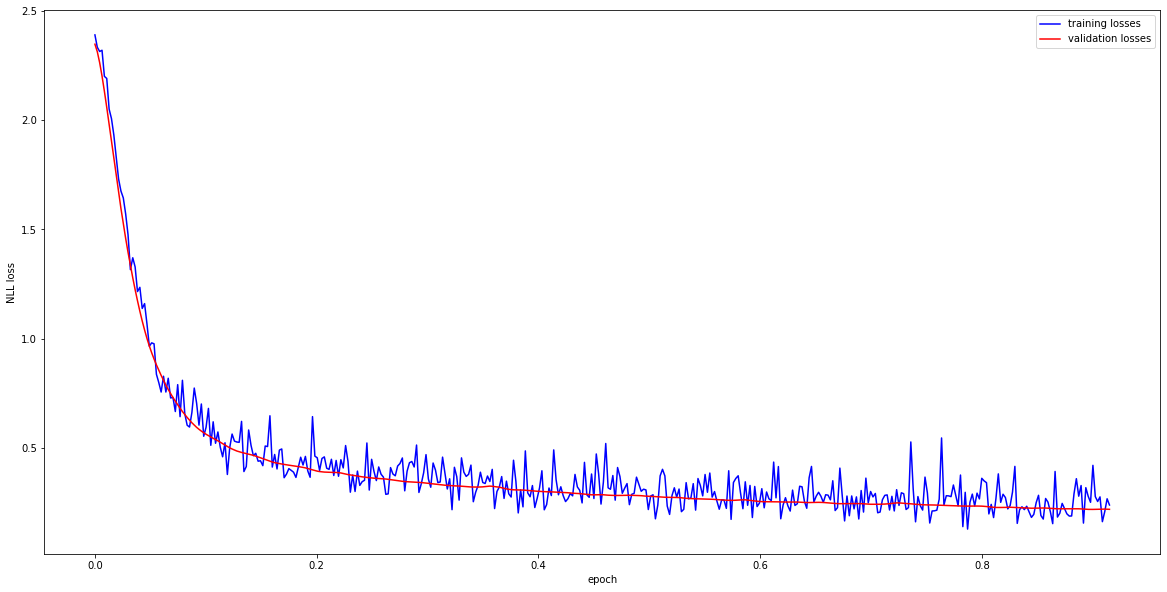

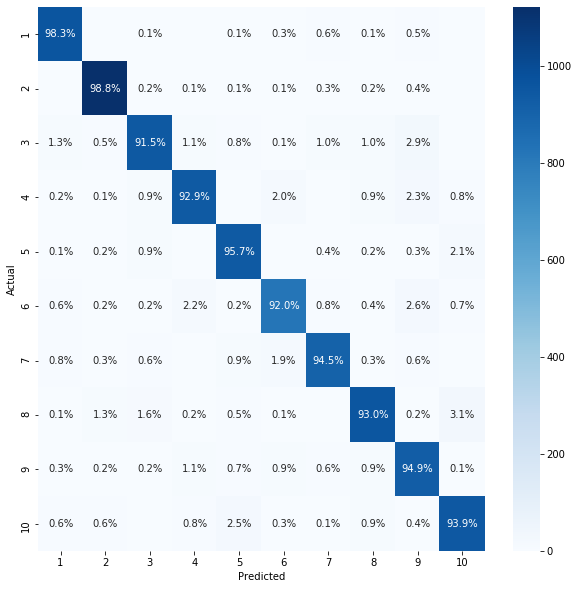

epoch  2 :  0 / 60000  (0 %)  | train loss:0.1274 | val loss:0.1688 | val acc:0.9516 | Time:0.9101
epoch  2 :  128 / 60000  (0 %)  | train loss:0.0867 | val loss:0.1693 | val acc:0.9520 | Time:1.8949
epoch  2 :  256 / 60000  (0 %)  | train loss:0.1375 | val loss:0.1698 | val acc:0.9524 | Time:2.9927
epoch  2 :  384 / 60000  (1 %)  | train loss:0.1730 | val loss:0.1696 | val acc:0.9522 | Time:3.9209
epoch  2 :  512 / 60000  (1 %)  | train loss:0.2058 | val loss:0.1690 | val acc:0.9522 | Time:4.8433
epoch  2 :  640 / 60000  (1 %)  | train loss:0.1467 | val loss:0.1680 | val acc:0.9518 | Time:5.8204
epoch  2 :  768 / 60000  (1 %)  | train loss:0.1008 | val loss:0.1670 | val acc:0.9526 | Time:6.7956
epoch  2 :  896 / 60000  (1 %)  | train loss:0.1559 | val loss:0.1660 | val acc:0.9528 | Time:7.7042
epoch  2 :  1024 / 60000  (2 %)  | train loss:0.1952 | val loss:0.1653 | val acc:0.9536 | Time:8.6168
epoch  2 :  1152 / 60000  (2 %)  | train loss:0.2418 | val loss:0.1645 | val acc:0.9532 | Ti

epoch  2 :  10240 / 60000  (17 %)  | train loss:0.1818 | val loss:0.1568 | val acc:0.9542 | Time:73.0919
epoch  2 :  10368 / 60000  (17 %)  | train loss:0.2231 | val loss:0.1567 | val acc:0.9536 | Time:73.9537
epoch  2 :  10496 / 60000  (17 %)  | train loss:0.1556 | val loss:0.1569 | val acc:0.9542 | Time:74.9214
epoch  2 :  10624 / 60000  (18 %)  | train loss:0.1221 | val loss:0.1573 | val acc:0.9550 | Time:76.0291
epoch  2 :  10752 / 60000  (18 %)  | train loss:0.2034 | val loss:0.1577 | val acc:0.9554 | Time:77.1631
epoch  2 :  10880 / 60000  (18 %)  | train loss:0.1004 | val loss:0.1579 | val acc:0.9552 | Time:78.2526
epoch  2 :  11008 / 60000  (18 %)  | train loss:0.1321 | val loss:0.1581 | val acc:0.9544 | Time:79.3292
epoch  2 :  11136 / 60000  (19 %)  | train loss:0.1851 | val loss:0.1585 | val acc:0.9546 | Time:80.3684
epoch  2 :  11264 / 60000  (19 %)  | train loss:0.1631 | val loss:0.1590 | val acc:0.9546 | Time:81.4885
epoch  2 :  11392 / 60000  (19 %)  | train loss:0.1118 

epoch  2 :  20224 / 60000  (34 %)  | train loss:0.0893 | val loss:0.1529 | val acc:0.9552 | Time:1016.0950
epoch  2 :  20352 / 60000  (34 %)  | train loss:0.1956 | val loss:0.1527 | val acc:0.9558 | Time:1016.9979
epoch  2 :  20480 / 60000  (34 %)  | train loss:0.2264 | val loss:0.1524 | val acc:0.9552 | Time:1017.9052
epoch  2 :  20608 / 60000  (34 %)  | train loss:0.2124 | val loss:0.1521 | val acc:0.9554 | Time:1018.9057
epoch  2 :  20736 / 60000  (35 %)  | train loss:0.1262 | val loss:0.1521 | val acc:0.9560 | Time:1019.9147
epoch  2 :  20864 / 60000  (35 %)  | train loss:0.1809 | val loss:0.1523 | val acc:0.9566 | Time:1020.8269
epoch  2 :  20992 / 60000  (35 %)  | train loss:0.1802 | val loss:0.1524 | val acc:0.9572 | Time:1021.7208
epoch  2 :  21120 / 60000  (35 %)  | train loss:0.1491 | val loss:0.1526 | val acc:0.9576 | Time:1022.5990
epoch  2 :  21248 / 60000  (35 %)  | train loss:0.1465 | val loss:0.1532 | val acc:0.9576 | Time:1023.4746
epoch  2 :  21376 / 60000  (36 %)  | 

epoch  2 :  30080 / 60000  (50 %)  | train loss:0.2095 | val loss:0.1526 | val acc:0.9554 | Time:1087.3739
epoch  2 :  30208 / 60000  (50 %)  | train loss:0.1310 | val loss:0.1528 | val acc:0.9550 | Time:1088.2534
epoch  2 :  30336 / 60000  (51 %)  | train loss:0.2116 | val loss:0.1532 | val acc:0.9550 | Time:1089.1115
epoch  2 :  30464 / 60000  (51 %)  | train loss:0.1624 | val loss:0.1537 | val acc:0.9544 | Time:1089.9746
epoch  2 :  30592 / 60000  (51 %)  | train loss:0.1515 | val loss:0.1537 | val acc:0.9536 | Time:1090.8401
epoch  2 :  30720 / 60000  (51 %)  | train loss:0.1466 | val loss:0.1538 | val acc:0.9538 | Time:1091.7028
epoch  2 :  30848 / 60000  (51 %)  | train loss:0.1337 | val loss:0.1540 | val acc:0.9546 | Time:1092.5613
epoch  2 :  30976 / 60000  (52 %)  | train loss:0.1923 | val loss:0.1539 | val acc:0.9554 | Time:1093.4477
epoch  2 :  31104 / 60000  (52 %)  | train loss:0.1729 | val loss:0.1534 | val acc:0.9556 | Time:1094.3509
epoch  2 :  31232 / 60000  (52 %)  | 

epoch  2 :  39936 / 60000  (67 %)  | train loss:0.1694 | val loss:0.1467 | val acc:0.9586 | Time:1154.1200
epoch  2 :  40064 / 60000  (67 %)  | train loss:0.1414 | val loss:0.1470 | val acc:0.9588 | Time:1154.9935
epoch  2 :  40192 / 60000  (67 %)  | train loss:0.1267 | val loss:0.1470 | val acc:0.9588 | Time:1155.8541
epoch  2 :  40320 / 60000  (67 %)  | train loss:0.0985 | val loss:0.1471 | val acc:0.9590 | Time:1156.7096
epoch  2 :  40448 / 60000  (67 %)  | train loss:0.0901 | val loss:0.1470 | val acc:0.9586 | Time:1157.5589
epoch  2 :  40576 / 60000  (68 %)  | train loss:0.1407 | val loss:0.1468 | val acc:0.9584 | Time:1158.4530
epoch  2 :  40704 / 60000  (68 %)  | train loss:0.0997 | val loss:0.1464 | val acc:0.9578 | Time:1159.3031
epoch  2 :  40832 / 60000  (68 %)  | train loss:0.2295 | val loss:0.1462 | val acc:0.9588 | Time:1160.2196
epoch  2 :  40960 / 60000  (68 %)  | train loss:0.1707 | val loss:0.1461 | val acc:0.9588 | Time:1161.1753
epoch  2 :  41088 / 60000  (68 %)  | 

epoch  2 :  49792 / 60000  (83 %)  | train loss:0.0399 | val loss:0.1428 | val acc:0.9598 | Time:1221.1174
epoch  2 :  49920 / 60000  (83 %)  | train loss:0.1702 | val loss:0.1427 | val acc:0.9602 | Time:1222.0329
epoch  2 :  50048 / 60000  (83 %)  | train loss:0.0613 | val loss:0.1424 | val acc:0.9600 | Time:1222.8857
epoch  2 :  50176 / 60000  (84 %)  | train loss:0.1727 | val loss:0.1422 | val acc:0.9602 | Time:1223.7450
epoch  2 :  50304 / 60000  (84 %)  | train loss:0.1900 | val loss:0.1422 | val acc:0.9608 | Time:1224.6118
epoch  2 :  50432 / 60000  (84 %)  | train loss:0.1059 | val loss:0.1421 | val acc:0.9610 | Time:1225.4717
epoch  2 :  50560 / 60000  (84 %)  | train loss:0.1691 | val loss:0.1420 | val acc:0.9606 | Time:1226.3292
epoch  2 :  50688 / 60000  (84 %)  | train loss:0.1289 | val loss:0.1417 | val acc:0.9608 | Time:1227.1848
epoch  2 :  50816 / 60000  (85 %)  | train loss:0.0841 | val loss:0.1415 | val acc:0.9608 | Time:1228.0432
epoch  2 :  50944 / 60000  (85 %)  | 

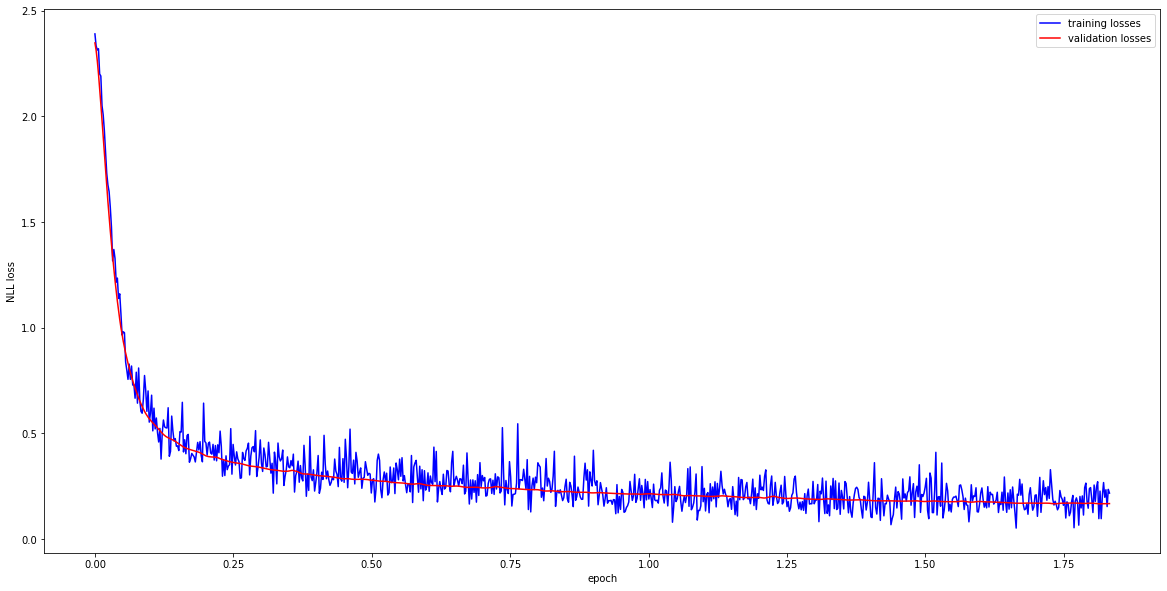

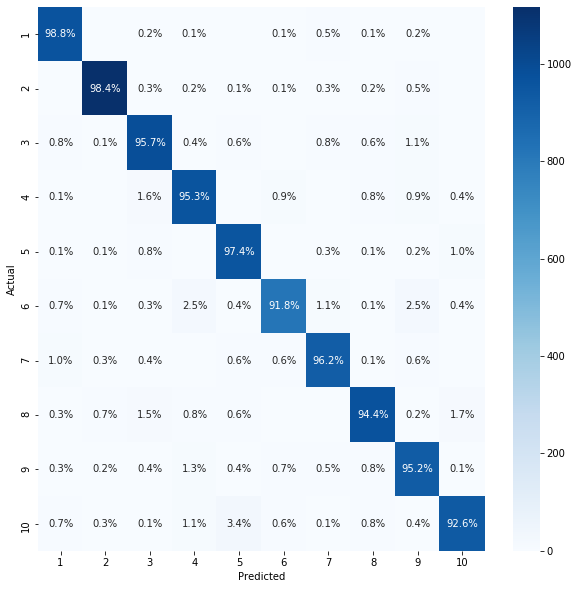

epoch  3 :  0 / 60000  (0 %)  | train loss:0.0857 | val loss:0.1393 | val acc:0.9614 | Time:0.9765
epoch  3 :  128 / 60000  (0 %)  | train loss:0.1233 | val loss:0.1390 | val acc:0.9614 | Time:1.8915
epoch  3 :  256 / 60000  (0 %)  | train loss:0.0869 | val loss:0.1388 | val acc:0.9608 | Time:2.8121
epoch  3 :  384 / 60000  (1 %)  | train loss:0.1381 | val loss:0.1386 | val acc:0.9612 | Time:3.6783
epoch  3 :  512 / 60000  (1 %)  | train loss:0.0698 | val loss:0.1384 | val acc:0.9608 | Time:4.5267
epoch  3 :  640 / 60000  (1 %)  | train loss:0.0892 | val loss:0.1383 | val acc:0.9612 | Time:5.3828
epoch  3 :  768 / 60000  (1 %)  | train loss:0.0775 | val loss:0.1381 | val acc:0.9614 | Time:6.2228
epoch  3 :  896 / 60000  (1 %)  | train loss:0.1015 | val loss:0.1379 | val acc:0.9614 | Time:7.0766
epoch  3 :  1024 / 60000  (2 %)  | train loss:0.1077 | val loss:0.1379 | val acc:0.9616 | Time:7.9601
epoch  3 :  1152 / 60000  (2 %)  | train loss:0.0884 | val loss:0.1378 | val acc:0.9614 | Ti

epoch  3 :  10240 / 60000  (17 %)  | train loss:0.1892 | val loss:0.1380 | val acc:0.9614 | Time:71.6237
epoch  3 :  10368 / 60000  (17 %)  | train loss:0.1924 | val loss:0.1382 | val acc:0.9612 | Time:72.4735
epoch  3 :  10496 / 60000  (17 %)  | train loss:0.0888 | val loss:0.1384 | val acc:0.9614 | Time:73.3755
epoch  3 :  10624 / 60000  (18 %)  | train loss:0.1301 | val loss:0.1384 | val acc:0.9614 | Time:74.2272
epoch  3 :  10752 / 60000  (18 %)  | train loss:0.1896 | val loss:0.1386 | val acc:0.9612 | Time:75.0916
epoch  3 :  10880 / 60000  (18 %)  | train loss:0.1087 | val loss:0.1391 | val acc:0.9610 | Time:75.9593
epoch  3 :  11008 / 60000  (18 %)  | train loss:0.1560 | val loss:0.1388 | val acc:0.9610 | Time:76.8250
epoch  3 :  11136 / 60000  (19 %)  | train loss:0.1606 | val loss:0.1387 | val acc:0.9612 | Time:77.6788
epoch  3 :  11264 / 60000  (19 %)  | train loss:0.1389 | val loss:0.1383 | val acc:0.9612 | Time:78.5246
epoch  3 :  11392 / 60000  (19 %)  | train loss:0.1325 

epoch  3 :  20224 / 60000  (34 %)  | train loss:0.1390 | val loss:0.1336 | val acc:0.9630 | Time:139.6099
epoch  3 :  20352 / 60000  (34 %)  | train loss:0.0779 | val loss:0.1328 | val acc:0.9634 | Time:140.4658
epoch  3 :  20480 / 60000  (34 %)  | train loss:0.1246 | val loss:0.1324 | val acc:0.9634 | Time:141.3145
epoch  3 :  20608 / 60000  (34 %)  | train loss:0.1915 | val loss:0.1323 | val acc:0.9632 | Time:142.1616
epoch  3 :  20736 / 60000  (35 %)  | train loss:0.1151 | val loss:0.1324 | val acc:0.9630 | Time:143.0136
epoch  3 :  20864 / 60000  (35 %)  | train loss:0.1093 | val loss:0.1327 | val acc:0.9626 | Time:143.9078
epoch  3 :  20992 / 60000  (35 %)  | train loss:0.1637 | val loss:0.1332 | val acc:0.9620 | Time:144.7602
epoch  3 :  21120 / 60000  (35 %)  | train loss:0.0939 | val loss:0.1335 | val acc:0.9624 | Time:145.6195
epoch  3 :  21248 / 60000  (35 %)  | train loss:0.1357 | val loss:0.1334 | val acc:0.9628 | Time:146.4683
epoch  3 :  21376 / 60000  (36 %)  | train los

epoch  3 :  30208 / 60000  (50 %)  | train loss:0.0548 | val loss:0.1357 | val acc:0.9598 | Time:206.3779
epoch  3 :  30336 / 60000  (51 %)  | train loss:0.0358 | val loss:0.1357 | val acc:0.9602 | Time:207.2727
epoch  3 :  30464 / 60000  (51 %)  | train loss:0.0963 | val loss:0.1355 | val acc:0.9600 | Time:208.1086
epoch  3 :  30592 / 60000  (51 %)  | train loss:0.0545 | val loss:0.1355 | val acc:0.9602 | Time:208.9531
epoch  3 :  30720 / 60000  (51 %)  | train loss:0.2173 | val loss:0.1351 | val acc:0.9606 | Time:209.7958
epoch  3 :  30848 / 60000  (51 %)  | train loss:0.1202 | val loss:0.1348 | val acc:0.9608 | Time:210.6510
epoch  3 :  30976 / 60000  (52 %)  | train loss:0.0952 | val loss:0.1347 | val acc:0.9612 | Time:211.5097
epoch  3 :  31104 / 60000  (52 %)  | train loss:0.1448 | val loss:0.1347 | val acc:0.9616 | Time:212.3890
epoch  3 :  31232 / 60000  (52 %)  | train loss:0.2156 | val loss:0.1349 | val acc:0.9616 | Time:213.2891
epoch  3 :  31360 / 60000  (52 %)  | train los

epoch  3 :  40192 / 60000  (67 %)  | train loss:0.0686 | val loss:0.1310 | val acc:0.9604 | Time:273.0853
epoch  3 :  40320 / 60000  (67 %)  | train loss:0.0331 | val loss:0.1317 | val acc:0.9602 | Time:273.9295
epoch  3 :  40448 / 60000  (67 %)  | train loss:0.1147 | val loss:0.1322 | val acc:0.9596 | Time:274.7780
epoch  3 :  40576 / 60000  (68 %)  | train loss:0.1238 | val loss:0.1330 | val acc:0.9592 | Time:275.6262
epoch  3 :  40704 / 60000  (68 %)  | train loss:0.0756 | val loss:0.1340 | val acc:0.9580 | Time:276.5287
epoch  3 :  40832 / 60000  (68 %)  | train loss:0.1165 | val loss:0.1343 | val acc:0.9578 | Time:277.3636
epoch  3 :  40960 / 60000  (68 %)  | train loss:0.1389 | val loss:0.1339 | val acc:0.9582 | Time:278.2044
epoch  3 :  41088 / 60000  (68 %)  | train loss:0.0971 | val loss:0.1337 | val acc:0.9578 | Time:279.0443
epoch  3 :  41216 / 60000  (69 %)  | train loss:0.0768 | val loss:0.1330 | val acc:0.9582 | Time:279.9020
epoch  3 :  41344 / 60000  (69 %)  | train los

epoch  3 :  50176 / 60000  (84 %)  | train loss:0.1396 | val loss:0.1266 | val acc:0.9642 | Time:339.7711
epoch  3 :  50304 / 60000  (84 %)  | train loss:0.0915 | val loss:0.1269 | val acc:0.9642 | Time:340.6246
epoch  3 :  50432 / 60000  (84 %)  | train loss:0.1408 | val loss:0.1271 | val acc:0.9638 | Time:341.4634
epoch  3 :  50560 / 60000  (84 %)  | train loss:0.0999 | val loss:0.1270 | val acc:0.9636 | Time:342.3214
epoch  3 :  50688 / 60000  (84 %)  | train loss:0.0938 | val loss:0.1270 | val acc:0.9638 | Time:343.1571
epoch  3 :  50816 / 60000  (85 %)  | train loss:0.0875 | val loss:0.1267 | val acc:0.9640 | Time:344.0049
epoch  3 :  50944 / 60000  (85 %)  | train loss:0.1562 | val loss:0.1264 | val acc:0.9638 | Time:344.8545
epoch  3 :  51072 / 60000  (85 %)  | train loss:0.1153 | val loss:0.1260 | val acc:0.9642 | Time:345.7559
epoch  3 :  51200 / 60000  (85 %)  | train loss:0.1391 | val loss:0.1255 | val acc:0.9644 | Time:346.6019
epoch  3 :  51328 / 60000  (86 %)  | train los

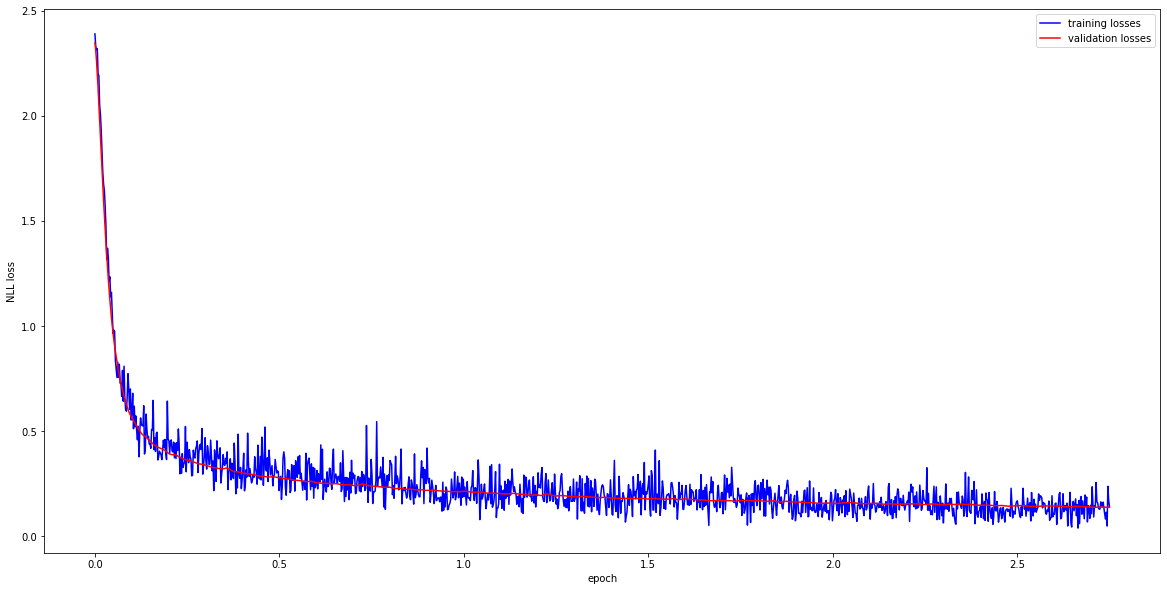

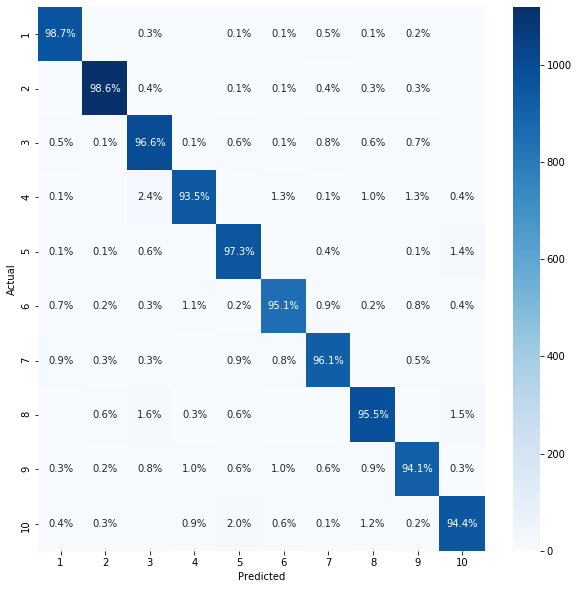

epoch  4 :  0 / 60000  (0 %)  | train loss:0.0945 | val loss:0.1245 | val acc:0.9638 | Time:0.9577
epoch  4 :  128 / 60000  (0 %)  | train loss:0.0950 | val loss:0.1252 | val acc:0.9628 | Time:1.9006
epoch  4 :  256 / 60000  (0 %)  | train loss:0.1007 | val loss:0.1258 | val acc:0.9626 | Time:2.8535
epoch  4 :  384 / 60000  (1 %)  | train loss:0.1500 | val loss:0.1261 | val acc:0.9628 | Time:3.7742
epoch  4 :  512 / 60000  (1 %)  | train loss:0.0817 | val loss:0.1263 | val acc:0.9630 | Time:4.6421
epoch  4 :  640 / 60000  (1 %)  | train loss:0.0738 | val loss:0.1263 | val acc:0.9634 | Time:5.6647
epoch  4 :  768 / 60000  (1 %)  | train loss:0.0642 | val loss:0.1262 | val acc:0.9636 | Time:6.5273
epoch  4 :  896 / 60000  (1 %)  | train loss:0.1387 | val loss:0.1252 | val acc:0.9642 | Time:7.3910
epoch  4 :  1024 / 60000  (2 %)  | train loss:0.1136 | val loss:0.1244 | val acc:0.9646 | Time:8.2424
epoch  4 :  1152 / 60000  (2 %)  | train loss:0.1018 | val loss:0.1238 | val acc:0.9650 | Ti

epoch  4 :  10240 / 60000  (17 %)  | train loss:0.1469 | val loss:0.1230 | val acc:0.9644 | Time:70.0900
epoch  4 :  10368 / 60000  (17 %)  | train loss:0.0650 | val loss:0.1228 | val acc:0.9642 | Time:70.9470
epoch  4 :  10496 / 60000  (17 %)  | train loss:0.0462 | val loss:0.1226 | val acc:0.9642 | Time:71.7864
epoch  4 :  10624 / 60000  (18 %)  | train loss:0.0474 | val loss:0.1224 | val acc:0.9644 | Time:72.6300
epoch  4 :  10752 / 60000  (18 %)  | train loss:0.0817 | val loss:0.1222 | val acc:0.9650 | Time:73.5289
epoch  4 :  10880 / 60000  (18 %)  | train loss:0.0626 | val loss:0.1220 | val acc:0.9654 | Time:74.3784
epoch  4 :  11008 / 60000  (18 %)  | train loss:0.0812 | val loss:0.1218 | val acc:0.9656 | Time:75.2112
epoch  4 :  11136 / 60000  (19 %)  | train loss:0.1397 | val loss:0.1218 | val acc:0.9654 | Time:76.0639
epoch  4 :  11264 / 60000  (19 %)  | train loss:0.0594 | val loss:0.1218 | val acc:0.9654 | Time:76.9085
epoch  4 :  11392 / 60000  (19 %)  | train loss:0.0720 

epoch  4 :  20224 / 60000  (34 %)  | train loss:0.1199 | val loss:0.1226 | val acc:0.9638 | Time:136.9045
epoch  4 :  20352 / 60000  (34 %)  | train loss:0.1226 | val loss:0.1223 | val acc:0.9640 | Time:137.7490
epoch  4 :  20480 / 60000  (34 %)  | train loss:0.1422 | val loss:0.1220 | val acc:0.9634 | Time:138.5899
epoch  4 :  20608 / 60000  (34 %)  | train loss:0.0740 | val loss:0.1218 | val acc:0.9634 | Time:139.4302
epoch  4 :  20736 / 60000  (35 %)  | train loss:0.0671 | val loss:0.1216 | val acc:0.9632 | Time:140.2713
epoch  4 :  20864 / 60000  (35 %)  | train loss:0.0590 | val loss:0.1212 | val acc:0.9636 | Time:141.1137
epoch  4 :  20992 / 60000  (35 %)  | train loss:0.0552 | val loss:0.1208 | val acc:0.9638 | Time:141.9521
epoch  4 :  21120 / 60000  (35 %)  | train loss:0.1664 | val loss:0.1202 | val acc:0.9640 | Time:142.8403
epoch  4 :  21248 / 60000  (35 %)  | train loss:0.0862 | val loss:0.1197 | val acc:0.9636 | Time:143.6919
epoch  4 :  21376 / 60000  (36 %)  | train los

epoch  4 :  30208 / 60000  (50 %)  | train loss:0.1046 | val loss:0.1177 | val acc:0.9674 | Time:203.4183
epoch  4 :  30336 / 60000  (51 %)  | train loss:0.1068 | val loss:0.1179 | val acc:0.9666 | Time:204.2631
epoch  4 :  30464 / 60000  (51 %)  | train loss:0.1139 | val loss:0.1181 | val acc:0.9672 | Time:205.0988
epoch  4 :  30592 / 60000  (51 %)  | train loss:0.1453 | val loss:0.1183 | val acc:0.9666 | Time:206.0163
epoch  4 :  30720 / 60000  (51 %)  | train loss:0.0962 | val loss:0.1183 | val acc:0.9662 | Time:206.8553
epoch  4 :  30848 / 60000  (51 %)  | train loss:0.0456 | val loss:0.1184 | val acc:0.9662 | Time:207.7047
epoch  4 :  30976 / 60000  (52 %)  | train loss:0.0888 | val loss:0.1184 | val acc:0.9656 | Time:208.5445
epoch  4 :  31104 / 60000  (52 %)  | train loss:0.0714 | val loss:0.1186 | val acc:0.9660 | Time:209.3908
epoch  4 :  31232 / 60000  (52 %)  | train loss:0.0531 | val loss:0.1186 | val acc:0.9654 | Time:210.2385
epoch  4 :  31360 / 60000  (52 %)  | train los

epoch  4 :  40192 / 60000  (67 %)  | train loss:0.0912 | val loss:0.1180 | val acc:0.9652 | Time:270.2958
epoch  4 :  40320 / 60000  (67 %)  | train loss:0.0565 | val loss:0.1180 | val acc:0.9646 | Time:271.1508
epoch  4 :  40448 / 60000  (67 %)  | train loss:0.0899 | val loss:0.1179 | val acc:0.9648 | Time:272.1224
epoch  4 :  40576 / 60000  (68 %)  | train loss:0.0794 | val loss:0.1176 | val acc:0.9644 | Time:272.9686
epoch  4 :  40704 / 60000  (68 %)  | train loss:0.1230 | val loss:0.1173 | val acc:0.9644 | Time:273.8169
epoch  4 :  40832 / 60000  (68 %)  | train loss:0.1042 | val loss:0.1169 | val acc:0.9642 | Time:274.6656
epoch  4 :  40960 / 60000  (68 %)  | train loss:0.0837 | val loss:0.1166 | val acc:0.9648 | Time:275.5767
epoch  4 :  41088 / 60000  (68 %)  | train loss:0.0440 | val loss:0.1164 | val acc:0.9646 | Time:276.4504
epoch  4 :  41216 / 60000  (69 %)  | train loss:0.1744 | val loss:0.1162 | val acc:0.9642 | Time:277.3181
epoch  4 :  41344 / 60000  (69 %)  | train los

epoch  4 :  50176 / 60000  (84 %)  | train loss:0.1681 | val loss:0.1180 | val acc:0.9650 | Time:339.5753
epoch  4 :  50304 / 60000  (84 %)  | train loss:0.0864 | val loss:0.1179 | val acc:0.9654 | Time:340.4185
epoch  4 :  50432 / 60000  (84 %)  | train loss:0.0693 | val loss:0.1175 | val acc:0.9652 | Time:341.3309
epoch  4 :  50560 / 60000  (84 %)  | train loss:0.1267 | val loss:0.1170 | val acc:0.9656 | Time:342.1683
epoch  4 :  50688 / 60000  (84 %)  | train loss:0.1606 | val loss:0.1161 | val acc:0.9658 | Time:343.0174
epoch  4 :  50816 / 60000  (85 %)  | train loss:0.0751 | val loss:0.1154 | val acc:0.9662 | Time:343.8576
epoch  4 :  50944 / 60000  (85 %)  | train loss:0.0836 | val loss:0.1149 | val acc:0.9662 | Time:344.7068
epoch  4 :  51072 / 60000  (85 %)  | train loss:0.0649 | val loss:0.1146 | val acc:0.9660 | Time:345.5477
epoch  4 :  51200 / 60000  (85 %)  | train loss:0.0873 | val loss:0.1145 | val acc:0.9664 | Time:346.3936
epoch  4 :  51328 / 60000  (86 %)  | train los

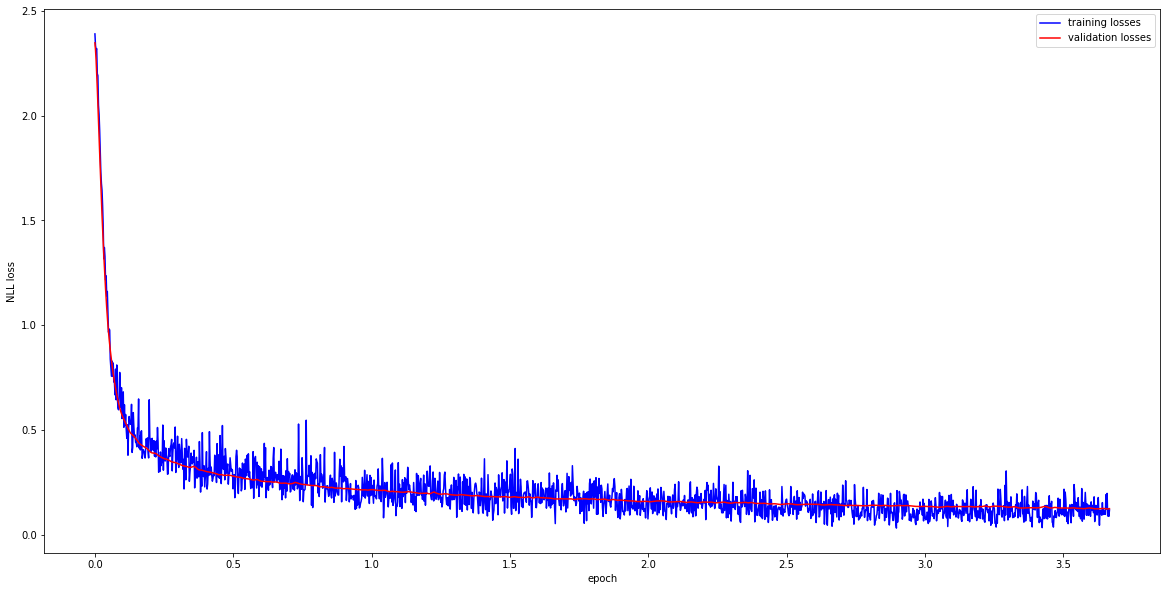

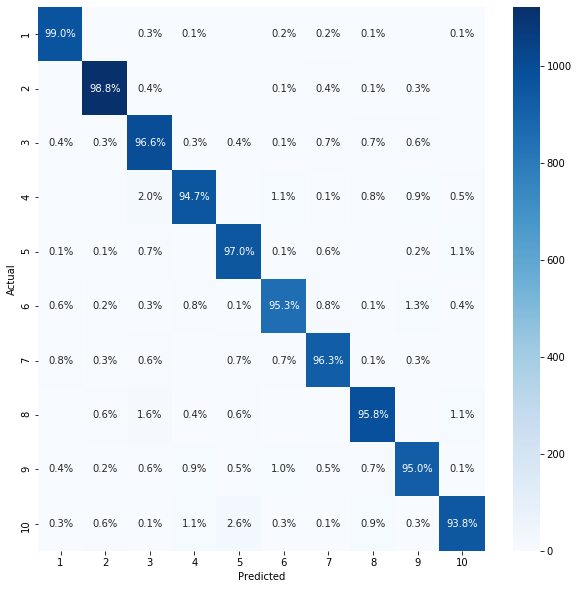

epoch  5 :  0 / 60000  (0 %)  | train loss:0.1571 | val loss:0.1148 | val acc:0.9678 | Time:0.8606
epoch  5 :  128 / 60000  (0 %)  | train loss:0.0404 | val loss:0.1150 | val acc:0.9670 | Time:1.7345
epoch  5 :  256 / 60000  (0 %)  | train loss:0.0939 | val loss:0.1155 | val acc:0.9670 | Time:2.5814
epoch  5 :  384 / 60000  (1 %)  | train loss:0.0371 | val loss:0.1160 | val acc:0.9668 | Time:3.4522
epoch  5 :  512 / 60000  (1 %)  | train loss:0.0646 | val loss:0.1164 | val acc:0.9668 | Time:4.3709
epoch  5 :  640 / 60000  (1 %)  | train loss:0.0579 | val loss:0.1166 | val acc:0.9668 | Time:5.3367
epoch  5 :  768 / 60000  (1 %)  | train loss:0.0244 | val loss:0.1167 | val acc:0.9666 | Time:6.5014
epoch  5 :  896 / 60000  (1 %)  | train loss:0.1025 | val loss:0.1165 | val acc:0.9664 | Time:7.4291
epoch  5 :  1024 / 60000  (2 %)  | train loss:0.1100 | val loss:0.1158 | val acc:0.9666 | Time:8.3556
epoch  5 :  1152 / 60000  (2 %)  | train loss:0.0969 | val loss:0.1151 | val acc:0.9668 | Ti

epoch  5 :  10240 / 60000  (17 %)  | train loss:0.0338 | val loss:0.1138 | val acc:0.9670 | Time:70.2741
epoch  5 :  10368 / 60000  (17 %)  | train loss:0.1033 | val loss:0.1146 | val acc:0.9672 | Time:71.1156
epoch  5 :  10496 / 60000  (17 %)  | train loss:0.1630 | val loss:0.1150 | val acc:0.9668 | Time:71.9589
epoch  5 :  10624 / 60000  (18 %)  | train loss:0.1028 | val loss:0.1156 | val acc:0.9666 | Time:72.8050
epoch  5 :  10752 / 60000  (18 %)  | train loss:0.0513 | val loss:0.1160 | val acc:0.9666 | Time:73.6515
epoch  5 :  10880 / 60000  (18 %)  | train loss:0.0718 | val loss:0.1161 | val acc:0.9670 | Time:74.4970
epoch  5 :  11008 / 60000  (18 %)  | train loss:0.1275 | val loss:0.1157 | val acc:0.9670 | Time:75.3919
epoch  5 :  11136 / 60000  (19 %)  | train loss:0.0607 | val loss:0.1155 | val acc:0.9664 | Time:76.2403
epoch  5 :  11264 / 60000  (19 %)  | train loss:0.0648 | val loss:0.1153 | val acc:0.9666 | Time:77.0892
epoch  5 :  11392 / 60000  (19 %)  | train loss:0.0623 

epoch  5 :  20224 / 60000  (34 %)  | train loss:0.1466 | val loss:0.1158 | val acc:0.9660 | Time:137.1990
epoch  5 :  20352 / 60000  (34 %)  | train loss:0.0321 | val loss:0.1157 | val acc:0.9664 | Time:138.0463
epoch  5 :  20480 / 60000  (34 %)  | train loss:0.1021 | val loss:0.1154 | val acc:0.9664 | Time:138.9434
epoch  5 :  20608 / 60000  (34 %)  | train loss:0.0378 | val loss:0.1153 | val acc:0.9664 | Time:139.7847
epoch  5 :  20736 / 60000  (35 %)  | train loss:0.0551 | val loss:0.1152 | val acc:0.9668 | Time:140.6246
epoch  5 :  20864 / 60000  (35 %)  | train loss:0.0572 | val loss:0.1152 | val acc:0.9660 | Time:141.4718
epoch  5 :  20992 / 60000  (35 %)  | train loss:0.0734 | val loss:0.1153 | val acc:0.9662 | Time:142.3438
epoch  5 :  21120 / 60000  (35 %)  | train loss:0.0459 | val loss:0.1153 | val acc:0.9664 | Time:143.1952
epoch  5 :  21248 / 60000  (35 %)  | train loss:0.0634 | val loss:0.1152 | val acc:0.9658 | Time:144.0402
epoch  5 :  21376 / 60000  (36 %)  | train los

epoch  5 :  30208 / 60000  (50 %)  | train loss:0.0687 | val loss:0.1119 | val acc:0.9670 | Time:204.3983
epoch  5 :  30336 / 60000  (51 %)  | train loss:0.1208 | val loss:0.1115 | val acc:0.9670 | Time:205.2582
epoch  5 :  30464 / 60000  (51 %)  | train loss:0.1507 | val loss:0.1109 | val acc:0.9668 | Time:206.1218
epoch  5 :  30592 / 60000  (51 %)  | train loss:0.0573 | val loss:0.1106 | val acc:0.9662 | Time:206.9918
epoch  5 :  30720 / 60000  (51 %)  | train loss:0.0944 | val loss:0.1103 | val acc:0.9664 | Time:207.8741
epoch  5 :  30848 / 60000  (51 %)  | train loss:0.0460 | val loss:0.1101 | val acc:0.9664 | Time:208.8005
epoch  5 :  30976 / 60000  (52 %)  | train loss:0.1854 | val loss:0.1099 | val acc:0.9662 | Time:209.6711
epoch  5 :  31104 / 60000  (52 %)  | train loss:0.0925 | val loss:0.1099 | val acc:0.9668 | Time:210.5302
epoch  5 :  31232 / 60000  (52 %)  | train loss:0.0461 | val loss:0.1097 | val acc:0.9676 | Time:211.4560
epoch  5 :  31360 / 60000  (52 %)  | train los

epoch  5 :  40192 / 60000  (67 %)  | train loss:0.0736 | val loss:0.1113 | val acc:0.9672 | Time:272.1158
epoch  5 :  40320 / 60000  (67 %)  | train loss:0.0314 | val loss:0.1113 | val acc:0.9674 | Time:273.0316
epoch  5 :  40448 / 60000  (67 %)  | train loss:0.0777 | val loss:0.1113 | val acc:0.9678 | Time:273.8831
epoch  5 :  40576 / 60000  (68 %)  | train loss:0.0656 | val loss:0.1114 | val acc:0.9676 | Time:274.7277
epoch  5 :  40704 / 60000  (68 %)  | train loss:0.0829 | val loss:0.1116 | val acc:0.9672 | Time:275.5757
epoch  5 :  40832 / 60000  (68 %)  | train loss:0.0383 | val loss:0.1119 | val acc:0.9666 | Time:276.4189
epoch  5 :  40960 / 60000  (68 %)  | train loss:0.1523 | val loss:0.1121 | val acc:0.9666 | Time:277.2662
epoch  5 :  41088 / 60000  (68 %)  | train loss:0.0963 | val loss:0.1125 | val acc:0.9666 | Time:278.1141
epoch  5 :  41216 / 60000  (69 %)  | train loss:0.0736 | val loss:0.1127 | val acc:0.9668 | Time:279.0158
epoch  5 :  41344 / 60000  (69 %)  | train los

epoch  5 :  50176 / 60000  (84 %)  | train loss:0.1431 | val loss:0.1082 | val acc:0.9670 | Time:339.1932
epoch  5 :  50304 / 60000  (84 %)  | train loss:0.1754 | val loss:0.1081 | val acc:0.9674 | Time:340.0335
epoch  5 :  50432 / 60000  (84 %)  | train loss:0.0516 | val loss:0.1080 | val acc:0.9680 | Time:340.8780
epoch  5 :  50560 / 60000  (84 %)  | train loss:0.0653 | val loss:0.1080 | val acc:0.9680 | Time:341.7353
epoch  5 :  50688 / 60000  (84 %)  | train loss:0.0818 | val loss:0.1078 | val acc:0.9678 | Time:342.6337
epoch  5 :  50816 / 60000  (85 %)  | train loss:0.0441 | val loss:0.1079 | val acc:0.9678 | Time:343.4897
epoch  5 :  50944 / 60000  (85 %)  | train loss:0.0705 | val loss:0.1076 | val acc:0.9678 | Time:344.4133
epoch  5 :  51072 / 60000  (85 %)  | train loss:0.1310 | val loss:0.1076 | val acc:0.9682 | Time:345.2638
epoch  5 :  51200 / 60000  (85 %)  | train loss:0.0936 | val loss:0.1078 | val acc:0.9684 | Time:346.1305
epoch  5 :  51328 / 60000  (86 %)  | train los

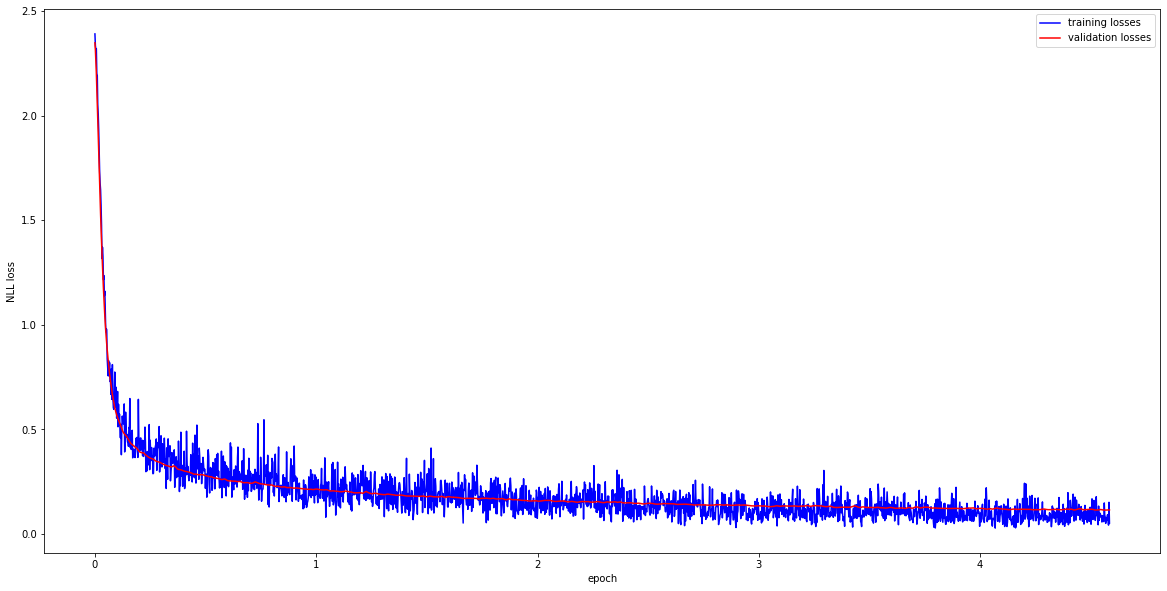

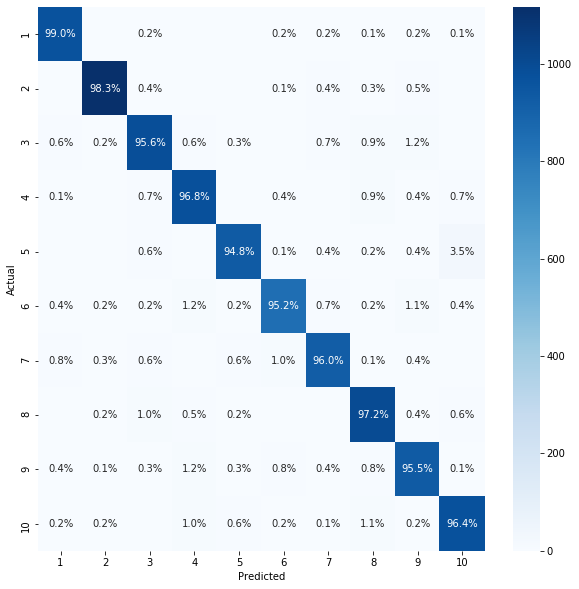

epoch  6 :  0 / 60000  (0 %)  | train loss:0.0757 | val loss:0.1101 | val acc:0.9672 | Time:0.9128
epoch  6 :  128 / 60000  (0 %)  | train loss:0.0568 | val loss:0.1097 | val acc:0.9672 | Time:1.8457
epoch  6 :  256 / 60000  (0 %)  | train loss:0.0485 | val loss:0.1096 | val acc:0.9664 | Time:2.7738
epoch  6 :  384 / 60000  (1 %)  | train loss:0.0911 | val loss:0.1094 | val acc:0.9662 | Time:3.6181
epoch  6 :  512 / 60000  (1 %)  | train loss:0.0354 | val loss:0.1092 | val acc:0.9658 | Time:4.4712
epoch  6 :  640 / 60000  (1 %)  | train loss:0.0317 | val loss:0.1092 | val acc:0.9664 | Time:5.3309
epoch  6 :  768 / 60000  (1 %)  | train loss:0.0352 | val loss:0.1094 | val acc:0.9660 | Time:6.2537
epoch  6 :  896 / 60000  (1 %)  | train loss:0.1107 | val loss:0.1096 | val acc:0.9662 | Time:7.0981
epoch  6 :  1024 / 60000  (2 %)  | train loss:0.0482 | val loss:0.1099 | val acc:0.9666 | Time:7.9444
epoch  6 :  1152 / 60000  (2 %)  | train loss:0.0474 | val loss:0.1101 | val acc:0.9664 | Ti

epoch  6 :  10240 / 60000  (17 %)  | train loss:0.0906 | val loss:0.1086 | val acc:0.9696 | Time:69.8032
epoch  6 :  10368 / 60000  (17 %)  | train loss:0.0322 | val loss:0.1090 | val acc:0.9692 | Time:70.6428
epoch  6 :  10496 / 60000  (17 %)  | train loss:0.0556 | val loss:0.1094 | val acc:0.9692 | Time:71.4902
epoch  6 :  10624 / 60000  (18 %)  | train loss:0.0294 | val loss:0.1096 | val acc:0.9686 | Time:72.3346
epoch  6 :  10752 / 60000  (18 %)  | train loss:0.0732 | val loss:0.1097 | val acc:0.9686 | Time:73.1921
epoch  6 :  10880 / 60000  (18 %)  | train loss:0.0189 | val loss:0.1097 | val acc:0.9688 | Time:74.0357
epoch  6 :  11008 / 60000  (18 %)  | train loss:0.0396 | val loss:0.1094 | val acc:0.9692 | Time:74.8785
epoch  6 :  11136 / 60000  (19 %)  | train loss:0.0429 | val loss:0.1092 | val acc:0.9690 | Time:75.7227
epoch  6 :  11264 / 60000  (19 %)  | train loss:0.0607 | val loss:0.1087 | val acc:0.9692 | Time:76.6242
epoch  6 :  11392 / 60000  (19 %)  | train loss:0.1400 

epoch  6 :  20224 / 60000  (34 %)  | train loss:0.0680 | val loss:0.1073 | val acc:0.9704 | Time:138.8211
epoch  6 :  20352 / 60000  (34 %)  | train loss:0.0571 | val loss:0.1073 | val acc:0.9702 | Time:139.6795
epoch  6 :  20480 / 60000  (34 %)  | train loss:0.1166 | val loss:0.1071 | val acc:0.9704 | Time:140.5456
epoch  6 :  20608 / 60000  (34 %)  | train loss:0.0551 | val loss:0.1069 | val acc:0.9704 | Time:141.4613
epoch  6 :  20736 / 60000  (35 %)  | train loss:0.0814 | val loss:0.1070 | val acc:0.9704 | Time:142.3113
epoch  6 :  20864 / 60000  (35 %)  | train loss:0.0263 | val loss:0.1072 | val acc:0.9702 | Time:143.1586
epoch  6 :  20992 / 60000  (35 %)  | train loss:0.0886 | val loss:0.1068 | val acc:0.9702 | Time:144.0148
epoch  6 :  21120 / 60000  (35 %)  | train loss:0.0391 | val loss:0.1066 | val acc:0.9702 | Time:144.8687
epoch  6 :  21248 / 60000  (35 %)  | train loss:0.0441 | val loss:0.1066 | val acc:0.9696 | Time:145.7351
epoch  6 :  21376 / 60000  (36 %)  | train los

epoch  6 :  30208 / 60000  (50 %)  | train loss:0.1644 | val loss:0.1047 | val acc:0.9682 | Time:205.9868
epoch  6 :  30336 / 60000  (51 %)  | train loss:0.0727 | val loss:0.1046 | val acc:0.9680 | Time:206.8247
epoch  6 :  30464 / 60000  (51 %)  | train loss:0.1192 | val loss:0.1047 | val acc:0.9690 | Time:207.6716
epoch  6 :  30592 / 60000  (51 %)  | train loss:0.0477 | val loss:0.1053 | val acc:0.9692 | Time:208.5194
epoch  6 :  30720 / 60000  (51 %)  | train loss:0.0431 | val loss:0.1061 | val acc:0.9688 | Time:209.3599
epoch  6 :  30848 / 60000  (51 %)  | train loss:0.0400 | val loss:0.1068 | val acc:0.9680 | Time:210.2099
epoch  6 :  30976 / 60000  (52 %)  | train loss:0.1273 | val loss:0.1073 | val acc:0.9680 | Time:211.1350
epoch  6 :  31104 / 60000  (52 %)  | train loss:0.0440 | val loss:0.1078 | val acc:0.9678 | Time:212.0940
epoch  6 :  31232 / 60000  (52 %)  | train loss:0.0654 | val loss:0.1084 | val acc:0.9676 | Time:212.9789
epoch  6 :  31360 / 60000  (52 %)  | train los

epoch  6 :  40192 / 60000  (67 %)  | train loss:0.0469 | val loss:0.1073 | val acc:0.9674 | Time:273.7096
epoch  6 :  40320 / 60000  (67 %)  | train loss:0.1112 | val loss:0.1073 | val acc:0.9674 | Time:274.5649
epoch  6 :  40448 / 60000  (67 %)  | train loss:0.1135 | val loss:0.1074 | val acc:0.9672 | Time:275.4137
epoch  6 :  40576 / 60000  (68 %)  | train loss:0.0646 | val loss:0.1075 | val acc:0.9668 | Time:276.3232
epoch  6 :  40704 / 60000  (68 %)  | train loss:0.1590 | val loss:0.1077 | val acc:0.9672 | Time:277.1686
epoch  6 :  40832 / 60000  (68 %)  | train loss:0.0465 | val loss:0.1080 | val acc:0.9678 | Time:278.0135
epoch  6 :  40960 / 60000  (68 %)  | train loss:0.0506 | val loss:0.1084 | val acc:0.9676 | Time:278.8593
epoch  6 :  41088 / 60000  (68 %)  | train loss:0.0719 | val loss:0.1082 | val acc:0.9678 | Time:279.7096
epoch  6 :  41216 / 60000  (69 %)  | train loss:0.0561 | val loss:0.1079 | val acc:0.9684 | Time:280.5527
epoch  6 :  41344 / 60000  (69 %)  | train los

epoch  6 :  50176 / 60000  (84 %)  | train loss:0.0620 | val loss:0.1055 | val acc:0.9680 | Time:340.7029
epoch  6 :  50304 / 60000  (84 %)  | train loss:0.0415 | val loss:0.1052 | val acc:0.9674 | Time:341.5530
epoch  6 :  50432 / 60000  (84 %)  | train loss:0.1410 | val loss:0.1050 | val acc:0.9668 | Time:342.4118
epoch  6 :  50560 / 60000  (84 %)  | train loss:0.1322 | val loss:0.1048 | val acc:0.9674 | Time:343.2988
epoch  6 :  50688 / 60000  (84 %)  | train loss:0.0745 | val loss:0.1047 | val acc:0.9674 | Time:344.1703
epoch  6 :  50816 / 60000  (85 %)  | train loss:0.0631 | val loss:0.1048 | val acc:0.9678 | Time:345.0247
epoch  6 :  50944 / 60000  (85 %)  | train loss:0.0847 | val loss:0.1050 | val acc:0.9680 | Time:345.9355
epoch  6 :  51072 / 60000  (85 %)  | train loss:0.0320 | val loss:0.1056 | val acc:0.9676 | Time:346.7812
epoch  6 :  51200 / 60000  (85 %)  | train loss:0.0503 | val loss:0.1064 | val acc:0.9672 | Time:347.6606
epoch  6 :  51328 / 60000  (86 %)  | train los

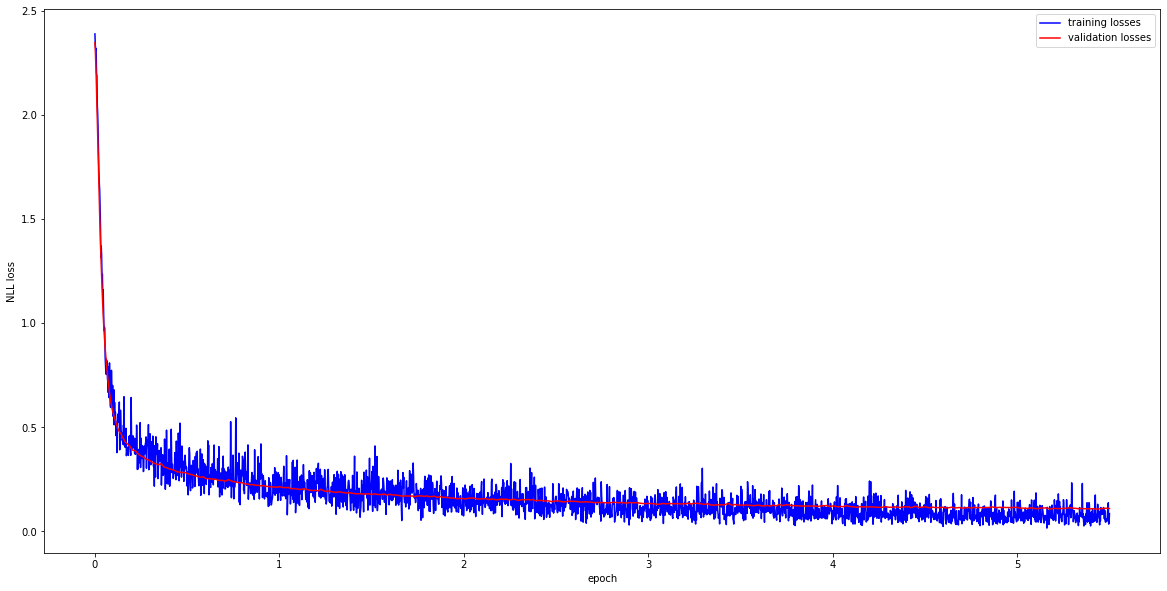

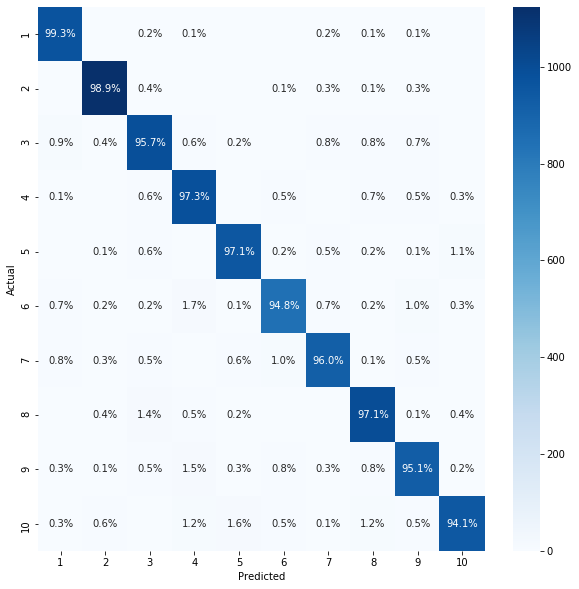

epoch  7 :  0 / 60000  (0 %)  | train loss:0.0439 | val loss:0.1040 | val acc:0.9692 | Time:0.9379
epoch  7 :  128 / 60000  (0 %)  | train loss:0.0526 | val loss:0.1036 | val acc:0.9688 | Time:1.8390
epoch  7 :  256 / 60000  (0 %)  | train loss:0.0271 | val loss:0.1036 | val acc:0.9686 | Time:2.6976
epoch  7 :  384 / 60000  (1 %)  | train loss:0.0967 | val loss:0.1038 | val acc:0.9686 | Time:3.5869
epoch  7 :  512 / 60000  (1 %)  | train loss:0.0320 | val loss:0.1043 | val acc:0.9682 | Time:4.4491
epoch  7 :  640 / 60000  (1 %)  | train loss:0.0812 | val loss:0.1047 | val acc:0.9674 | Time:5.3213
epoch  7 :  768 / 60000  (1 %)  | train loss:0.0644 | val loss:0.1052 | val acc:0.9676 | Time:6.2481
epoch  7 :  896 / 60000  (1 %)  | train loss:0.0477 | val loss:0.1055 | val acc:0.9678 | Time:7.1024
epoch  7 :  1024 / 60000  (2 %)  | train loss:0.0370 | val loss:0.1055 | val acc:0.9674 | Time:8.0180
epoch  7 :  1152 / 60000  (2 %)  | train loss:0.0829 | val loss:0.1050 | val acc:0.9678 | Ti

epoch  7 :  10240 / 60000  (17 %)  | train loss:0.0261 | val loss:0.1046 | val acc:0.9682 | Time:71.7626
epoch  7 :  10368 / 60000  (17 %)  | train loss:0.0604 | val loss:0.1048 | val acc:0.9686 | Time:72.6878
epoch  7 :  10496 / 60000  (17 %)  | train loss:0.0428 | val loss:0.1052 | val acc:0.9682 | Time:73.6190
epoch  7 :  10624 / 60000  (18 %)  | train loss:0.0332 | val loss:0.1057 | val acc:0.9690 | Time:74.5396
epoch  7 :  10752 / 60000  (18 %)  | train loss:0.0578 | val loss:0.1061 | val acc:0.9690 | Time:75.4501
epoch  7 :  10880 / 60000  (18 %)  | train loss:0.0576 | val loss:0.1062 | val acc:0.9694 | Time:76.3675
epoch  7 :  11008 / 60000  (18 %)  | train loss:0.0414 | val loss:0.1061 | val acc:0.9692 | Time:77.2633
epoch  7 :  11136 / 60000  (19 %)  | train loss:0.0408 | val loss:0.1060 | val acc:0.9698 | Time:78.1660
epoch  7 :  11264 / 60000  (19 %)  | train loss:0.0581 | val loss:0.1057 | val acc:0.9700 | Time:79.0785
epoch  7 :  11392 / 60000  (19 %)  | train loss:0.0338 

epoch  7 :  20224 / 60000  (34 %)  | train loss:0.0869 | val loss:0.1050 | val acc:0.9704 | Time:142.2084
epoch  7 :  20352 / 60000  (34 %)  | train loss:0.0353 | val loss:0.1050 | val acc:0.9700 | Time:143.0743
epoch  7 :  20480 / 60000  (34 %)  | train loss:0.0755 | val loss:0.1050 | val acc:0.9694 | Time:143.9360
epoch  7 :  20608 / 60000  (34 %)  | train loss:0.0262 | val loss:0.1049 | val acc:0.9692 | Time:144.7921
epoch  7 :  20736 / 60000  (35 %)  | train loss:0.0664 | val loss:0.1048 | val acc:0.9690 | Time:145.6420
epoch  7 :  20864 / 60000  (35 %)  | train loss:0.0486 | val loss:0.1047 | val acc:0.9692 | Time:146.5556
epoch  7 :  20992 / 60000  (35 %)  | train loss:0.1643 | val loss:0.1050 | val acc:0.9692 | Time:147.4103
epoch  7 :  21120 / 60000  (35 %)  | train loss:0.0474 | val loss:0.1053 | val acc:0.9688 | Time:148.2685
epoch  7 :  21248 / 60000  (35 %)  | train loss:0.1307 | val loss:0.1050 | val acc:0.9688 | Time:149.1350
epoch  7 :  21376 / 60000  (36 %)  | train los

epoch  7 :  30208 / 60000  (50 %)  | train loss:0.0796 | val loss:0.1024 | val acc:0.9694 | Time:211.5270
epoch  7 :  30336 / 60000  (51 %)  | train loss:0.0158 | val loss:0.1021 | val acc:0.9694 | Time:212.4601
epoch  7 :  30464 / 60000  (51 %)  | train loss:0.1419 | val loss:0.1015 | val acc:0.9698 | Time:213.3211
epoch  7 :  30592 / 60000  (51 %)  | train loss:0.0479 | val loss:0.1011 | val acc:0.9704 | Time:214.2129
epoch  7 :  30720 / 60000  (51 %)  | train loss:0.0558 | val loss:0.1008 | val acc:0.9696 | Time:215.1153
epoch  7 :  30848 / 60000  (51 %)  | train loss:0.0197 | val loss:0.1008 | val acc:0.9692 | Time:215.9865
epoch  7 :  30976 / 60000  (52 %)  | train loss:0.0472 | val loss:0.1010 | val acc:0.9688 | Time:216.8657
epoch  7 :  31104 / 60000  (52 %)  | train loss:0.0392 | val loss:0.1015 | val acc:0.9696 | Time:217.7486
epoch  7 :  31232 / 60000  (52 %)  | train loss:0.0731 | val loss:0.1023 | val acc:0.9700 | Time:218.6727
epoch  7 :  31360 / 60000  (52 %)  | train los

epoch  7 :  40192 / 60000  (67 %)  | train loss:0.0604 | val loss:0.0999 | val acc:0.9700 | Time:280.1261
epoch  7 :  40320 / 60000  (67 %)  | train loss:0.0417 | val loss:0.0998 | val acc:0.9706 | Time:280.9745
epoch  7 :  40448 / 60000  (67 %)  | train loss:0.1083 | val loss:0.1000 | val acc:0.9704 | Time:281.8256
epoch  7 :  40576 / 60000  (68 %)  | train loss:0.0525 | val loss:0.1000 | val acc:0.9698 | Time:282.6758
epoch  7 :  40704 / 60000  (68 %)  | train loss:0.0626 | val loss:0.1000 | val acc:0.9698 | Time:283.5871
epoch  7 :  40832 / 60000  (68 %)  | train loss:0.0708 | val loss:0.0999 | val acc:0.9702 | Time:284.4401
epoch  7 :  40960 / 60000  (68 %)  | train loss:0.0437 | val loss:0.0998 | val acc:0.9702 | Time:285.3157
epoch  7 :  41088 / 60000  (68 %)  | train loss:0.0478 | val loss:0.0995 | val acc:0.9704 | Time:286.2285
epoch  7 :  41216 / 60000  (69 %)  | train loss:0.0706 | val loss:0.0992 | val acc:0.9706 | Time:287.1011
epoch  7 :  41344 / 60000  (69 %)  | train los

epoch  7 :  50176 / 60000  (84 %)  | train loss:0.0385 | val loss:0.1029 | val acc:0.9694 | Time:351.7981
epoch  7 :  50304 / 60000  (84 %)  | train loss:0.0571 | val loss:0.1032 | val acc:0.9692 | Time:352.7513
epoch  7 :  50432 / 60000  (84 %)  | train loss:0.0482 | val loss:0.1030 | val acc:0.9694 | Time:353.6886
epoch  7 :  50560 / 60000  (84 %)  | train loss:0.0250 | val loss:0.1031 | val acc:0.9692 | Time:354.6023
epoch  7 :  50688 / 60000  (84 %)  | train loss:0.0478 | val loss:0.1025 | val acc:0.9694 | Time:355.4859
epoch  7 :  50816 / 60000  (85 %)  | train loss:0.1025 | val loss:0.1022 | val acc:0.9694 | Time:356.4401
epoch  7 :  50944 / 60000  (85 %)  | train loss:0.0153 | val loss:0.1020 | val acc:0.9698 | Time:357.3387
epoch  7 :  51072 / 60000  (85 %)  | train loss:0.0312 | val loss:0.1020 | val acc:0.9696 | Time:358.3074
epoch  7 :  51200 / 60000  (85 %)  | train loss:0.0738 | val loss:0.1017 | val acc:0.9700 | Time:359.1899
epoch  7 :  51328 / 60000  (86 %)  | train los

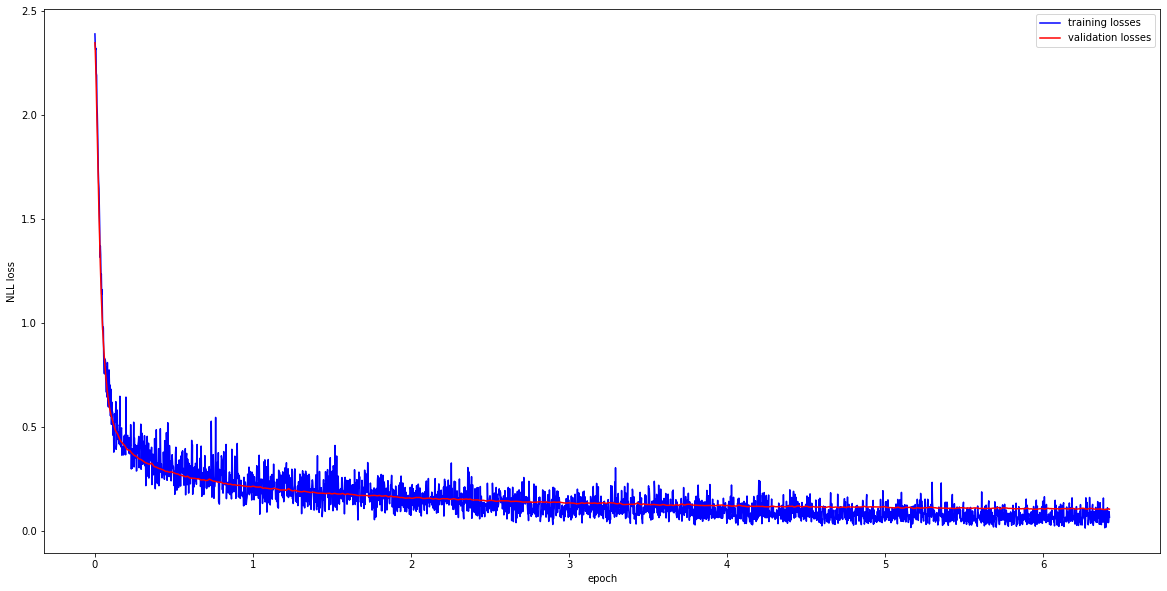

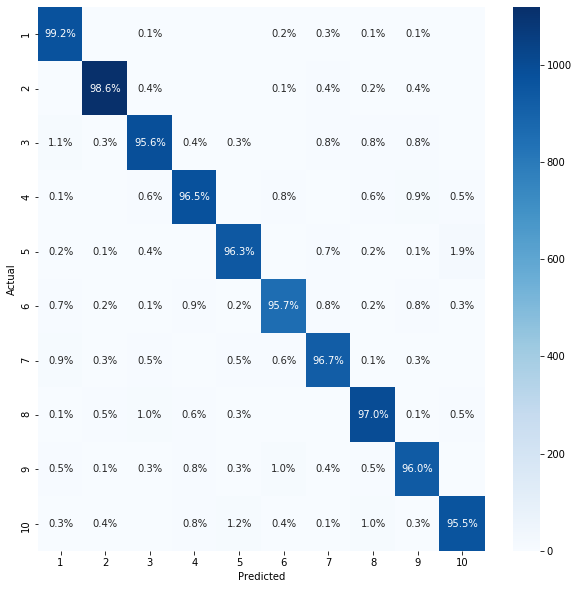

epoch  8 :  0 / 60000  (0 %)  | train loss:0.0423 | val loss:0.1009 | val acc:0.9704 | Time:0.9136
epoch  8 :  128 / 60000  (0 %)  | train loss:0.0431 | val loss:0.1007 | val acc:0.9706 | Time:1.8278
epoch  8 :  256 / 60000  (0 %)  | train loss:0.0383 | val loss:0.1007 | val acc:0.9702 | Time:2.9016
epoch  8 :  384 / 60000  (1 %)  | train loss:0.1003 | val loss:0.1007 | val acc:0.9702 | Time:3.7641
epoch  8 :  512 / 60000  (1 %)  | train loss:0.0619 | val loss:0.1008 | val acc:0.9694 | Time:4.6358
epoch  8 :  640 / 60000  (1 %)  | train loss:0.0305 | val loss:0.1010 | val acc:0.9692 | Time:5.4963
epoch  8 :  768 / 60000  (1 %)  | train loss:0.0368 | val loss:0.1012 | val acc:0.9694 | Time:6.3754
epoch  8 :  896 / 60000  (1 %)  | train loss:0.0262 | val loss:0.1013 | val acc:0.9698 | Time:7.2373
epoch  8 :  1024 / 60000  (2 %)  | train loss:0.0629 | val loss:0.1014 | val acc:0.9696 | Time:8.1013
epoch  8 :  1152 / 60000  (2 %)  | train loss:0.0579 | val loss:0.1013 | val acc:0.9694 | Ti

epoch  8 :  10240 / 60000  (17 %)  | train loss:0.0544 | val loss:0.0990 | val acc:0.9704 | Time:69.1376
epoch  8 :  10368 / 60000  (17 %)  | train loss:0.0546 | val loss:0.0993 | val acc:0.9704 | Time:70.0103
epoch  8 :  10496 / 60000  (17 %)  | train loss:0.0677 | val loss:0.0997 | val acc:0.9708 | Time:70.8737
epoch  8 :  10624 / 60000  (18 %)  | train loss:0.0492 | val loss:0.1002 | val acc:0.9708 | Time:71.7541
epoch  8 :  10752 / 60000  (18 %)  | train loss:0.0587 | val loss:0.1006 | val acc:0.9704 | Time:72.7016
epoch  8 :  10880 / 60000  (18 %)  | train loss:0.0799 | val loss:0.1005 | val acc:0.9706 | Time:73.5814
epoch  8 :  11008 / 60000  (18 %)  | train loss:0.1364 | val loss:0.1002 | val acc:0.9714 | Time:74.4866
epoch  8 :  11136 / 60000  (19 %)  | train loss:0.0365 | val loss:0.0999 | val acc:0.9716 | Time:75.4030
epoch  8 :  11264 / 60000  (19 %)  | train loss:0.0596 | val loss:0.0995 | val acc:0.9716 | Time:76.3183
epoch  8 :  11392 / 60000  (19 %)  | train loss:0.0742 

epoch  8 :  20224 / 60000  (34 %)  | train loss:0.0130 | val loss:0.0969 | val acc:0.9714 | Time:138.2252
epoch  8 :  20352 / 60000  (34 %)  | train loss:0.0268 | val loss:0.0974 | val acc:0.9712 | Time:139.0606
epoch  8 :  20480 / 60000  (34 %)  | train loss:0.0520 | val loss:0.0978 | val acc:0.9708 | Time:139.8890
epoch  8 :  20608 / 60000  (34 %)  | train loss:0.0299 | val loss:0.0981 | val acc:0.9708 | Time:140.7176
epoch  8 :  20736 / 60000  (35 %)  | train loss:0.0818 | val loss:0.0983 | val acc:0.9706 | Time:141.5524
epoch  8 :  20864 / 60000  (35 %)  | train loss:0.0487 | val loss:0.0986 | val acc:0.9704 | Time:142.3884
epoch  8 :  20992 / 60000  (35 %)  | train loss:0.0647 | val loss:0.0981 | val acc:0.9710 | Time:143.2276
epoch  8 :  21120 / 60000  (35 %)  | train loss:0.0190 | val loss:0.0976 | val acc:0.9716 | Time:144.1122
epoch  8 :  21248 / 60000  (35 %)  | train loss:0.0342 | val loss:0.0972 | val acc:0.9714 | Time:144.9482
epoch  8 :  21376 / 60000  (36 %)  | train los

epoch  8 :  30208 / 60000  (50 %)  | train loss:0.0241 | val loss:0.1031 | val acc:0.9698 | Time:207.9402
epoch  8 :  30336 / 60000  (51 %)  | train loss:0.0733 | val loss:0.1029 | val acc:0.9696 | Time:208.7904
epoch  8 :  30464 / 60000  (51 %)  | train loss:0.0578 | val loss:0.1022 | val acc:0.9692 | Time:209.6447
epoch  8 :  30592 / 60000  (51 %)  | train loss:0.0234 | val loss:0.1016 | val acc:0.9700 | Time:210.5520
epoch  8 :  30720 / 60000  (51 %)  | train loss:0.1011 | val loss:0.1010 | val acc:0.9702 | Time:211.3983
epoch  8 :  30848 / 60000  (51 %)  | train loss:0.0397 | val loss:0.1005 | val acc:0.9704 | Time:212.2504
epoch  8 :  30976 / 60000  (52 %)  | train loss:0.0662 | val loss:0.1001 | val acc:0.9706 | Time:213.1102
epoch  8 :  31104 / 60000  (52 %)  | train loss:0.0438 | val loss:0.0998 | val acc:0.9708 | Time:213.9691
epoch  8 :  31232 / 60000  (52 %)  | train loss:0.0542 | val loss:0.0996 | val acc:0.9708 | Time:214.8191
epoch  8 :  31360 / 60000  (52 %)  | train los

epoch  8 :  40192 / 60000  (67 %)  | train loss:0.0600 | val loss:0.1014 | val acc:0.9688 | Time:283.5950
epoch  8 :  40320 / 60000  (67 %)  | train loss:0.0996 | val loss:0.1018 | val acc:0.9690 | Time:284.4400
epoch  8 :  40448 / 60000  (67 %)  | train loss:0.0382 | val loss:0.1020 | val acc:0.9694 | Time:285.2890
epoch  8 :  40576 / 60000  (68 %)  | train loss:0.0317 | val loss:0.1022 | val acc:0.9700 | Time:286.1352
epoch  8 :  40704 / 60000  (68 %)  | train loss:0.1825 | val loss:0.1021 | val acc:0.9700 | Time:286.9811
epoch  8 :  40832 / 60000  (68 %)  | train loss:0.0497 | val loss:0.1018 | val acc:0.9698 | Time:287.8297
epoch  8 :  40960 / 60000  (68 %)  | train loss:0.0853 | val loss:0.1009 | val acc:0.9702 | Time:288.7504
epoch  8 :  41088 / 60000  (68 %)  | train loss:0.0816 | val loss:0.0999 | val acc:0.9704 | Time:289.5935
epoch  8 :  41216 / 60000  (69 %)  | train loss:0.0324 | val loss:0.0992 | val acc:0.9700 | Time:290.5098
epoch  8 :  41344 / 60000  (69 %)  | train los

epoch  8 :  50176 / 60000  (84 %)  | train loss:0.0558 | val loss:0.0985 | val acc:0.9714 | Time:350.6595
epoch  8 :  50304 / 60000  (84 %)  | train loss:0.0420 | val loss:0.0981 | val acc:0.9716 | Time:351.5049
epoch  8 :  50432 / 60000  (84 %)  | train loss:0.0329 | val loss:0.0979 | val acc:0.9712 | Time:352.4108
epoch  8 :  50560 / 60000  (84 %)  | train loss:0.1006 | val loss:0.0976 | val acc:0.9710 | Time:353.2489
epoch  8 :  50688 / 60000  (84 %)  | train loss:0.0258 | val loss:0.0976 | val acc:0.9712 | Time:354.1068
epoch  8 :  50816 / 60000  (85 %)  | train loss:0.0337 | val loss:0.0977 | val acc:0.9714 | Time:354.9527
epoch  8 :  50944 / 60000  (85 %)  | train loss:0.0744 | val loss:0.0977 | val acc:0.9714 | Time:355.7907
epoch  8 :  51072 / 60000  (85 %)  | train loss:0.0360 | val loss:0.0975 | val acc:0.9710 | Time:356.6393
epoch  8 :  51200 / 60000  (85 %)  | train loss:0.0265 | val loss:0.0975 | val acc:0.9706 | Time:357.4876
epoch  8 :  51328 / 60000  (86 %)  | train los

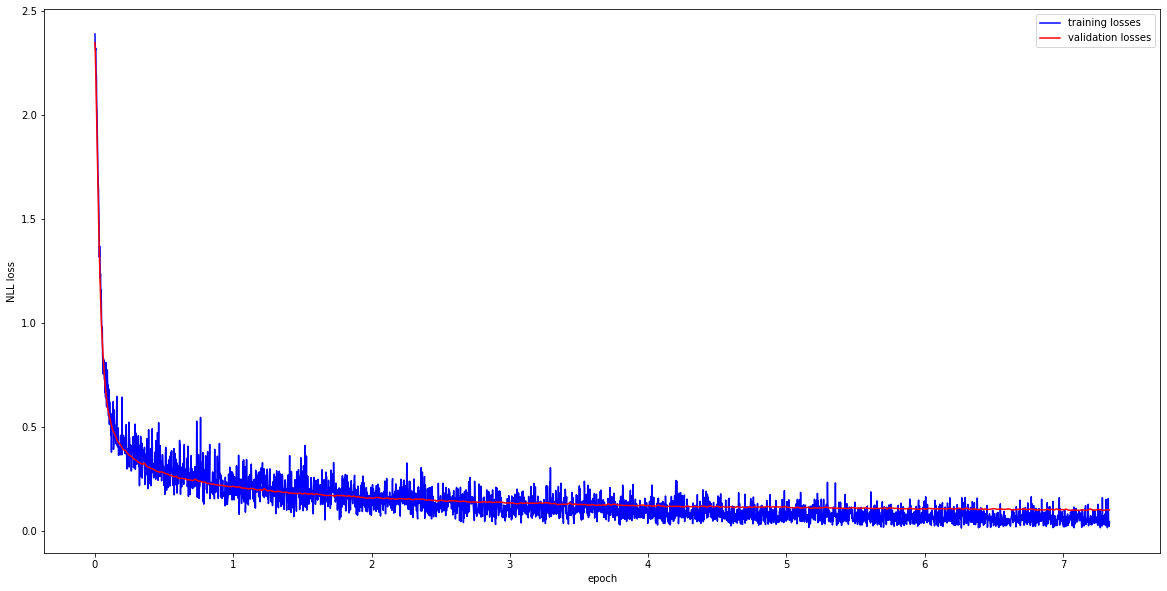

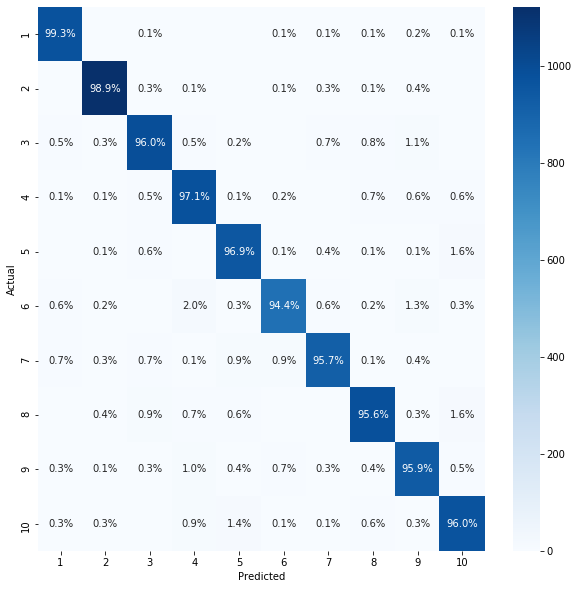

epoch  9 :  0 / 60000  (0 %)  | train loss:0.0477 | val loss:0.1009 | val acc:0.9696 | Time:1.0642
epoch  9 :  128 / 60000  (0 %)  | train loss:0.0269 | val loss:0.1006 | val acc:0.9696 | Time:1.9870
epoch  9 :  256 / 60000  (0 %)  | train loss:0.0247 | val loss:0.1003 | val acc:0.9708 | Time:2.9869
epoch  9 :  384 / 60000  (1 %)  | train loss:0.0582 | val loss:0.1002 | val acc:0.9702 | Time:3.9293
epoch  9 :  512 / 60000  (1 %)  | train loss:0.0207 | val loss:0.1002 | val acc:0.9704 | Time:4.9462
epoch  9 :  640 / 60000  (1 %)  | train loss:0.0181 | val loss:0.1002 | val acc:0.9712 | Time:5.8341
epoch  9 :  768 / 60000  (1 %)  | train loss:0.0471 | val loss:0.1003 | val acc:0.9708 | Time:6.7282
epoch  9 :  896 / 60000  (1 %)  | train loss:0.0163 | val loss:0.1004 | val acc:0.9704 | Time:7.6637
epoch  9 :  1024 / 60000  (2 %)  | train loss:0.0438 | val loss:0.1005 | val acc:0.9700 | Time:8.5648
epoch  9 :  1152 / 60000  (2 %)  | train loss:0.0540 | val loss:0.1003 | val acc:0.9704 | Ti

epoch  9 :  10240 / 60000  (17 %)  | train loss:0.0269 | val loss:0.0972 | val acc:0.9708 | Time:73.7701
epoch  9 :  10368 / 60000  (17 %)  | train loss:0.0191 | val loss:0.0973 | val acc:0.9708 | Time:74.6151
epoch  9 :  10496 / 60000  (17 %)  | train loss:0.0813 | val loss:0.0976 | val acc:0.9706 | Time:75.4600
epoch  9 :  10624 / 60000  (18 %)  | train loss:0.0281 | val loss:0.0979 | val acc:0.9706 | Time:76.3105
epoch  9 :  10752 / 60000  (18 %)  | train loss:0.0256 | val loss:0.0981 | val acc:0.9706 | Time:77.1570
epoch  9 :  10880 / 60000  (18 %)  | train loss:0.0405 | val loss:0.0981 | val acc:0.9704 | Time:78.0078
epoch  9 :  11008 / 60000  (18 %)  | train loss:0.0589 | val loss:0.0983 | val acc:0.9702 | Time:78.9142
epoch  9 :  11136 / 60000  (19 %)  | train loss:0.0506 | val loss:0.0983 | val acc:0.9696 | Time:79.7558
epoch  9 :  11264 / 60000  (19 %)  | train loss:0.0240 | val loss:0.0984 | val acc:0.9694 | Time:80.5977
epoch  9 :  11392 / 60000  (19 %)  | train loss:0.0313 

epoch  9 :  20224 / 60000  (34 %)  | train loss:0.0637 | val loss:0.0963 | val acc:0.9726 | Time:142.0511
epoch  9 :  20352 / 60000  (34 %)  | train loss:0.0479 | val loss:0.0965 | val acc:0.9726 | Time:142.9182
epoch  9 :  20480 / 60000  (34 %)  | train loss:0.0286 | val loss:0.0967 | val acc:0.9728 | Time:143.8511
epoch  9 :  20608 / 60000  (34 %)  | train loss:0.0836 | val loss:0.0970 | val acc:0.9734 | Time:144.7160
epoch  9 :  20736 / 60000  (35 %)  | train loss:0.0089 | val loss:0.0974 | val acc:0.9730 | Time:145.7120
epoch  9 :  20864 / 60000  (35 %)  | train loss:0.0156 | val loss:0.0977 | val acc:0.9726 | Time:146.6315
epoch  9 :  20992 / 60000  (35 %)  | train loss:0.0245 | val loss:0.0977 | val acc:0.9728 | Time:147.5084
epoch  9 :  21120 / 60000  (35 %)  | train loss:0.0361 | val loss:0.0977 | val acc:0.9730 | Time:148.3959
epoch  9 :  21248 / 60000  (35 %)  | train loss:0.0533 | val loss:0.0976 | val acc:0.9728 | Time:149.2783
epoch  9 :  21376 / 60000  (36 %)  | train los

epoch  9 :  30208 / 60000  (50 %)  | train loss:0.0170 | val loss:0.0968 | val acc:0.9714 | Time:214.6289
epoch  9 :  30336 / 60000  (51 %)  | train loss:0.0610 | val loss:0.0967 | val acc:0.9714 | Time:215.5539
epoch  9 :  30464 / 60000  (51 %)  | train loss:0.0535 | val loss:0.0967 | val acc:0.9714 | Time:216.4981
epoch  9 :  30592 / 60000  (51 %)  | train loss:0.0305 | val loss:0.0968 | val acc:0.9718 | Time:217.6720
epoch  9 :  30720 / 60000  (51 %)  | train loss:0.0672 | val loss:0.0972 | val acc:0.9722 | Time:218.6567
epoch  9 :  30848 / 60000  (51 %)  | train loss:0.0580 | val loss:0.0977 | val acc:0.9722 | Time:219.6418
epoch  9 :  30976 / 60000  (52 %)  | train loss:0.0308 | val loss:0.0983 | val acc:0.9720 | Time:220.6285
epoch  9 :  31104 / 60000  (52 %)  | train loss:0.0576 | val loss:0.0988 | val acc:0.9718 | Time:221.5430
epoch  9 :  31232 / 60000  (52 %)  | train loss:0.0357 | val loss:0.0992 | val acc:0.9712 | Time:222.4442
epoch  9 :  31360 / 60000  (52 %)  | train los

epoch  9 :  40192 / 60000  (67 %)  | train loss:0.0318 | val loss:0.1003 | val acc:0.9702 | Time:286.8657
epoch  9 :  40320 / 60000  (67 %)  | train loss:0.0366 | val loss:0.1002 | val acc:0.9702 | Time:287.8285
epoch  9 :  40448 / 60000  (67 %)  | train loss:0.0249 | val loss:0.1002 | val acc:0.9708 | Time:288.7207
epoch  9 :  40576 / 60000  (68 %)  | train loss:0.0784 | val loss:0.1004 | val acc:0.9708 | Time:289.6105
epoch  9 :  40704 / 60000  (68 %)  | train loss:0.0549 | val loss:0.1001 | val acc:0.9706 | Time:290.4913
epoch  9 :  40832 / 60000  (68 %)  | train loss:0.0309 | val loss:0.1000 | val acc:0.9698 | Time:291.3596
epoch  9 :  40960 / 60000  (68 %)  | train loss:0.0278 | val loss:0.1000 | val acc:0.9702 | Time:292.2581
epoch  9 :  41088 / 60000  (68 %)  | train loss:0.0339 | val loss:0.1002 | val acc:0.9708 | Time:293.2759
epoch  9 :  41216 / 60000  (69 %)  | train loss:0.0364 | val loss:0.1005 | val acc:0.9706 | Time:294.2977
epoch  9 :  41344 / 60000  (69 %)  | train los

epoch  9 :  50176 / 60000  (84 %)  | train loss:0.0661 | val loss:0.0996 | val acc:0.9706 | Time:358.7325
epoch  9 :  50304 / 60000  (84 %)  | train loss:0.0138 | val loss:0.0999 | val acc:0.9706 | Time:359.7886
epoch  9 :  50432 / 60000  (84 %)  | train loss:0.0358 | val loss:0.1000 | val acc:0.9702 | Time:360.7078
epoch  9 :  50560 / 60000  (84 %)  | train loss:0.0991 | val loss:0.1000 | val acc:0.9702 | Time:361.8707
epoch  9 :  50688 / 60000  (84 %)  | train loss:0.0513 | val loss:0.0997 | val acc:0.9698 | Time:362.8275
epoch  9 :  50816 / 60000  (85 %)  | train loss:0.0287 | val loss:0.0994 | val acc:0.9698 | Time:363.7183
epoch  9 :  50944 / 60000  (85 %)  | train loss:0.0304 | val loss:0.0992 | val acc:0.9700 | Time:364.6218
epoch  9 :  51072 / 60000  (85 %)  | train loss:0.0401 | val loss:0.0989 | val acc:0.9708 | Time:365.5055
epoch  9 :  51200 / 60000  (85 %)  | train loss:0.0573 | val loss:0.0987 | val acc:0.9714 | Time:366.3806
epoch  9 :  51328 / 60000  (86 %)  | train los

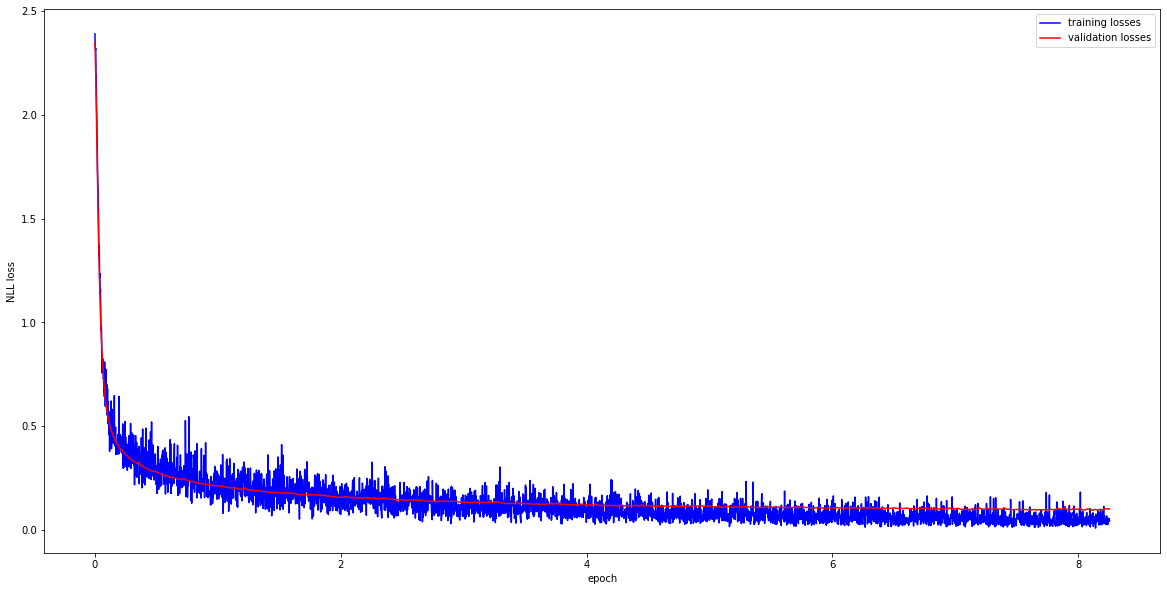

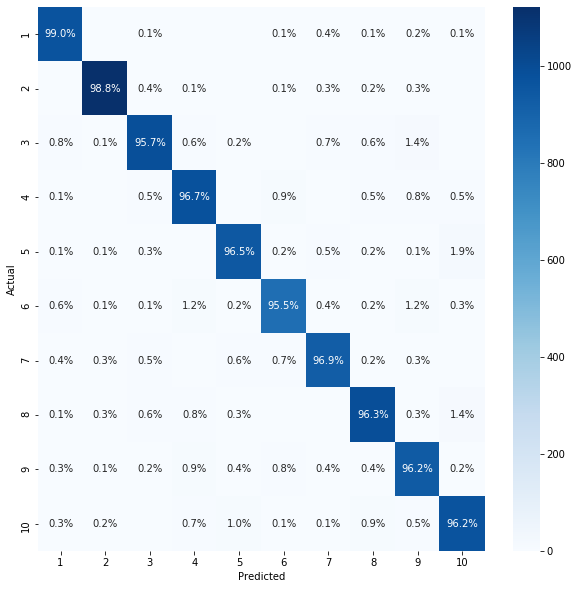

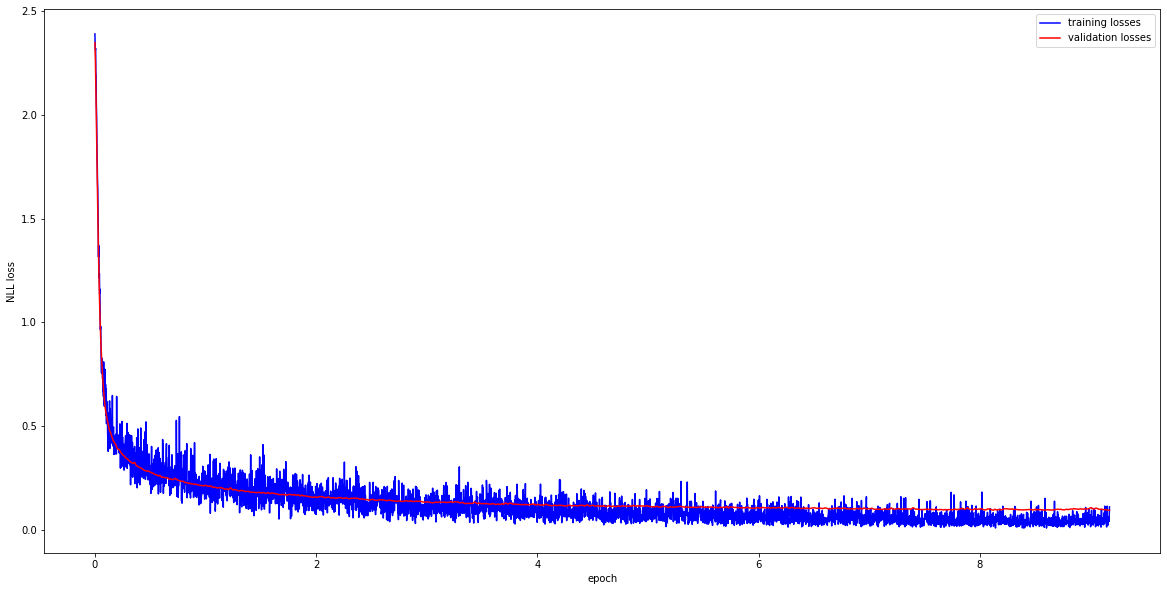

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 5
n_down = 7
p_down = 0.01

name = 'rnn-uam'
model = RNN_UAM()
model.to(device)
# rnn.cuda()
isImbalanced = False
getMDL = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 10
train_losses = []
val_losses = []
test_acces = []
l_list = []

# training and testing
for epoch in range(EPOCH):
    if epoch == 0:
        x_history_stack=None
        COMP_stack=None
        
    train_losses, val_losses, x_history_stack, COMP_stack, used_train_size, l = train_RN(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses,x_history_stack,COMP_stack,isImbalanced=isImbalanced,getMDL=getMDL)
    test_acces, x_history_stack_test, COMP_stack_test, confusion_mtx, _ = test_RN(model, device, test_loader, test_acces,x_history_stack,COMP_stack,getMDL=getMDL)
    for bl in l:
         l_list.append(bl)
            
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')


    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])
    
np.save('models/'+name+'_mdl.npy',np.array(l_list))
l_rnn_list = l_list

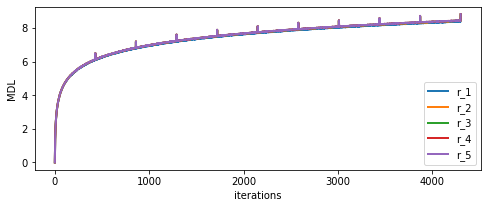

In [13]:
l_list = np.load('models/rnn-uam_mdl.npy')

T = np.arange(l_list.shape[0]) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

for t in np.arange(1,l_list.shape[1]):
    ax.plot(T,l_list[:,t],label='r_'+str(t),linewidth=lw)

ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()

fig.savefig('./figures/l_rnn.png',layout='tight')

RNNRN_UAM(
  (rnn): RNNCell(784, 100)
  (out): Linear(in_features=100, out_features=10, bias=True)
)
epoch  0 :  0 / 60000  (0 %)  | train loss:2.3069 | val loss:3.0945 | val acc:0.1382 | Time:0.9377
epoch  0 :  128 / 60000  (0 %)  | train loss:2.4183 | val loss:2.7995 | val acc:0.1340 | Time:1.8916
epoch  0 :  256 / 60000  (0 %)  | train loss:2.4780 | val loss:2.6918 | val acc:0.1316 | Time:2.7949
epoch  0 :  384 / 60000  (1 %)  | train loss:2.4470 | val loss:2.6656 | val acc:0.1162 | Time:3.7118
epoch  0 :  512 / 60000  (1 %)  | train loss:2.4901 | val loss:2.6849 | val acc:0.0958 | Time:4.5830
epoch  0 :  640 / 60000  (1 %)  | train loss:2.3391 | val loss:2.7371 | val acc:0.0784 | Time:5.5776
epoch  0 :  768 / 60000  (1 %)  | train loss:2.1097 | val loss:2.8130 | val acc:0.0632 | Time:6.4704
epoch  0 :  896 / 60000  (1 %)  | train loss:1.8815 | val loss:2.9042 | val acc:0.0484 | Time:7.3322
epoch  0 :  1024 / 60000  (2 %)  | train loss:1.6812 | val loss:3.0024 | val acc:0.0332 | Tim

epoch  0 :  10112 / 60000  (17 %)  | train loss:0.7036 | val loss:1.1099 | val acc:0.8546 | Time:76.7107
epoch  0 :  10240 / 60000  (17 %)  | train loss:0.4917 | val loss:1.0967 | val acc:0.8548 | Time:77.7541
epoch  0 :  10368 / 60000  (17 %)  | train loss:0.7239 | val loss:1.0835 | val acc:0.8554 | Time:78.7539
epoch  0 :  10496 / 60000  (17 %)  | train loss:0.6117 | val loss:1.0739 | val acc:0.8650 | Time:79.7208
epoch  0 :  10624 / 60000  (18 %)  | train loss:0.6798 | val loss:1.0706 | val acc:0.8682 | Time:80.6751
epoch  0 :  10752 / 60000  (18 %)  | train loss:0.7751 | val loss:1.0699 | val acc:0.8676 | Time:81.6099
epoch  0 :  10880 / 60000  (18 %)  | train loss:0.7264 | val loss:1.0624 | val acc:0.8642 | Time:82.8568
epoch  0 :  11008 / 60000  (18 %)  | train loss:0.3791 | val loss:1.0544 | val acc:0.8652 | Time:83.9398
epoch  0 :  11136 / 60000  (19 %)  | train loss:0.4717 | val loss:1.0465 | val acc:0.8660 | Time:85.1766
epoch  0 :  11264 / 60000  (19 %)  | train loss:0.7695 

epoch  0 :  20096 / 60000  (33 %)  | train loss:0.6366 | val loss:0.6681 | val acc:0.8740 | Time:157.4634
epoch  0 :  20224 / 60000  (34 %)  | train loss:0.5626 | val loss:0.6761 | val acc:0.8658 | Time:158.4869
epoch  0 :  20352 / 60000  (34 %)  | train loss:0.5738 | val loss:0.6938 | val acc:0.8576 | Time:159.6267
epoch  0 :  20480 / 60000  (34 %)  | train loss:0.7033 | val loss:0.7002 | val acc:0.8528 | Time:160.7090
epoch  0 :  20608 / 60000  (34 %)  | train loss:0.4520 | val loss:0.6913 | val acc:0.8564 | Time:162.0200
epoch  0 :  20736 / 60000  (35 %)  | train loss:0.5014 | val loss:0.6750 | val acc:0.8598 | Time:163.2157
epoch  0 :  20864 / 60000  (35 %)  | train loss:0.4673 | val loss:0.6660 | val acc:0.8590 | Time:164.4831
epoch  0 :  20992 / 60000  (35 %)  | train loss:0.5082 | val loss:0.6677 | val acc:0.8512 | Time:165.7656
epoch  0 :  21120 / 60000  (35 %)  | train loss:0.7147 | val loss:0.6609 | val acc:0.8592 | Time:166.9837
epoch  0 :  21248 / 60000  (35 %)  | train los

epoch  0 :  30080 / 60000  (50 %)  | train loss:0.5023 | val loss:0.5198 | val acc:0.8816 | Time:248.5326
epoch  0 :  30208 / 60000  (50 %)  | train loss:0.7556 | val loss:0.5189 | val acc:0.8786 | Time:249.6089
epoch  0 :  30336 / 60000  (51 %)  | train loss:0.5295 | val loss:0.5253 | val acc:0.8746 | Time:250.6885
epoch  0 :  30464 / 60000  (51 %)  | train loss:0.6998 | val loss:0.5251 | val acc:0.8750 | Time:251.7534
epoch  0 :  30592 / 60000  (51 %)  | train loss:0.7111 | val loss:0.5237 | val acc:0.8724 | Time:252.9463
epoch  0 :  30720 / 60000  (51 %)  | train loss:0.6227 | val loss:0.5097 | val acc:0.8824 | Time:254.1656
epoch  0 :  30848 / 60000  (51 %)  | train loss:0.4708 | val loss:0.5235 | val acc:0.8702 | Time:255.3845
epoch  0 :  30976 / 60000  (52 %)  | train loss:0.5266 | val loss:0.5457 | val acc:0.8596 | Time:256.5721
epoch  0 :  31104 / 60000  (52 %)  | train loss:0.5711 | val loss:0.5646 | val acc:0.8500 | Time:257.6908
epoch  0 :  31232 / 60000  (52 %)  | train los

epoch  0 :  40064 / 60000  (67 %)  | train loss:0.4939 | val loss:0.5811 | val acc:0.8264 | Time:341.4827
epoch  0 :  40192 / 60000  (67 %)  | train loss:0.6268 | val loss:0.5566 | val acc:0.8484 | Time:342.7299
epoch  0 :  40320 / 60000  (67 %)  | train loss:0.5522 | val loss:0.5530 | val acc:0.8508 | Time:343.9601
epoch  0 :  40448 / 60000  (67 %)  | train loss:1.2120 | val loss:0.5537 | val acc:0.8378 | Time:345.1770
epoch  0 :  40576 / 60000  (68 %)  | train loss:0.8103 | val loss:0.5598 | val acc:0.8326 | Time:346.4567
epoch  0 :  40704 / 60000  (68 %)  | train loss:0.5532 | val loss:0.5486 | val acc:0.8418 | Time:347.7944
epoch  0 :  40832 / 60000  (68 %)  | train loss:0.6377 | val loss:0.5418 | val acc:0.8484 | Time:349.0790
epoch  0 :  40960 / 60000  (68 %)  | train loss:0.5809 | val loss:0.5450 | val acc:0.8402 | Time:350.3526
epoch  0 :  41088 / 60000  (68 %)  | train loss:0.7426 | val loss:0.5298 | val acc:0.8514 | Time:351.8112
epoch  0 :  41216 / 60000  (69 %)  | train los

epoch  0 :  50048 / 60000  (83 %)  | train loss:0.8168 | val loss:0.5847 | val acc:0.8150 | Time:441.7968
epoch  0 :  50176 / 60000  (84 %)  | train loss:0.9441 | val loss:0.5813 | val acc:0.8128 | Time:443.0475
epoch  0 :  50304 / 60000  (84 %)  | train loss:1.0982 | val loss:0.5338 | val acc:0.8452 | Time:444.5286
epoch  0 :  50432 / 60000  (84 %)  | train loss:0.8147 | val loss:0.5836 | val acc:0.8282 | Time:445.8361
epoch  0 :  50560 / 60000  (84 %)  | train loss:1.0648 | val loss:0.6545 | val acc:0.7916 | Time:447.1066
epoch  0 :  50688 / 60000  (84 %)  | train loss:1.0101 | val loss:0.6544 | val acc:0.7894 | Time:448.3651
epoch  0 :  50816 / 60000  (85 %)  | train loss:1.2403 | val loss:0.6136 | val acc:0.8108 | Time:449.5980
epoch  0 :  50944 / 60000  (85 %)  | train loss:0.8401 | val loss:0.5824 | val acc:0.8300 | Time:450.8172
epoch  0 :  51072 / 60000  (85 %)  | train loss:1.1629 | val loss:0.5913 | val acc:0.8290 | Time:452.0622
epoch  0 :  51200 / 60000  (85 %)  | train los

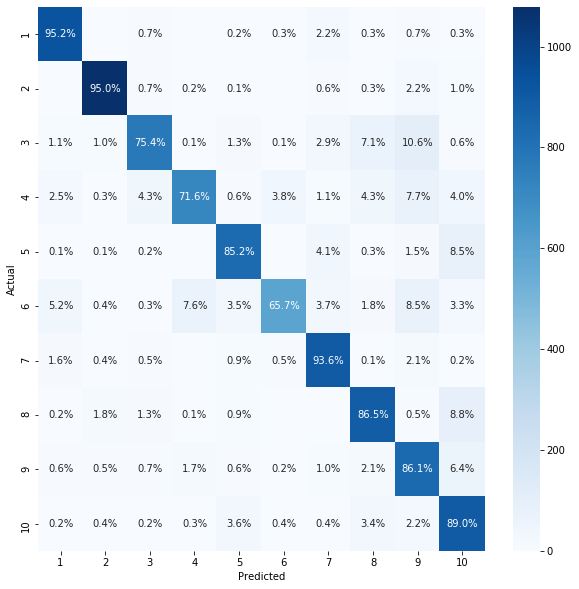

epoch  1 :  0 / 60000  (0 %)  | train loss:1.2310 | val loss:0.5155 | val acc:0.8494 | Time:1.5197
epoch  1 :  128 / 60000  (0 %)  | train loss:0.7713 | val loss:0.5380 | val acc:0.8390 | Time:2.8607
epoch  1 :  256 / 60000  (0 %)  | train loss:1.0283 | val loss:0.5837 | val acc:0.8178 | Time:4.3604
epoch  1 :  384 / 60000  (1 %)  | train loss:1.1096 | val loss:0.5208 | val acc:0.8552 | Time:5.8320
epoch  1 :  512 / 60000  (1 %)  | train loss:0.6350 | val loss:0.5069 | val acc:0.8618 | Time:7.2054
epoch  1 :  640 / 60000  (1 %)  | train loss:0.9000 | val loss:0.5367 | val acc:0.8356 | Time:8.7985
epoch  1 :  768 / 60000  (1 %)  | train loss:0.7939 | val loss:0.5584 | val acc:0.8196 | Time:10.1425
epoch  1 :  896 / 60000  (1 %)  | train loss:0.7628 | val loss:0.5192 | val acc:0.8382 | Time:11.3906
epoch  1 :  1024 / 60000  (2 %)  | train loss:0.9463 | val loss:0.5230 | val acc:0.8338 | Time:12.7952
epoch  1 :  1152 / 60000  (2 %)  | train loss:0.6880 | val loss:0.5931 | val acc:0.8008 |

epoch  1 :  10240 / 60000  (17 %)  | train loss:0.9463 | val loss:0.7599 | val acc:0.7240 | Time:109.9693
epoch  1 :  10368 / 60000  (17 %)  | train loss:2.0374 | val loss:0.6935 | val acc:0.7664 | Time:111.2530
epoch  1 :  10496 / 60000  (17 %)  | train loss:0.6262 | val loss:0.7614 | val acc:0.7296 | Time:112.5297
epoch  1 :  10624 / 60000  (18 %)  | train loss:1.0601 | val loss:0.7590 | val acc:0.7424 | Time:113.8078
epoch  1 :  10752 / 60000  (18 %)  | train loss:0.9176 | val loss:0.7715 | val acc:0.7440 | Time:115.0723
epoch  1 :  10880 / 60000  (18 %)  | train loss:1.2435 | val loss:0.7861 | val acc:0.7354 | Time:116.3538
epoch  1 :  11008 / 60000  (18 %)  | train loss:1.3334 | val loss:0.7515 | val acc:0.7460 | Time:117.6368
epoch  1 :  11136 / 60000  (19 %)  | train loss:1.0124 | val loss:0.8041 | val acc:0.7302 | Time:118.9075
epoch  1 :  11264 / 60000  (19 %)  | train loss:1.2275 | val loss:0.8876 | val acc:0.7054 | Time:120.3166
epoch  1 :  11392 / 60000  (19 %)  | train los

epoch  1 :  20224 / 60000  (34 %)  | train loss:1.3538 | val loss:0.6168 | val acc:0.8126 | Time:218.9009
epoch  1 :  20352 / 60000  (34 %)  | train loss:1.3468 | val loss:0.6682 | val acc:0.7900 | Time:220.2971
epoch  1 :  20480 / 60000  (34 %)  | train loss:1.2689 | val loss:0.6293 | val acc:0.8032 | Time:221.8435
epoch  1 :  20608 / 60000  (34 %)  | train loss:1.1632 | val loss:0.6390 | val acc:0.8004 | Time:223.2351
epoch  1 :  20736 / 60000  (35 %)  | train loss:1.0416 | val loss:0.6861 | val acc:0.7850 | Time:224.6121
epoch  1 :  20864 / 60000  (35 %)  | train loss:0.8035 | val loss:0.7033 | val acc:0.7834 | Time:225.9971
epoch  1 :  20992 / 60000  (35 %)  | train loss:0.8986 | val loss:0.6653 | val acc:0.8020 | Time:227.3986
epoch  1 :  21120 / 60000  (35 %)  | train loss:0.9432 | val loss:0.6063 | val acc:0.8220 | Time:228.8325
epoch  1 :  21248 / 60000  (35 %)  | train loss:1.3150 | val loss:0.6093 | val acc:0.8272 | Time:230.2873
epoch  1 :  21376 / 60000  (36 %)  | train los

epoch  1 :  30208 / 60000  (50 %)  | train loss:1.4421 | val loss:0.7654 | val acc:0.7572 | Time:353.9094
epoch  1 :  30336 / 60000  (51 %)  | train loss:1.6046 | val loss:0.7285 | val acc:0.7572 | Time:355.3906
epoch  1 :  30464 / 60000  (51 %)  | train loss:0.8937 | val loss:0.8274 | val acc:0.7280 | Time:356.9831
epoch  1 :  30592 / 60000  (51 %)  | train loss:1.3188 | val loss:0.7291 | val acc:0.7642 | Time:358.6822
epoch  1 :  30720 / 60000  (51 %)  | train loss:1.3883 | val loss:0.7383 | val acc:0.7536 | Time:360.3085
epoch  1 :  30848 / 60000  (51 %)  | train loss:0.9059 | val loss:0.7439 | val acc:0.7644 | Time:362.1829
epoch  1 :  30976 / 60000  (52 %)  | train loss:0.7584 | val loss:0.7660 | val acc:0.7726 | Time:363.8204
epoch  1 :  31104 / 60000  (52 %)  | train loss:1.9295 | val loss:0.7408 | val acc:0.7712 | Time:365.3759
epoch  1 :  31232 / 60000  (52 %)  | train loss:1.4667 | val loss:0.6344 | val acc:0.8012 | Time:366.8894
epoch  1 :  31360 / 60000  (52 %)  | train los

epoch  1 :  40192 / 60000  (67 %)  | train loss:1.1846 | val loss:0.9446 | val acc:0.7208 | Time:486.8335
epoch  1 :  40320 / 60000  (67 %)  | train loss:1.5953 | val loss:0.9959 | val acc:0.6978 | Time:488.6485
epoch  1 :  40448 / 60000  (67 %)  | train loss:1.4582 | val loss:1.0327 | val acc:0.6864 | Time:490.3850
epoch  1 :  40576 / 60000  (68 %)  | train loss:1.5402 | val loss:1.0075 | val acc:0.6824 | Time:491.9928
epoch  1 :  40704 / 60000  (68 %)  | train loss:1.7055 | val loss:0.7977 | val acc:0.7402 | Time:493.6280
epoch  1 :  40832 / 60000  (68 %)  | train loss:1.0849 | val loss:0.9126 | val acc:0.7110 | Time:495.2334
epoch  1 :  40960 / 60000  (68 %)  | train loss:1.2483 | val loss:1.0379 | val acc:0.6698 | Time:496.8315
epoch  1 :  41088 / 60000  (68 %)  | train loss:1.1217 | val loss:0.9470 | val acc:0.6906 | Time:498.6687
epoch  1 :  41216 / 60000  (69 %)  | train loss:0.8945 | val loss:0.9077 | val acc:0.7240 | Time:500.4900
epoch  1 :  41344 / 60000  (69 %)  | train los

epoch  1 :  50176 / 60000  (84 %)  | train loss:2.6440 | val loss:1.5312 | val acc:0.5886 | Time:8603.4873
epoch  1 :  50304 / 60000  (84 %)  | train loss:4.3709 | val loss:1.1972 | val acc:0.6450 | Time:8605.5194
epoch  1 :  50432 / 60000  (84 %)  | train loss:4.0405 | val loss:1.0301 | val acc:0.6694 | Time:8607.6529
epoch  1 :  50560 / 60000  (84 %)  | train loss:3.0759 | val loss:1.8701 | val acc:0.5164 | Time:8609.7175
epoch  1 :  50688 / 60000  (84 %)  | train loss:3.9374 | val loss:1.6756 | val acc:0.5500 | Time:8611.4826
epoch  1 :  50816 / 60000  (85 %)  | train loss:3.8688 | val loss:1.3715 | val acc:0.6110 | Time:8613.4653
epoch  1 :  50944 / 60000  (85 %)  | train loss:3.0508 | val loss:1.7692 | val acc:0.5542 | Time:8615.4497
epoch  1 :  51072 / 60000  (85 %)  | train loss:4.2884 | val loss:1.3871 | val acc:0.6186 | Time:8617.2780
epoch  1 :  51200 / 60000  (85 %)  | train loss:3.4527 | val loss:1.3986 | val acc:0.6198 | Time:8619.0727
epoch  1 :  51328 / 60000  (86 %)  | 

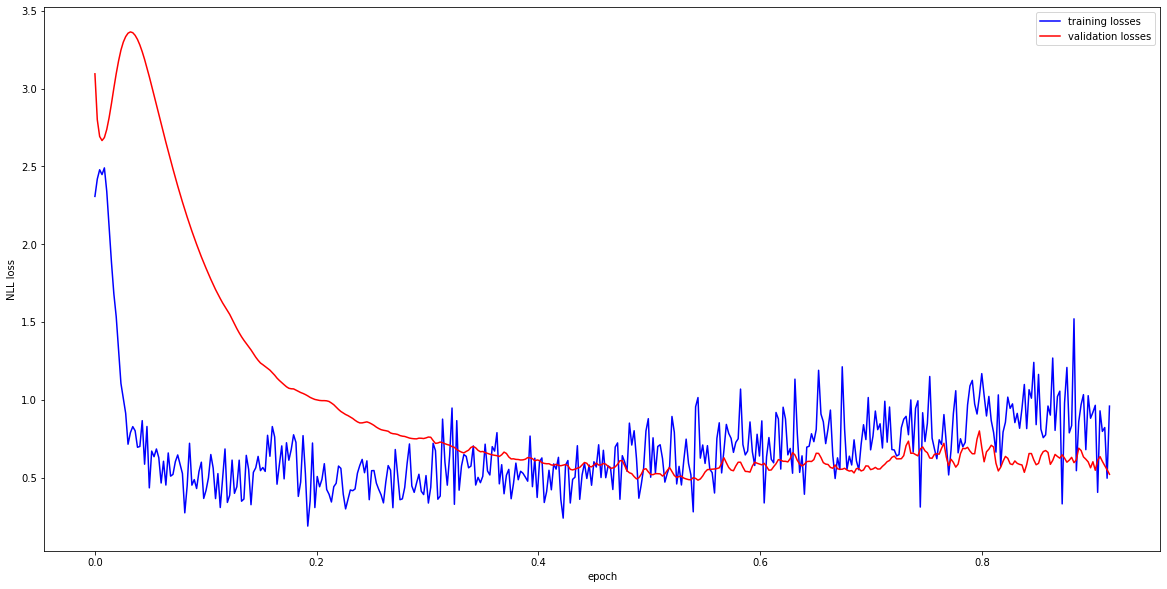

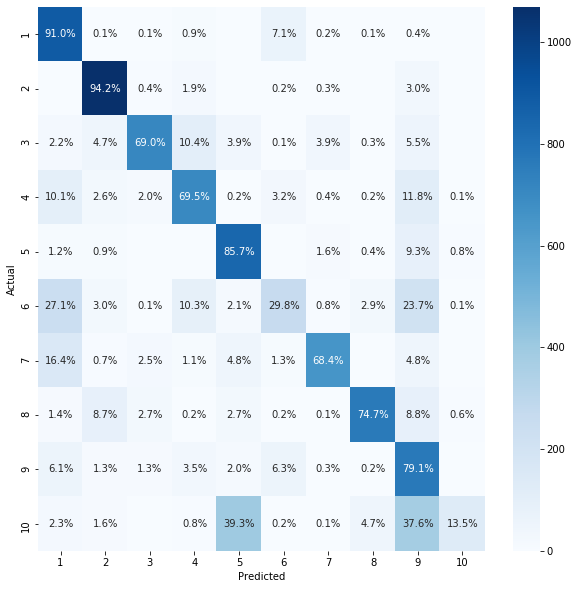

epoch  2 :  0 / 60000  (0 %)  | train loss:2.4618 | val loss:0.9910 | val acc:0.6864 | Time:1.7391
epoch  2 :  128 / 60000  (0 %)  | train loss:2.2018 | val loss:1.0957 | val acc:0.6456 | Time:3.8093
epoch  2 :  256 / 60000  (0 %)  | train loss:2.8480 | val loss:0.9418 | val acc:0.6698 | Time:5.7386
epoch  2 :  384 / 60000  (1 %)  | train loss:2.7316 | val loss:1.0147 | val acc:0.6830 | Time:7.5019
epoch  2 :  512 / 60000  (1 %)  | train loss:2.6556 | val loss:1.3879 | val acc:0.6258 | Time:9.2617
epoch  2 :  640 / 60000  (1 %)  | train loss:3.5574 | val loss:1.5561 | val acc:0.5754 | Time:10.9568
epoch  2 :  768 / 60000  (1 %)  | train loss:2.3144 | val loss:1.1355 | val acc:0.6494 | Time:12.6318
epoch  2 :  896 / 60000  (1 %)  | train loss:1.4336 | val loss:1.3242 | val acc:0.5824 | Time:14.2861
epoch  2 :  1024 / 60000  (2 %)  | train loss:3.2440 | val loss:1.6692 | val acc:0.5206 | Time:16.0703
epoch  2 :  1152 / 60000  (2 %)  | train loss:3.2059 | val loss:1.4046 | val acc:0.5870 

epoch  2 :  10240 / 60000  (17 %)  | train loss:9.0952 | val loss:2.9767 | val acc:0.5806 | Time:141.7050
epoch  2 :  10368 / 60000  (17 %)  | train loss:9.5588 | val loss:3.5831 | val acc:0.4992 | Time:143.2904
epoch  2 :  10496 / 60000  (17 %)  | train loss:10.5887 | val loss:4.4725 | val acc:0.4070 | Time:144.8761
epoch  2 :  10624 / 60000  (18 %)  | train loss:9.3075 | val loss:5.6615 | val acc:0.2778 | Time:146.4943
epoch  2 :  10752 / 60000  (18 %)  | train loss:13.0433 | val loss:4.4736 | val acc:0.4678 | Time:148.1142
epoch  2 :  10880 / 60000  (18 %)  | train loss:10.3234 | val loss:5.6921 | val acc:0.4840 | Time:149.7252
epoch  2 :  11008 / 60000  (18 %)  | train loss:11.5385 | val loss:5.9452 | val acc:0.4714 | Time:151.4689
epoch  2 :  11136 / 60000  (19 %)  | train loss:14.6720 | val loss:5.7441 | val acc:0.3802 | Time:153.0765
epoch  2 :  11264 / 60000  (19 %)  | train loss:16.0178 | val loss:4.3111 | val acc:0.4992 | Time:154.6849
epoch  2 :  11392 / 60000  (19 %)  | tra

epoch  2 :  20224 / 60000  (34 %)  | train loss:6.3422 | val loss:2.3954 | val acc:0.4668 | Time:286.7207
epoch  2 :  20352 / 60000  (34 %)  | train loss:6.0106 | val loss:2.0566 | val acc:0.5220 | Time:288.5240
epoch  2 :  20480 / 60000  (34 %)  | train loss:2.8465 | val loss:2.4277 | val acc:0.5408 | Time:290.5522
epoch  2 :  20608 / 60000  (34 %)  | train loss:7.0906 | val loss:2.5450 | val acc:0.5348 | Time:292.4355
epoch  2 :  20736 / 60000  (35 %)  | train loss:7.6514 | val loss:2.6401 | val acc:0.5098 | Time:294.3547
epoch  2 :  20864 / 60000  (35 %)  | train loss:5.3957 | val loss:1.9277 | val acc:0.5734 | Time:296.2372
epoch  2 :  20992 / 60000  (35 %)  | train loss:3.8900 | val loss:2.2490 | val acc:0.5324 | Time:298.0054
epoch  2 :  21120 / 60000  (35 %)  | train loss:4.8740 | val loss:2.6265 | val acc:0.5592 | Time:299.8587
epoch  2 :  21248 / 60000  (35 %)  | train loss:6.1046 | val loss:2.4454 | val acc:0.5584 | Time:301.7102
epoch  2 :  21376 / 60000  (36 %)  | train los

epoch  2 :  30208 / 60000  (50 %)  | train loss:8.6984 | val loss:4.1211 | val acc:0.4156 | Time:435.4641
epoch  2 :  30336 / 60000  (51 %)  | train loss:9.2543 | val loss:4.0575 | val acc:0.4284 | Time:437.3399
epoch  2 :  30464 / 60000  (51 %)  | train loss:11.3704 | val loss:3.2190 | val acc:0.4546 | Time:439.3554
epoch  2 :  30592 / 60000  (51 %)  | train loss:10.4023 | val loss:3.2577 | val acc:0.4864 | Time:441.2059
epoch  2 :  30720 / 60000  (51 %)  | train loss:5.3195 | val loss:3.7650 | val acc:0.4664 | Time:443.0897
epoch  2 :  30848 / 60000  (51 %)  | train loss:7.5661 | val loss:3.3210 | val acc:0.4626 | Time:445.1360
epoch  2 :  30976 / 60000  (52 %)  | train loss:5.7439 | val loss:1.9031 | val acc:0.5710 | Time:447.1213
epoch  2 :  31104 / 60000  (52 %)  | train loss:3.6730 | val loss:2.5232 | val acc:0.4884 | Time:449.0253
epoch  2 :  31232 / 60000  (52 %)  | train loss:6.1514 | val loss:2.7921 | val acc:0.4466 | Time:450.8867
epoch  2 :  31360 / 60000  (52 %)  | train l

epoch  2 :  40192 / 60000  (67 %)  | train loss:7.4367 | val loss:3.1599 | val acc:0.5128 | Time:597.3537
epoch  2 :  40320 / 60000  (67 %)  | train loss:8.1829 | val loss:3.3828 | val acc:0.4636 | Time:599.6063
epoch  2 :  40448 / 60000  (67 %)  | train loss:11.1110 | val loss:2.8522 | val acc:0.4526 | Time:601.6882
epoch  2 :  40576 / 60000  (68 %)  | train loss:6.8428 | val loss:4.1946 | val acc:0.4248 | Time:603.6594
epoch  2 :  40704 / 60000  (68 %)  | train loss:10.3554 | val loss:4.1142 | val acc:0.3310 | Time:605.6038
epoch  2 :  40832 / 60000  (68 %)  | train loss:12.6036 | val loss:6.4964 | val acc:0.2610 | Time:607.7298
epoch  2 :  40960 / 60000  (68 %)  | train loss:18.5549 | val loss:6.6325 | val acc:0.3930 | Time:609.7799
epoch  2 :  41088 / 60000  (68 %)  | train loss:14.3175 | val loss:7.5991 | val acc:0.3738 | Time:611.8233
epoch  2 :  41216 / 60000  (69 %)  | train loss:18.2640 | val loss:8.3621 | val acc:0.3634 | Time:614.0469
epoch  2 :  41344 / 60000  (69 %)  | tra

epoch  2 :  50048 / 60000  (83 %)  | train loss:93.9426 | val loss:22.0672 | val acc:0.2550 | Time:754.2720
epoch  2 :  50176 / 60000  (84 %)  | train loss:47.6001 | val loss:25.9240 | val acc:0.1836 | Time:756.2024
epoch  2 :  50304 / 60000  (84 %)  | train loss:50.4314 | val loss:26.5392 | val acc:0.2426 | Time:758.1301
epoch  2 :  50432 / 60000  (84 %)  | train loss:66.8538 | val loss:26.7530 | val acc:0.2104 | Time:760.0735
epoch  2 :  50560 / 60000  (84 %)  | train loss:68.2767 | val loss:24.3796 | val acc:0.2312 | Time:761.9931
epoch  2 :  50688 / 60000  (84 %)  | train loss:53.6157 | val loss:23.2214 | val acc:0.2530 | Time:763.9376
epoch  2 :  50816 / 60000  (85 %)  | train loss:43.6385 | val loss:21.5355 | val acc:0.2628 | Time:765.8919
epoch  2 :  50944 / 60000  (85 %)  | train loss:49.0603 | val loss:22.1341 | val acc:0.3300 | Time:767.9459
epoch  2 :  51072 / 60000  (85 %)  | train loss:42.2529 | val loss:20.2870 | val acc:0.3102 | Time:770.1761
epoch  2 :  51200 / 60000  (

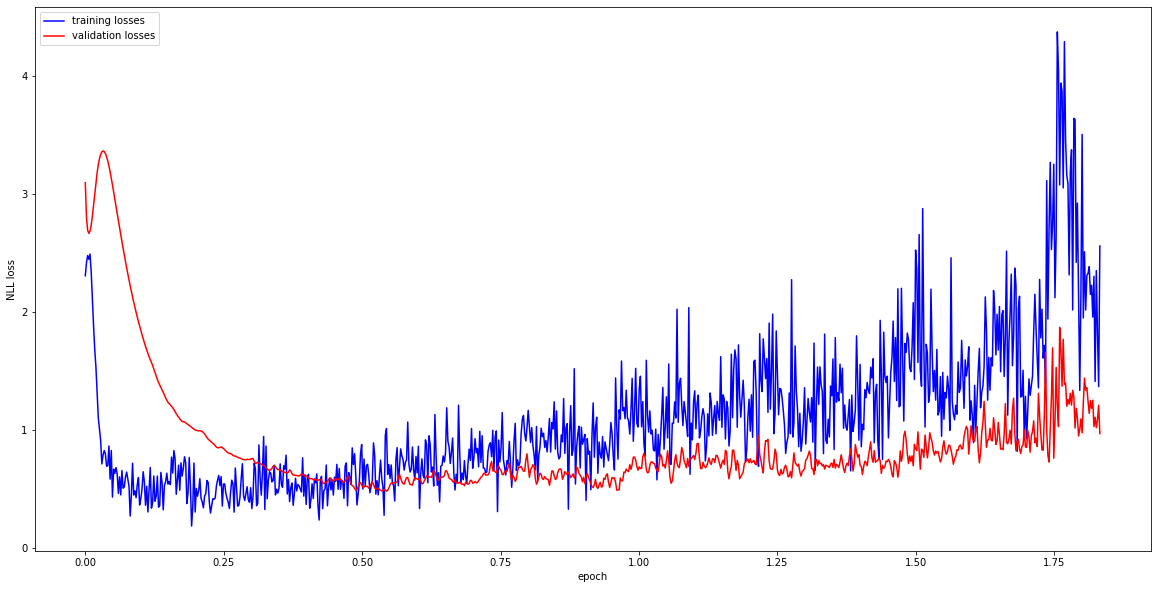

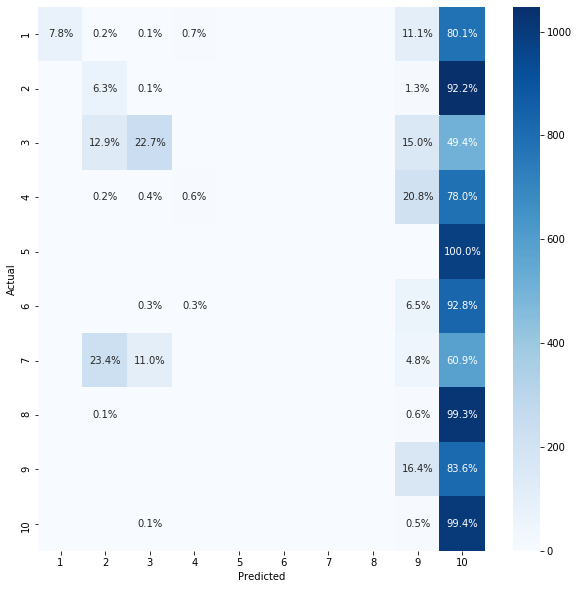

epoch  3 :  0 / 60000  (0 %)  | train loss:40.3187 | val loss:21.1120 | val acc:0.1116 | Time:2.4402
epoch  3 :  128 / 60000  (0 %)  | train loss:42.2824 | val loss:26.9903 | val acc:0.1406 | Time:4.4784
epoch  3 :  256 / 60000  (0 %)  | train loss:50.1709 | val loss:35.8597 | val acc:0.0924 | Time:6.5257
epoch  3 :  384 / 60000  (1 %)  | train loss:70.5512 | val loss:25.9881 | val acc:0.1280 | Time:8.4937
epoch  3 :  512 / 60000  (1 %)  | train loss:60.7107 | val loss:28.7924 | val acc:0.1006 | Time:10.4525
epoch  3 :  640 / 60000  (1 %)  | train loss:67.3062 | val loss:27.9582 | val acc:0.0976 | Time:12.6328
epoch  3 :  768 / 60000  (1 %)  | train loss:56.9299 | val loss:36.9939 | val acc:0.1072 | Time:15.1749
epoch  3 :  896 / 60000  (1 %)  | train loss:67.2689 | val loss:26.2137 | val acc:0.1132 | Time:17.5734
epoch  3 :  1024 / 60000  (2 %)  | train loss:49.3226 | val loss:28.2020 | val acc:0.1142 | Time:19.8963
epoch  3 :  1152 / 60000  (2 %)  | train loss:60.1733 | val loss:24.8

epoch  3 :  9984 / 60000  (17 %)  | train loss:37.2500 | val loss:24.0972 | val acc:0.0964 | Time:171.7775
epoch  3 :  10112 / 60000  (17 %)  | train loss:47.7963 | val loss:34.7632 | val acc:0.1008 | Time:174.3275
epoch  3 :  10240 / 60000  (17 %)  | train loss:77.3756 | val loss:43.9449 | val acc:0.0986 | Time:176.6203
epoch  3 :  10368 / 60000  (17 %)  | train loss:82.2227 | val loss:38.2868 | val acc:0.0924 | Time:179.1171
epoch  3 :  10496 / 60000  (17 %)  | train loss:84.1346 | val loss:27.0140 | val acc:0.1300 | Time:181.3486
epoch  3 :  10624 / 60000  (18 %)  | train loss:54.9663 | val loss:32.1399 | val acc:0.0870 | Time:183.7955
epoch  3 :  10752 / 60000  (18 %)  | train loss:73.4769 | val loss:21.0366 | val acc:0.1116 | Time:186.0872
epoch  3 :  10880 / 60000  (18 %)  | train loss:44.8788 | val loss:19.6124 | val acc:0.1004 | Time:188.2450
epoch  3 :  11008 / 60000  (18 %)  | train loss:35.6192 | val loss:24.1702 | val acc:0.1002 | Time:190.4737
epoch  3 :  11136 / 60000  (1

epoch  3 :  19712 / 60000  (33 %)  | train loss:112.6705 | val loss:52.6549 | val acc:0.1004 | Time:352.4948
epoch  3 :  19840 / 60000  (33 %)  | train loss:126.4514 | val loss:49.3596 | val acc:0.0966 | Time:354.9673
epoch  3 :  19968 / 60000  (33 %)  | train loss:99.2024 | val loss:43.1627 | val acc:0.0992 | Time:357.1933
epoch  3 :  20096 / 60000  (33 %)  | train loss:98.5653 | val loss:46.6826 | val acc:0.1004 | Time:359.8741
epoch  3 :  20224 / 60000  (34 %)  | train loss:101.3393 | val loss:52.1149 | val acc:0.0924 | Time:362.1062
epoch  3 :  20352 / 60000  (34 %)  | train loss:105.3934 | val loss:39.7095 | val acc:0.1010 | Time:364.2691
epoch  3 :  20480 / 60000  (34 %)  | train loss:83.7564 | val loss:56.0413 | val acc:0.1136 | Time:366.4661
epoch  3 :  20608 / 60000  (34 %)  | train loss:120.7684 | val loss:49.1207 | val acc:0.1166 | Time:368.6923
epoch  3 :  20736 / 60000  (35 %)  | train loss:103.4500 | val loss:59.1887 | val acc:0.1650 | Time:370.9051
epoch  3 :  20864 / 60

epoch  3 :  29440 / 60000  (49 %)  | train loss:56.8139 | val loss:36.3967 | val acc:0.1296 | Time:538.0734
epoch  3 :  29568 / 60000  (49 %)  | train loss:70.4552 | val loss:43.2170 | val acc:0.1030 | Time:541.0320
epoch  3 :  29696 / 60000  (49 %)  | train loss:96.2725 | val loss:47.9870 | val acc:0.0994 | Time:543.6602
epoch  3 :  29824 / 60000  (50 %)  | train loss:92.1788 | val loss:44.8360 | val acc:0.1184 | Time:546.1853
epoch  3 :  29952 / 60000  (50 %)  | train loss:90.5450 | val loss:33.3872 | val acc:0.1424 | Time:548.7346
epoch  3 :  30080 / 60000  (50 %)  | train loss:73.3514 | val loss:34.2109 | val acc:0.1138 | Time:551.1820
epoch  3 :  30208 / 60000  (50 %)  | train loss:74.8867 | val loss:35.1526 | val acc:0.0970 | Time:553.7254
epoch  3 :  30336 / 60000  (51 %)  | train loss:74.9751 | val loss:42.2931 | val acc:0.1002 | Time:556.6664
epoch  3 :  30464 / 60000  (51 %)  | train loss:96.8678 | val loss:39.2688 | val acc:0.1130 | Time:559.1987
epoch  3 :  30592 / 60000  (

epoch  3 :  39168 / 60000  (65 %)  | train loss:81.2344 | val loss:48.0313 | val acc:0.0910 | Time:735.5886
epoch  3 :  39296 / 60000  (65 %)  | train loss:103.7024 | val loss:53.3501 | val acc:0.0986 | Time:738.0299
epoch  3 :  39424 / 60000  (66 %)  | train loss:110.7282 | val loss:38.3239 | val acc:0.1788 | Time:740.3743
epoch  3 :  39552 / 60000  (66 %)  | train loss:78.0559 | val loss:39.8910 | val acc:0.1140 | Time:742.8654
epoch  3 :  39680 / 60000  (66 %)  | train loss:90.0179 | val loss:36.5327 | val acc:0.1342 | Time:745.3161
epoch  3 :  39808 / 60000  (66 %)  | train loss:72.4700 | val loss:50.4300 | val acc:0.1100 | Time:747.8731
epoch  3 :  39936 / 60000  (67 %)  | train loss:107.7653 | val loss:39.5571 | val acc:0.1116 | Time:750.2800
epoch  3 :  40064 / 60000  (67 %)  | train loss:72.9232 | val loss:39.9302 | val acc:0.0980 | Time:752.7178
epoch  3 :  40192 / 60000  (67 %)  | train loss:95.2618 | val loss:38.6414 | val acc:0.1094 | Time:755.0760
epoch  3 :  40320 / 60000

epoch  3 :  48896 / 60000  (81 %)  | train loss:95.2451 | val loss:59.9831 | val acc:0.1170 | Time:937.8393
epoch  3 :  49024 / 60000  (82 %)  | train loss:129.7218 | val loss:70.8447 | val acc:0.1002 | Time:940.4944
epoch  3 :  49152 / 60000  (82 %)  | train loss:146.2808 | val loss:61.3265 | val acc:0.1446 | Time:943.0440
epoch  3 :  49280 / 60000  (82 %)  | train loss:139.2088 | val loss:52.3031 | val acc:0.1160 | Time:945.5451
epoch  3 :  49408 / 60000  (82 %)  | train loss:110.1477 | val loss:51.3944 | val acc:0.1110 | Time:948.0684
epoch  3 :  49536 / 60000  (83 %)  | train loss:98.2577 | val loss:43.1298 | val acc:0.0928 | Time:950.6061
epoch  3 :  49664 / 60000  (83 %)  | train loss:100.0164 | val loss:38.7102 | val acc:0.1192 | Time:953.2119
epoch  3 :  49792 / 60000  (83 %)  | train loss:73.2080 | val loss:40.3288 | val acc:0.1094 | Time:955.8435
epoch  3 :  49920 / 60000  (83 %)  | train loss:79.8178 | val loss:32.6742 | val acc:0.1054 | Time:958.5448
epoch  3 :  50048 / 600

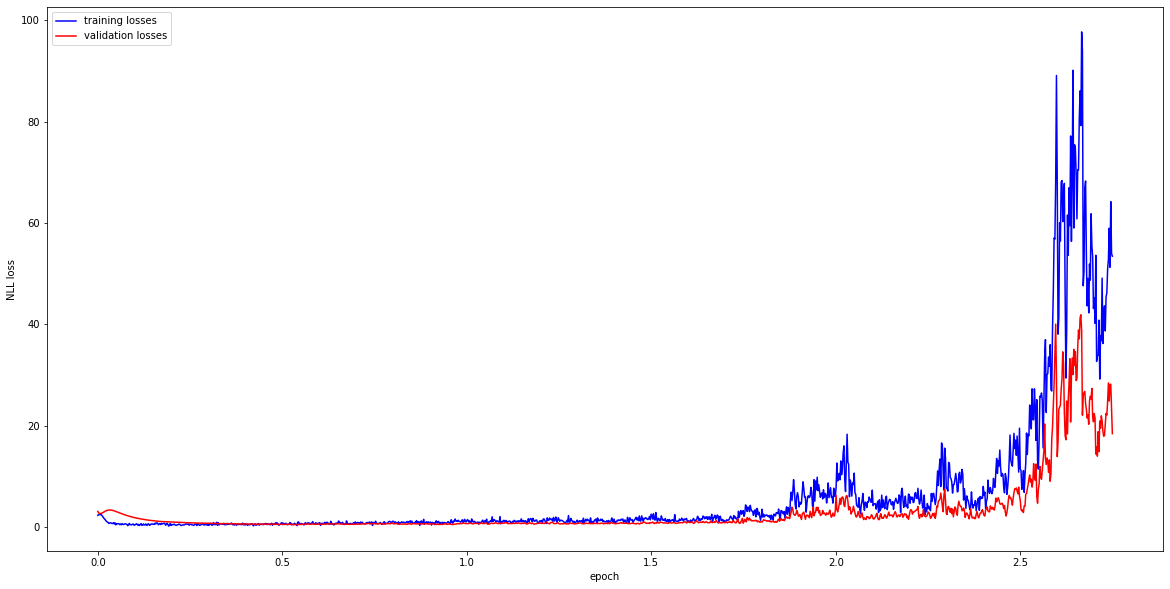

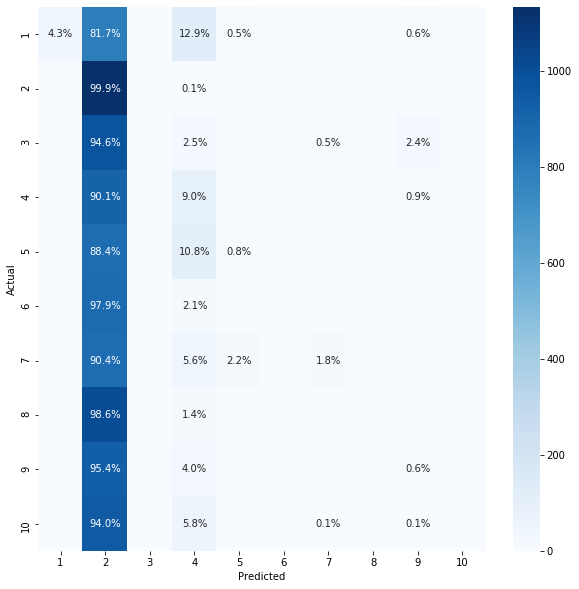

epoch  4 :  0 / 60000  (0 %)  | train loss:67.6357 | val loss:32.7146 | val acc:0.1258 | Time:2.4916
epoch  4 :  128 / 60000  (0 %)  | train loss:65.1817 | val loss:40.3827 | val acc:0.1112 | Time:4.8276
epoch  4 :  256 / 60000  (0 %)  | train loss:81.5268 | val loss:32.8223 | val acc:0.1284 | Time:7.2156
epoch  4 :  384 / 60000  (1 %)  | train loss:54.1414 | val loss:39.2120 | val acc:0.1192 | Time:9.6457
epoch  4 :  512 / 60000  (1 %)  | train loss:97.3193 | val loss:46.0161 | val acc:0.1138 | Time:12.0344
epoch  4 :  640 / 60000  (1 %)  | train loss:96.6043 | val loss:46.8533 | val acc:0.1078 | Time:14.4794
epoch  4 :  768 / 60000  (1 %)  | train loss:109.0550 | val loss:40.0272 | val acc:0.1270 | Time:16.8907
epoch  4 :  896 / 60000  (1 %)  | train loss:77.1404 | val loss:47.1867 | val acc:0.1128 | Time:19.2307
epoch  4 :  1024 / 60000  (2 %)  | train loss:100.4875 | val loss:33.9821 | val acc:0.1224 | Time:21.8245
epoch  4 :  1152 / 60000  (2 %)  | train loss:74.6264 | val loss:27

epoch  4 :  9984 / 60000  (17 %)  | train loss:36.9160 | val loss:23.6908 | val acc:0.2970 | Time:199.7079
epoch  4 :  10112 / 60000  (17 %)  | train loss:40.4072 | val loss:27.9575 | val acc:0.1918 | Time:202.1315
epoch  4 :  10240 / 60000  (17 %)  | train loss:60.9218 | val loss:39.5038 | val acc:0.1208 | Time:204.5498
epoch  4 :  10368 / 60000  (17 %)  | train loss:84.8679 | val loss:38.9909 | val acc:0.1476 | Time:207.0133
epoch  4 :  10496 / 60000  (17 %)  | train loss:79.7474 | val loss:29.9893 | val acc:0.2036 | Time:209.4252
epoch  4 :  10624 / 60000  (18 %)  | train loss:63.5804 | val loss:26.1863 | val acc:0.1728 | Time:211.8021
epoch  4 :  10752 / 60000  (18 %)  | train loss:42.8131 | val loss:15.5466 | val acc:0.2636 | Time:214.3867
epoch  4 :  10880 / 60000  (18 %)  | train loss:41.2514 | val loss:9.9184 | val acc:0.2630 | Time:216.7724
epoch  4 :  11008 / 60000  (18 %)  | train loss:22.4794 | val loss:10.2148 | val acc:0.2830 | Time:219.3681
epoch  4 :  11136 / 60000  (19

epoch  4 :  19712 / 60000  (33 %)  | train loss:93.9254 | val loss:50.5539 | val acc:0.1324 | Time:411.1614
epoch  4 :  19840 / 60000  (33 %)  | train loss:119.0868 | val loss:40.7151 | val acc:0.1624 | Time:414.2118
epoch  4 :  19968 / 60000  (33 %)  | train loss:91.3563 | val loss:54.4796 | val acc:0.1150 | Time:417.2583
epoch  4 :  20096 / 60000  (33 %)  | train loss:113.6986 | val loss:53.6258 | val acc:0.1280 | Time:419.9703
epoch  4 :  20224 / 60000  (34 %)  | train loss:123.7374 | val loss:56.5578 | val acc:0.1340 | Time:422.7310
epoch  4 :  20352 / 60000  (34 %)  | train loss:137.4963 | val loss:48.5755 | val acc:0.1664 | Time:425.6697
epoch  4 :  20480 / 60000  (34 %)  | train loss:93.6427 | val loss:48.8470 | val acc:0.1716 | Time:429.0589
epoch  4 :  20608 / 60000  (34 %)  | train loss:92.9721 | val loss:53.5669 | val acc:0.1336 | Time:432.8409
epoch  4 :  20736 / 60000  (35 %)  | train loss:99.4006 | val loss:55.9066 | val acc:0.1238 | Time:436.1613
epoch  4 :  20864 / 6000

epoch  4 :  29440 / 60000  (49 %)  | train loss:70.3923 | val loss:31.9008 | val acc:0.2074 | Time:629.6811
epoch  4 :  29568 / 60000  (49 %)  | train loss:65.2295 | val loss:37.4824 | val acc:0.2052 | Time:632.4203
epoch  4 :  29696 / 60000  (49 %)  | train loss:84.5099 | val loss:45.1743 | val acc:0.1672 | Time:635.1324
epoch  4 :  29824 / 60000  (50 %)  | train loss:98.4982 | val loss:50.4655 | val acc:0.1390 | Time:637.8490
epoch  4 :  29952 / 60000  (50 %)  | train loss:114.0812 | val loss:34.0152 | val acc:0.1996 | Time:640.8063
epoch  4 :  30080 / 60000  (50 %)  | train loss:79.6798 | val loss:47.7339 | val acc:0.1230 | Time:643.6214
epoch  4 :  30208 / 60000  (50 %)  | train loss:105.4502 | val loss:38.9480 | val acc:0.1302 | Time:646.3948
epoch  4 :  30336 / 60000  (51 %)  | train loss:75.6699 | val loss:42.2915 | val acc:0.1344 | Time:649.2676
epoch  4 :  30464 / 60000  (51 %)  | train loss:97.9746 | val loss:44.8395 | val acc:0.1210 | Time:652.1468
epoch  4 :  30592 / 60000 

epoch  4 :  39168 / 60000  (65 %)  | train loss:130.8974 | val loss:50.2765 | val acc:0.1462 | Time:849.6531
epoch  4 :  39296 / 60000  (65 %)  | train loss:106.0929 | val loss:54.6337 | val acc:0.1136 | Time:852.3121
epoch  4 :  39424 / 60000  (66 %)  | train loss:102.8786 | val loss:50.3890 | val acc:0.1200 | Time:855.1367
epoch  4 :  39552 / 60000  (66 %)  | train loss:96.8348 | val loss:58.7700 | val acc:0.0902 | Time:857.8361
epoch  4 :  39680 / 60000  (66 %)  | train loss:129.5741 | val loss:49.1366 | val acc:0.1330 | Time:860.5473
epoch  4 :  39808 / 60000  (66 %)  | train loss:103.8259 | val loss:49.5033 | val acc:0.1368 | Time:863.2152
epoch  4 :  39936 / 60000  (67 %)  | train loss:106.5916 | val loss:51.9269 | val acc:0.1966 | Time:865.8887
epoch  4 :  40064 / 60000  (67 %)  | train loss:118.8689 | val loss:51.6221 | val acc:0.1640 | Time:868.5755
epoch  4 :  40192 / 60000  (67 %)  | train loss:105.1707 | val loss:55.5578 | val acc:0.1536 | Time:871.2769
epoch  4 :  40320 / 

epoch  4 :  48896 / 60000  (81 %)  | train loss:72.8200 | val loss:45.8497 | val acc:0.2050 | Time:1064.1506
epoch  4 :  49024 / 60000  (82 %)  | train loss:102.9223 | val loss:46.2506 | val acc:0.1252 | Time:1066.8614
epoch  4 :  49152 / 60000  (82 %)  | train loss:91.2511 | val loss:28.9454 | val acc:0.2362 | Time:1069.9706
epoch  4 :  49280 / 60000  (82 %)  | train loss:56.8898 | val loss:24.1166 | val acc:0.2616 | Time:1073.3709
epoch  4 :  49408 / 60000  (82 %)  | train loss:48.3027 | val loss:30.0103 | val acc:0.1936 | Time:1076.2535
epoch  4 :  49536 / 60000  (83 %)  | train loss:64.9676 | val loss:31.7204 | val acc:0.2092 | Time:1079.0695
epoch  4 :  49664 / 60000  (83 %)  | train loss:66.5577 | val loss:43.4276 | val acc:0.1526 | Time:1081.8842
epoch  4 :  49792 / 60000  (83 %)  | train loss:99.2788 | val loss:50.1877 | val acc:0.0896 | Time:1084.6251
epoch  4 :  49920 / 60000  (83 %)  | train loss:94.5967 | val loss:38.3680 | val acc:0.1900 | Time:1087.3460
epoch  4 :  50048 

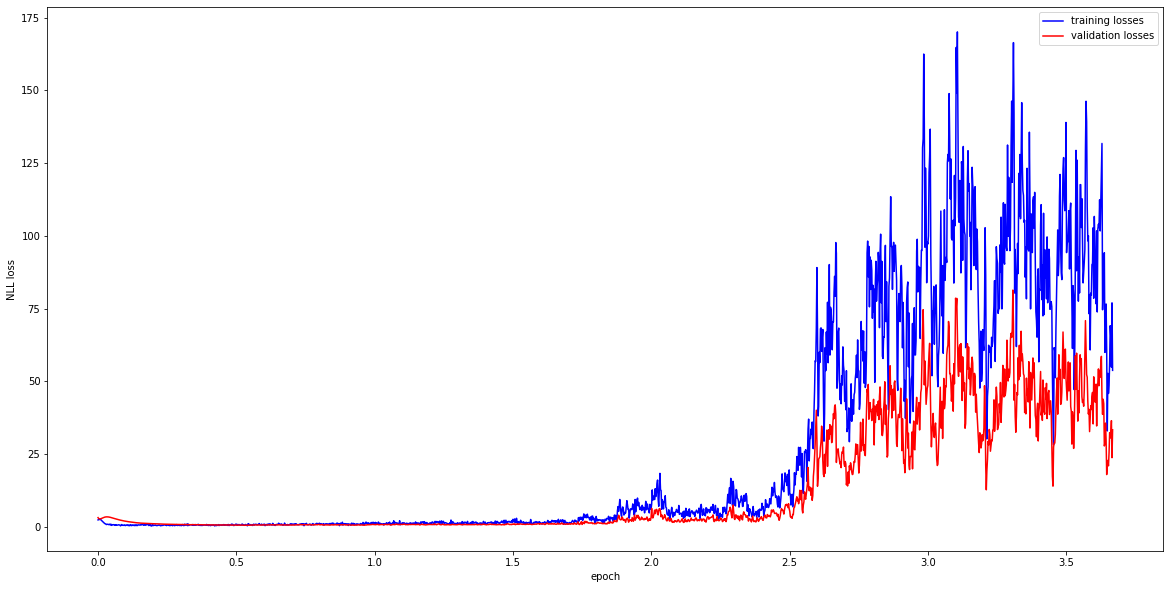

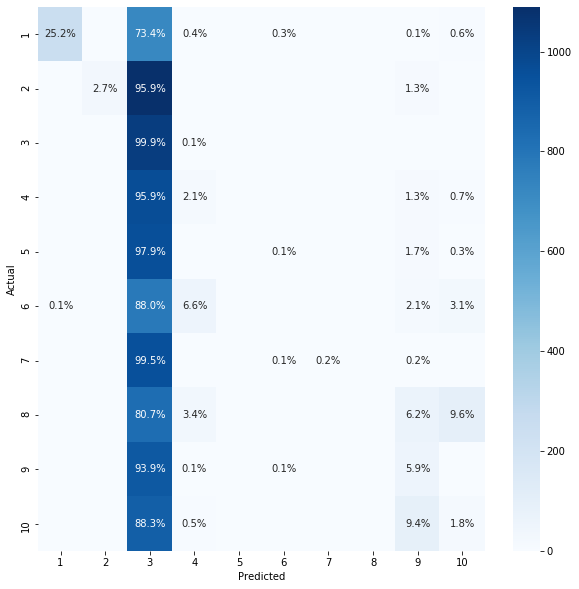

epoch  5 :  0 / 60000  (0 %)  | train loss:101.8601 | val loss:32.0581 | val acc:0.1702 | Time:3.0938
epoch  5 :  128 / 60000  (0 %)  | train loss:80.8856 | val loss:40.1878 | val acc:0.0952 | Time:5.9800
epoch  5 :  256 / 60000  (0 %)  | train loss:78.3047 | val loss:49.5036 | val acc:0.0900 | Time:8.9319
epoch  5 :  384 / 60000  (1 %)  | train loss:107.7831 | val loss:44.8543 | val acc:0.1986 | Time:13.0805
epoch  5 :  512 / 60000  (1 %)  | train loss:95.0917 | val loss:45.7678 | val acc:0.2096 | Time:17.0606
epoch  5 :  640 / 60000  (1 %)  | train loss:103.7773 | val loss:51.4200 | val acc:0.2184 | Time:21.5558
epoch  5 :  768 / 60000  (1 %)  | train loss:93.2839 | val loss:58.2525 | val acc:0.1994 | Time:25.6664
epoch  5 :  896 / 60000  (1 %)  | train loss:117.8128 | val loss:59.6080 | val acc:0.2174 | Time:30.1404
epoch  5 :  1024 / 60000  (2 %)  | train loss:127.8665 | val loss:68.0133 | val acc:0.1696 | Time:34.0799
epoch  5 :  1152 / 60000  (2 %)  | train loss:140.8201 | val lo

epoch  5 :  9856 / 60000  (16 %)  | train loss:66.7743 | val loss:35.1203 | val acc:0.1054 | Time:252.5497
epoch  5 :  9984 / 60000  (17 %)  | train loss:103.2029 | val loss:36.8418 | val acc:0.1304 | Time:255.8044
epoch  5 :  10112 / 60000  (17 %)  | train loss:61.4264 | val loss:47.4793 | val acc:0.1000 | Time:258.9657
epoch  5 :  10240 / 60000  (17 %)  | train loss:105.0540 | val loss:56.0022 | val acc:0.0924 | Time:262.1910
epoch  5 :  10368 / 60000  (17 %)  | train loss:99.0357 | val loss:58.8548 | val acc:0.0894 | Time:265.2823
epoch  5 :  10496 / 60000  (17 %)  | train loss:110.9804 | val loss:42.8851 | val acc:0.1036 | Time:268.2651
epoch  5 :  10624 / 60000  (18 %)  | train loss:73.6227 | val loss:44.4875 | val acc:0.1616 | Time:271.2404
epoch  5 :  10752 / 60000  (18 %)  | train loss:98.8585 | val loss:47.8863 | val acc:0.1342 | Time:274.4232
epoch  5 :  10880 / 60000  (18 %)  | train loss:112.8546 | val loss:48.9676 | val acc:0.1240 | Time:277.6463
epoch  5 :  11008 / 60000 

epoch  5 :  19584 / 60000  (33 %)  | train loss:113.5459 | val loss:66.0777 | val acc:0.0924 | Time:500.9080
epoch  5 :  19712 / 60000  (33 %)  | train loss:127.1287 | val loss:61.0564 | val acc:0.1418 | Time:504.4282
epoch  5 :  19840 / 60000  (33 %)  | train loss:118.9056 | val loss:56.3235 | val acc:0.1356 | Time:507.6304
epoch  5 :  19968 / 60000  (33 %)  | train loss:114.8838 | val loss:41.5814 | val acc:0.0966 | Time:510.6741
epoch  5 :  20096 / 60000  (33 %)  | train loss:87.4023 | val loss:21.9438 | val acc:0.2146 | Time:513.9731
epoch  5 :  20224 / 60000  (34 %)  | train loss:53.1744 | val loss:32.8119 | val acc:0.1186 | Time:517.6147
epoch  5 :  20352 / 60000  (34 %)  | train loss:73.2777 | val loss:46.3022 | val acc:0.1328 | Time:521.2559
epoch  5 :  20480 / 60000  (34 %)  | train loss:108.5789 | val loss:41.2733 | val acc:0.1592 | Time:524.8234
epoch  5 :  20608 / 60000  (34 %)  | train loss:96.2539 | val loss:51.0929 | val acc:0.1302 | Time:528.6232
epoch  5 :  20736 / 600

epoch  5 :  29312 / 60000  (49 %)  | train loss:97.5354 | val loss:52.6439 | val acc:0.1124 | Time:764.8323
epoch  5 :  29440 / 60000  (49 %)  | train loss:98.8928 | val loss:64.5036 | val acc:0.1088 | Time:767.9884
epoch  5 :  29568 / 60000  (49 %)  | train loss:125.7527 | val loss:72.3952 | val acc:0.1156 | Time:771.2979
epoch  5 :  29696 / 60000  (49 %)  | train loss:149.3373 | val loss:72.2606 | val acc:0.1128 | Time:774.7804
epoch  5 :  29824 / 60000  (50 %)  | train loss:136.0931 | val loss:60.6844 | val acc:0.1302 | Time:778.5256
epoch  5 :  29952 / 60000  (50 %)  | train loss:131.1502 | val loss:56.3070 | val acc:0.1144 | Time:782.8430
epoch  5 :  30080 / 60000  (50 %)  | train loss:101.9725 | val loss:53.5008 | val acc:0.1022 | Time:786.3013
epoch  5 :  30208 / 60000  (50 %)  | train loss:129.4071 | val loss:50.8053 | val acc:0.1382 | Time:790.0089
epoch  5 :  30336 / 60000  (51 %)  | train loss:100.8654 | val loss:54.5192 | val acc:0.1608 | Time:793.3067
epoch  5 :  30464 / 6

epoch  5 :  39040 / 60000  (65 %)  | train loss:54.3859 | val loss:26.1415 | val acc:0.2520 | Time:1025.9234
epoch  5 :  39168 / 60000  (65 %)  | train loss:53.1354 | val loss:24.5138 | val acc:0.1972 | Time:1028.9394
epoch  5 :  39296 / 60000  (65 %)  | train loss:56.2046 | val loss:19.5068 | val acc:0.2226 | Time:1031.9654
epoch  5 :  39424 / 60000  (66 %)  | train loss:41.8876 | val loss:25.1236 | val acc:0.1630 | Time:1034.9549
epoch  5 :  39552 / 60000  (66 %)  | train loss:67.4734 | val loss:23.2849 | val acc:0.2080 | Time:1037.9977
epoch  5 :  39680 / 60000  (66 %)  | train loss:67.7838 | val loss:18.8806 | val acc:0.2360 | Time:1041.0279
epoch  5 :  39808 / 60000  (66 %)  | train loss:49.7275 | val loss:24.7651 | val acc:0.1780 | Time:1044.0367
epoch  5 :  39936 / 60000  (67 %)  | train loss:46.7106 | val loss:18.6131 | val acc:0.2416 | Time:1047.2433
epoch  5 :  40064 / 60000  (67 %)  | train loss:38.2855 | val loss:21.2863 | val acc:0.2382 | Time:1050.3736
epoch  5 :  40192 /

epoch  5 :  48768 / 60000  (81 %)  | train loss:44.9019 | val loss:25.1287 | val acc:0.1754 | Time:1294.5929
epoch  5 :  48896 / 60000  (81 %)  | train loss:55.9939 | val loss:29.8818 | val acc:0.1562 | Time:1298.0376
epoch  5 :  49024 / 60000  (82 %)  | train loss:64.2339 | val loss:36.5424 | val acc:0.1482 | Time:1302.0223
epoch  5 :  49152 / 60000  (82 %)  | train loss:83.3210 | val loss:25.6231 | val acc:0.1794 | Time:1305.8986
epoch  5 :  49280 / 60000  (82 %)  | train loss:54.0739 | val loss:26.9000 | val acc:0.1982 | Time:1309.6808
epoch  5 :  49408 / 60000  (82 %)  | train loss:61.5678 | val loss:31.3857 | val acc:0.1930 | Time:1313.0780
epoch  5 :  49536 / 60000  (83 %)  | train loss:69.5532 | val loss:38.2961 | val acc:0.1730 | Time:1316.5050
epoch  5 :  49664 / 60000  (83 %)  | train loss:79.0954 | val loss:45.7197 | val acc:0.1004 | Time:1319.6662
epoch  5 :  49792 / 60000  (83 %)  | train loss:89.4946 | val loss:31.2289 | val acc:0.1366 | Time:1322.8898
epoch  5 :  49920 /

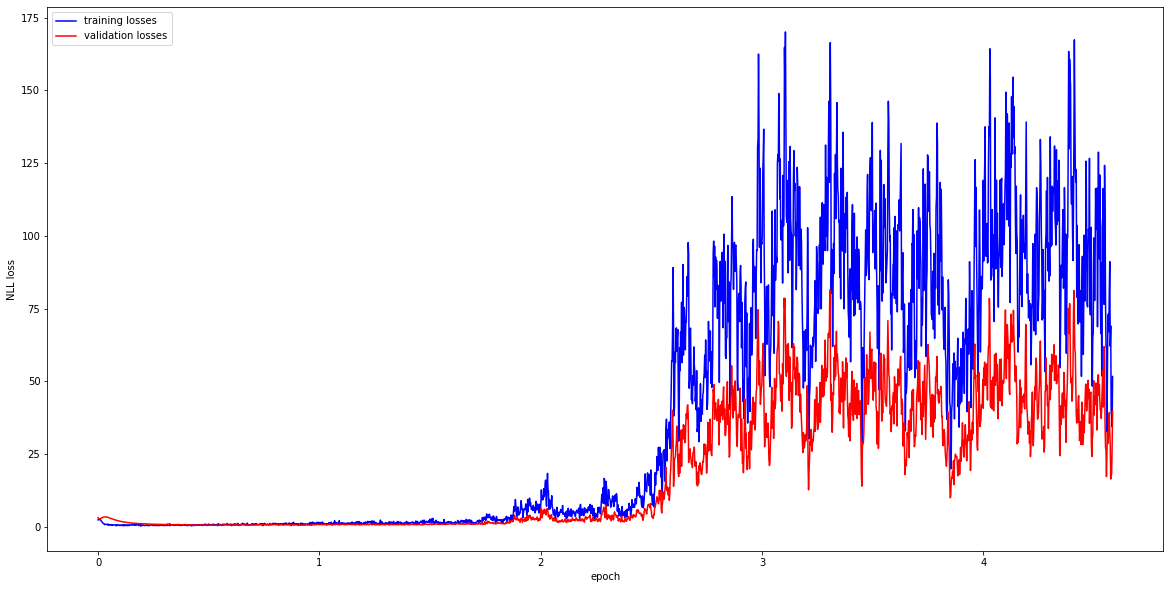

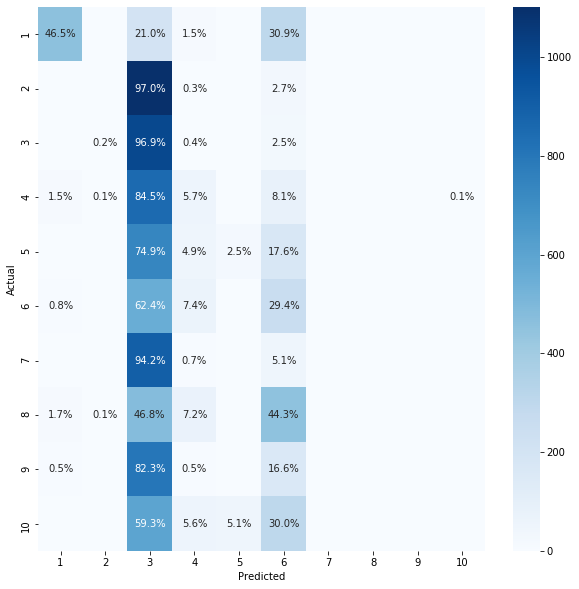

epoch  6 :  0 / 60000  (0 %)  | train loss:48.7013 | val loss:28.1727 | val acc:0.0934 | Time:3.4788
epoch  6 :  128 / 60000  (0 %)  | train loss:56.5371 | val loss:18.0990 | val acc:0.2206 | Time:7.7289
epoch  6 :  256 / 60000  (0 %)  | train loss:31.4246 | val loss:17.3201 | val acc:0.2332 | Time:11.9431
epoch  6 :  384 / 60000  (1 %)  | train loss:34.5468 | val loss:18.7053 | val acc:0.2092 | Time:15.6930
epoch  6 :  512 / 60000  (1 %)  | train loss:34.4945 | val loss:19.1461 | val acc:0.2784 | Time:18.8955
epoch  6 :  640 / 60000  (1 %)  | train loss:37.2518 | val loss:21.1282 | val acc:0.2224 | Time:22.1212
epoch  6 :  768 / 60000  (1 %)  | train loss:47.6389 | val loss:31.2391 | val acc:0.2154 | Time:25.2934
epoch  6 :  896 / 60000  (1 %)  | train loss:71.7144 | val loss:26.7641 | val acc:0.1844 | Time:28.4373
epoch  6 :  1024 / 60000  (2 %)  | train loss:57.0068 | val loss:29.8645 | val acc:0.2118 | Time:31.6166
epoch  6 :  1152 / 60000  (2 %)  | train loss:64.1777 | val loss:26

epoch  6 :  9984 / 60000  (17 %)  | train loss:52.7786 | val loss:26.1343 | val acc:0.2352 | Time:273.4768
epoch  6 :  10112 / 60000  (17 %)  | train loss:51.3935 | val loss:26.5608 | val acc:0.2068 | Time:276.7518
epoch  6 :  10240 / 60000  (17 %)  | train loss:50.1119 | val loss:29.5580 | val acc:0.1552 | Time:279.9725
epoch  6 :  10368 / 60000  (17 %)  | train loss:62.8602 | val loss:30.5891 | val acc:0.1572 | Time:283.1634
epoch  6 :  10496 / 60000  (17 %)  | train loss:71.4111 | val loss:26.6940 | val acc:0.1324 | Time:286.3959
epoch  6 :  10624 / 60000  (18 %)  | train loss:55.2090 | val loss:29.3716 | val acc:0.1386 | Time:289.6192
epoch  6 :  10752 / 60000  (18 %)  | train loss:56.9175 | val loss:37.6663 | val acc:0.1396 | Time:292.8823
epoch  6 :  10880 / 60000  (18 %)  | train loss:75.3442 | val loss:30.2910 | val acc:0.1638 | Time:296.1854
epoch  6 :  11008 / 60000  (18 %)  | train loss:54.4531 | val loss:32.4294 | val acc:0.1250 | Time:299.3766
epoch  6 :  11136 / 60000  (1

epoch  6 :  19712 / 60000  (33 %)  | train loss:67.2400 | val loss:33.8948 | val acc:0.1246 | Time:532.0056
epoch  6 :  19840 / 60000  (33 %)  | train loss:58.0595 | val loss:41.8697 | val acc:0.1396 | Time:535.4986
epoch  6 :  19968 / 60000  (33 %)  | train loss:73.9303 | val loss:50.6494 | val acc:0.1170 | Time:539.0232
epoch  6 :  20096 / 60000  (33 %)  | train loss:98.9203 | val loss:65.2783 | val acc:0.1100 | Time:542.5929
epoch  6 :  20224 / 60000  (34 %)  | train loss:143.3762 | val loss:62.1206 | val acc:0.1690 | Time:546.2730
epoch  6 :  20352 / 60000  (34 %)  | train loss:122.5528 | val loss:70.1195 | val acc:0.1394 | Time:549.6621
epoch  6 :  20480 / 60000  (34 %)  | train loss:146.9677 | val loss:67.8813 | val acc:0.1286 | Time:552.9247
epoch  6 :  20608 / 60000  (34 %)  | train loss:135.2908 | val loss:53.9307 | val acc:0.1804 | Time:556.1902
epoch  6 :  20736 / 60000  (35 %)  | train loss:99.3556 | val loss:61.9448 | val acc:0.0986 | Time:559.7321
epoch  6 :  20864 / 6000

epoch  6 :  29440 / 60000  (49 %)  | train loss:120.7212 | val loss:71.7371 | val acc:0.1010 | Time:795.0709
epoch  6 :  29568 / 60000  (49 %)  | train loss:149.3148 | val loss:57.1964 | val acc:0.1278 | Time:798.4113
epoch  6 :  29696 / 60000  (49 %)  | train loss:101.4633 | val loss:65.2058 | val acc:0.1154 | Time:801.8026
epoch  6 :  29824 / 60000  (50 %)  | train loss:125.6074 | val loss:50.5984 | val acc:0.1566 | Time:805.5389
epoch  6 :  29952 / 60000  (50 %)  | train loss:99.3889 | val loss:64.8897 | val acc:0.1164 | Time:808.9737
epoch  6 :  30080 / 60000  (50 %)  | train loss:114.7123 | val loss:63.9135 | val acc:0.1286 | Time:812.4733
epoch  6 :  30208 / 60000  (50 %)  | train loss:122.0655 | val loss:68.0428 | val acc:0.1046 | Time:815.7941
epoch  6 :  30336 / 60000  (51 %)  | train loss:130.9306 | val loss:61.5242 | val acc:0.1068 | Time:819.1500
epoch  6 :  30464 / 60000  (51 %)  | train loss:137.7186 | val loss:47.1313 | val acc:0.1274 | Time:822.6868
epoch  6 :  30592 / 

epoch  6 :  39168 / 60000  (65 %)  | train loss:42.2587 | val loss:25.9395 | val acc:0.1260 | Time:1061.7968
epoch  6 :  39296 / 60000  (65 %)  | train loss:57.5119 | val loss:27.3425 | val acc:0.1608 | Time:1065.1918
epoch  6 :  39424 / 60000  (66 %)  | train loss:60.3299 | val loss:19.3558 | val acc:0.2202 | Time:1068.5920
epoch  6 :  39552 / 60000  (66 %)  | train loss:32.7898 | val loss:30.8573 | val acc:0.1376 | Time:1071.9811
epoch  6 :  39680 / 60000  (66 %)  | train loss:65.3451 | val loss:38.9310 | val acc:0.1132 | Time:1075.3973
epoch  6 :  39808 / 60000  (66 %)  | train loss:77.3520 | val loss:28.6754 | val acc:0.1520 | Time:1078.7877
epoch  6 :  39936 / 60000  (67 %)  | train loss:55.6124 | val loss:31.7223 | val acc:0.1040 | Time:1082.1457
epoch  6 :  40064 / 60000  (67 %)  | train loss:67.2843 | val loss:39.3615 | val acc:0.0956 | Time:1085.5382
epoch  6 :  40192 / 60000  (67 %)  | train loss:83.8920 | val loss:23.5071 | val acc:0.1068 | Time:1089.2114
epoch  6 :  40320 /

epoch  6 :  48896 / 60000  (81 %)  | train loss:83.0475 | val loss:40.5393 | val acc:0.1134 | Time:1334.9965
epoch  6 :  49024 / 60000  (82 %)  | train loss:75.8990 | val loss:36.4917 | val acc:0.1614 | Time:1338.4364
epoch  6 :  49152 / 60000  (82 %)  | train loss:71.3684 | val loss:33.1293 | val acc:0.1144 | Time:1341.9600
epoch  6 :  49280 / 60000  (82 %)  | train loss:62.1866 | val loss:30.6329 | val acc:0.1548 | Time:1345.4120
epoch  6 :  49408 / 60000  (82 %)  | train loss:60.9795 | val loss:20.4049 | val acc:0.1888 | Time:1348.8908
epoch  6 :  49536 / 60000  (83 %)  | train loss:40.9508 | val loss:27.4044 | val acc:0.1738 | Time:1352.3975
epoch  6 :  49664 / 60000  (83 %)  | train loss:49.0181 | val loss:29.8437 | val acc:0.2074 | Time:1355.8715
epoch  6 :  49792 / 60000  (83 %)  | train loss:64.6965 | val loss:29.2890 | val acc:0.2060 | Time:1359.3249
epoch  6 :  49920 / 60000  (83 %)  | train loss:57.6497 | val loss:34.2223 | val acc:0.1562 | Time:1362.7611
epoch  6 :  50048 /

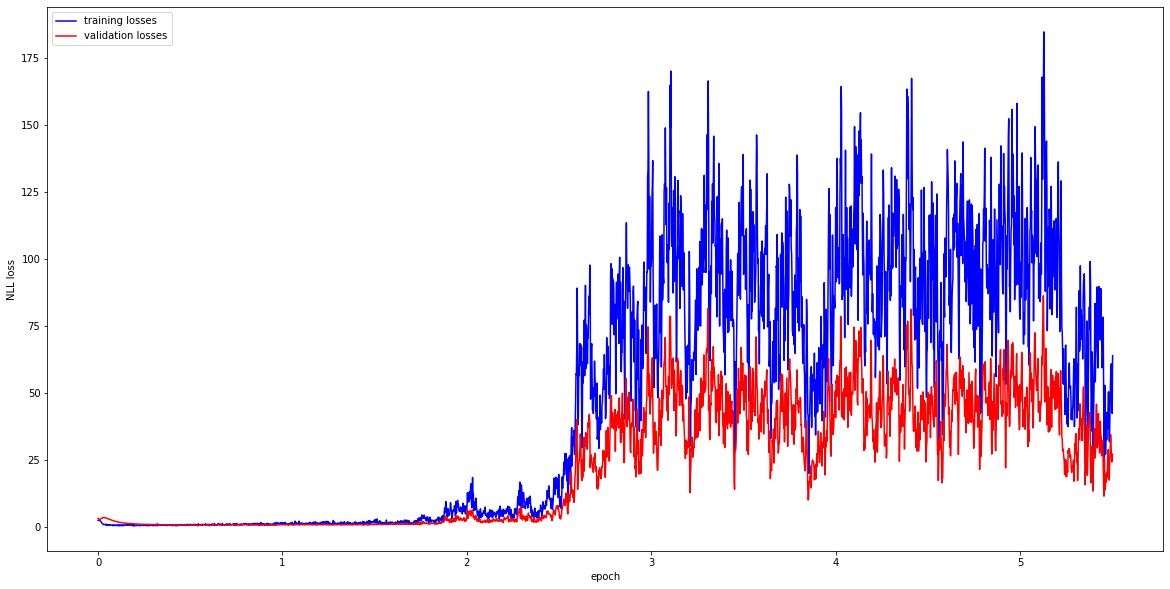

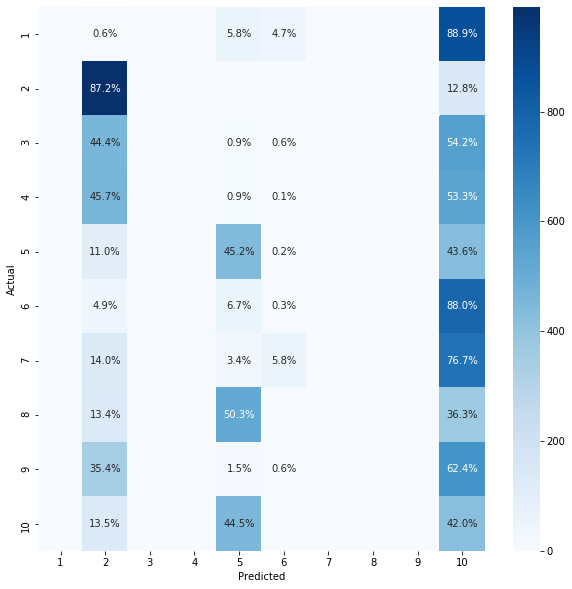

epoch  7 :  0 / 60000  (0 %)  | train loss:88.6774 | val loss:48.0645 | val acc:0.1570 | Time:4.4136
epoch  7 :  128 / 60000  (0 %)  | train loss:103.7565 | val loss:58.1120 | val acc:0.1146 | Time:8.6036
epoch  7 :  256 / 60000  (0 %)  | train loss:115.9585 | val loss:52.3028 | val acc:0.1412 | Time:12.7915
epoch  7 :  384 / 60000  (1 %)  | train loss:94.0355 | val loss:58.0130 | val acc:0.1400 | Time:17.2787
epoch  7 :  512 / 60000  (1 %)  | train loss:126.3212 | val loss:78.9398 | val acc:0.1076 | Time:21.2131
epoch  7 :  640 / 60000  (1 %)  | train loss:154.8596 | val loss:70.7188 | val acc:0.1048 | Time:25.1016
epoch  7 :  768 / 60000  (1 %)  | train loss:135.2130 | val loss:67.1382 | val acc:0.1000 | Time:28.9964
epoch  7 :  896 / 60000  (1 %)  | train loss:141.7232 | val loss:80.2601 | val acc:0.1034 | Time:32.5089
epoch  7 :  1024 / 60000  (2 %)  | train loss:151.3487 | val loss:68.4657 | val acc:0.1032 | Time:36.0116
epoch  7 :  1152 / 60000  (2 %)  | train loss:122.8260 | val

epoch  7 :  9984 / 60000  (17 %)  | train loss:116.5529 | val loss:65.3954 | val acc:0.1032 | Time:428.6313
epoch  7 :  10112 / 60000  (17 %)  | train loss:128.2327 | val loss:62.9319 | val acc:0.0878 | Time:435.9511
epoch  7 :  10240 / 60000  (17 %)  | train loss:126.8931 | val loss:60.3530 | val acc:0.1076 | Time:441.9900
epoch  7 :  10368 / 60000  (17 %)  | train loss:112.6915 | val loss:67.7886 | val acc:0.1012 | Time:448.2759
epoch  7 :  10496 / 60000  (17 %)  | train loss:123.5667 | val loss:53.3629 | val acc:0.1088 | Time:455.0158
epoch  7 :  10624 / 60000  (18 %)  | train loss:105.0705 | val loss:56.6385 | val acc:0.1022 | Time:461.2038
epoch  7 :  10752 / 60000  (18 %)  | train loss:98.7370 | val loss:52.9019 | val acc:0.1140 | Time:467.1907
epoch  7 :  10880 / 60000  (18 %)  | train loss:102.5329 | val loss:63.5421 | val acc:0.1212 | Time:473.0972
epoch  7 :  11008 / 60000  (18 %)  | train loss:114.9994 | val loss:56.0706 | val acc:0.1208 | Time:479.2816
epoch  7 :  11136 / 6

epoch  7 :  19712 / 60000  (33 %)  | train loss:73.9890 | val loss:41.1630 | val acc:0.1128 | Time:897.7505
epoch  7 :  19840 / 60000  (33 %)  | train loss:72.7577 | val loss:55.2600 | val acc:0.1066 | Time:904.1981
epoch  7 :  19968 / 60000  (33 %)  | train loss:109.6790 | val loss:72.9659 | val acc:0.0924 | Time:910.6522
epoch  7 :  20096 / 60000  (33 %)  | train loss:144.4831 | val loss:58.9117 | val acc:0.0924 | Time:917.0351
epoch  7 :  20224 / 60000  (34 %)  | train loss:114.1329 | val loss:44.1620 | val acc:0.1112 | Time:923.2803
epoch  7 :  20352 / 60000  (34 %)  | train loss:85.8885 | val loss:49.5843 | val acc:0.1182 | Time:929.4718
epoch  7 :  20480 / 60000  (34 %)  | train loss:94.3286 | val loss:56.4558 | val acc:0.1116 | Time:935.8994
epoch  7 :  20608 / 60000  (34 %)  | train loss:115.3644 | val loss:35.0145 | val acc:0.1176 | Time:942.3198
epoch  7 :  20736 / 60000  (35 %)  | train loss:74.4751 | val loss:35.6083 | val acc:0.1196 | Time:948.6176
epoch  7 :  20864 / 6000

epoch  7 :  29312 / 60000  (49 %)  | train loss:129.6788 | val loss:67.7004 | val acc:0.1398 | Time:1418.4039
epoch  7 :  29440 / 60000  (49 %)  | train loss:126.9502 | val loss:62.2069 | val acc:0.1126 | Time:1424.7736
epoch  7 :  29568 / 60000  (49 %)  | train loss:108.6871 | val loss:33.5740 | val acc:0.1268 | Time:1432.0996
epoch  7 :  29696 / 60000  (49 %)  | train loss:53.2460 | val loss:42.8010 | val acc:0.1170 | Time:1440.3150
epoch  7 :  29824 / 60000  (50 %)  | train loss:80.2436 | val loss:51.5888 | val acc:0.1040 | Time:1447.1235
epoch  7 :  29952 / 60000  (50 %)  | train loss:100.2656 | val loss:63.4327 | val acc:0.0868 | Time:1453.8163
epoch  7 :  30080 / 60000  (50 %)  | train loss:130.0416 | val loss:50.1792 | val acc:0.1114 | Time:1460.4634
epoch  7 :  30208 / 60000  (50 %)  | train loss:102.2314 | val loss:65.6851 | val acc:0.1034 | Time:1471.4401
epoch  7 :  30336 / 60000  (51 %)  | train loss:126.3608 | val loss:81.8790 | val acc:0.0982 | Time:1480.2479
epoch  7 :  

epoch  7 :  38912 / 60000  (65 %)  | train loss:70.6061 | val loss:56.3339 | val acc:0.0948 | Time:1973.6866
epoch  7 :  39040 / 60000  (65 %)  | train loss:101.7341 | val loss:47.9947 | val acc:0.1280 | Time:1986.3262
epoch  7 :  39168 / 60000  (65 %)  | train loss:87.5311 | val loss:53.6246 | val acc:0.1462 | Time:1999.3957
epoch  7 :  39296 / 60000  (65 %)  | train loss:103.7105 | val loss:66.8186 | val acc:0.1130 | Time:2012.9953
epoch  7 :  39424 / 60000  (66 %)  | train loss:135.6769 | val loss:73.2771 | val acc:0.1070 | Time:2026.8268
epoch  7 :  39552 / 60000  (66 %)  | train loss:136.3647 | val loss:87.9104 | val acc:0.1044 | Time:2039.0802
epoch  7 :  39680 / 60000  (66 %)  | train loss:151.2205 | val loss:91.5060 | val acc:0.1356 | Time:2052.4023
epoch  7 :  39808 / 60000  (66 %)  | train loss:205.9188 | val loss:95.3643 | val acc:0.1090 | Time:2066.0615
epoch  7 :  39936 / 60000  (67 %)  | train loss:182.5844 | val loss:76.9679 | val acc:0.1226 | Time:2079.2554
epoch  7 :  

epoch  7 :  48512 / 60000  (81 %)  | train loss:152.2692 | val loss:77.1172 | val acc:0.1044 | Time:2523.7898
epoch  7 :  48640 / 60000  (81 %)  | train loss:130.9746 | val loss:63.6616 | val acc:0.1176 | Time:2527.5928
epoch  7 :  48768 / 60000  (81 %)  | train loss:114.9230 | val loss:51.1250 | val acc:0.1216 | Time:2531.3539
epoch  7 :  48896 / 60000  (81 %)  | train loss:96.7645 | val loss:67.8606 | val acc:0.1026 | Time:2535.1104
epoch  7 :  49024 / 60000  (82 %)  | train loss:129.4180 | val loss:66.6052 | val acc:0.1070 | Time:2539.3174
epoch  7 :  49152 / 60000  (82 %)  | train loss:120.4875 | val loss:56.2679 | val acc:0.1066 | Time:2543.3337
epoch  7 :  49280 / 60000  (82 %)  | train loss:96.1974 | val loss:69.8797 | val acc:0.0982 | Time:2547.5765
epoch  7 :  49408 / 60000  (82 %)  | train loss:131.9604 | val loss:55.0942 | val acc:0.1496 | Time:2551.3891
epoch  7 :  49536 / 60000  (83 %)  | train loss:108.1686 | val loss:66.8547 | val acc:0.1550 | Time:2555.1135
epoch  7 :  

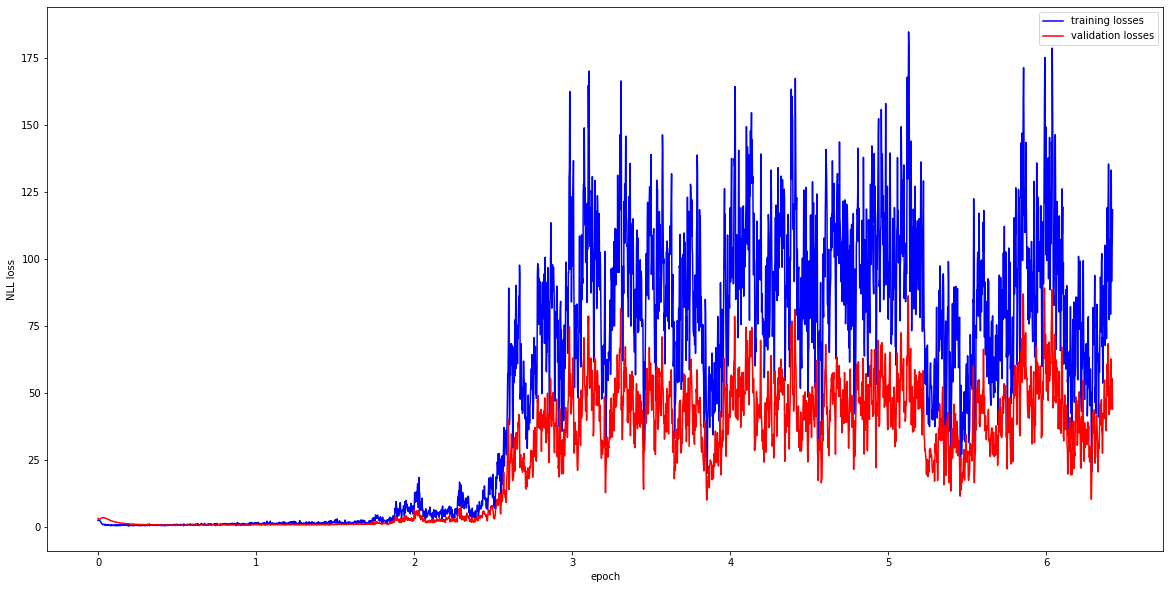

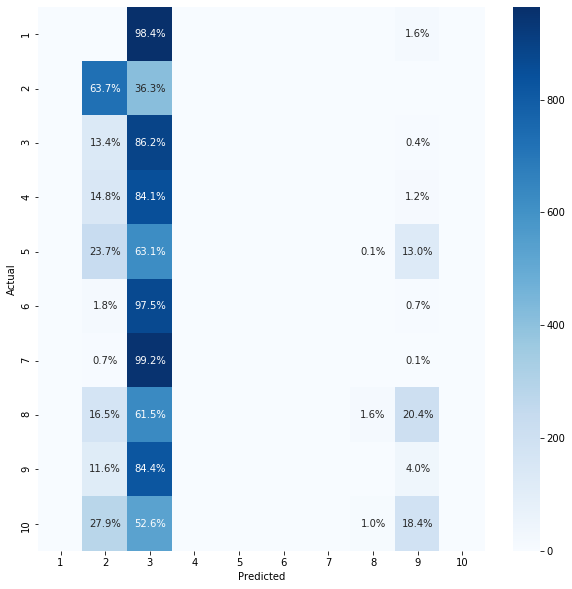

epoch  8 :  0 / 60000  (0 %)  | train loss:96.0804 | val loss:60.5242 | val acc:0.1130 | Time:5.0266
epoch  8 :  128 / 60000  (0 %)  | train loss:101.6477 | val loss:50.2849 | val acc:0.1132 | Time:9.5564
epoch  8 :  256 / 60000  (0 %)  | train loss:89.3796 | val loss:41.8446 | val acc:0.0926 | Time:13.7132
epoch  8 :  384 / 60000  (1 %)  | train loss:83.0447 | val loss:42.3516 | val acc:0.0930 | Time:18.0566
epoch  8 :  512 / 60000  (1 %)  | train loss:75.5563 | val loss:39.1218 | val acc:0.0886 | Time:22.4670
epoch  8 :  640 / 60000  (1 %)  | train loss:73.0869 | val loss:37.3618 | val acc:0.1278 | Time:26.9224
epoch  8 :  768 / 60000  (1 %)  | train loss:71.1325 | val loss:47.1749 | val acc:0.1158 | Time:31.2797
epoch  8 :  896 / 60000  (1 %)  | train loss:92.9504 | val loss:51.1983 | val acc:0.1138 | Time:36.4116
epoch  8 :  1024 / 60000  (2 %)  | train loss:106.1414 | val loss:42.8753 | val acc:0.1010 | Time:41.2180
epoch  8 :  1152 / 60000  (2 %)  | train loss:79.9891 | val loss:

epoch  8 :  9984 / 60000  (17 %)  | train loss:105.1539 | val loss:60.2054 | val acc:0.1180 | Time:339.0488
epoch  8 :  10112 / 60000  (17 %)  | train loss:123.4715 | val loss:45.4524 | val acc:0.1288 | Time:342.9024
epoch  8 :  10240 / 60000  (17 %)  | train loss:92.0351 | val loss:37.2148 | val acc:0.1448 | Time:346.7390
epoch  8 :  10368 / 60000  (17 %)  | train loss:68.6296 | val loss:32.7782 | val acc:0.1184 | Time:350.6874
epoch  8 :  10496 / 60000  (17 %)  | train loss:54.3884 | val loss:35.6812 | val acc:0.1196 | Time:355.1684
epoch  8 :  10624 / 60000  (18 %)  | train loss:77.1676 | val loss:39.6743 | val acc:0.1094 | Time:359.4955
epoch  8 :  10752 / 60000  (18 %)  | train loss:69.2145 | val loss:53.8978 | val acc:0.1026 | Time:363.6786
epoch  8 :  10880 / 60000  (18 %)  | train loss:102.6869 | val loss:52.9640 | val acc:0.1062 | Time:367.8337
epoch  8 :  11008 / 60000  (18 %)  | train loss:101.7466 | val loss:48.2126 | val acc:0.1110 | Time:372.1245
epoch  8 :  11136 / 60000

epoch  8 :  19712 / 60000  (33 %)  | train loss:98.8310 | val loss:55.5524 | val acc:0.1022 | Time:656.2319
epoch  8 :  19840 / 60000  (33 %)  | train loss:116.7930 | val loss:61.8529 | val acc:0.1042 | Time:660.7795
epoch  8 :  19968 / 60000  (33 %)  | train loss:129.7588 | val loss:79.1997 | val acc:0.0976 | Time:665.6686
epoch  8 :  20096 / 60000  (33 %)  | train loss:150.2710 | val loss:65.5765 | val acc:0.0980 | Time:670.3426
epoch  8 :  20224 / 60000  (34 %)  | train loss:125.4726 | val loss:36.3833 | val acc:0.1042 | Time:675.1238
epoch  8 :  20352 / 60000  (34 %)  | train loss:71.0040 | val loss:44.0158 | val acc:0.1034 | Time:679.7575
epoch  8 :  20480 / 60000  (34 %)  | train loss:75.5118 | val loss:51.7000 | val acc:0.1130 | Time:684.0208
epoch  8 :  20608 / 60000  (34 %)  | train loss:84.4492 | val loss:44.7699 | val acc:0.1210 | Time:688.1530
epoch  8 :  20736 / 60000  (35 %)  | train loss:96.2853 | val loss:53.0744 | val acc:0.1176 | Time:692.7028
epoch  8 :  20864 / 6000

epoch  8 :  29440 / 60000  (49 %)  | train loss:164.3443 | val loss:73.9496 | val acc:0.0896 | Time:997.5834
epoch  8 :  29568 / 60000  (49 %)  | train loss:143.0885 | val loss:68.3076 | val acc:0.1122 | Time:1002.4959
epoch  8 :  29696 / 60000  (49 %)  | train loss:143.3589 | val loss:56.3579 | val acc:0.1348 | Time:1007.1928
epoch  8 :  29824 / 60000  (50 %)  | train loss:105.9500 | val loss:52.0425 | val acc:0.1170 | Time:1011.5255
epoch  8 :  29952 / 60000  (50 %)  | train loss:99.4051 | val loss:55.6878 | val acc:0.1156 | Time:1015.7751
epoch  8 :  30080 / 60000  (50 %)  | train loss:109.5845 | val loss:42.4269 | val acc:0.1254 | Time:1020.1423
epoch  8 :  30208 / 60000  (50 %)  | train loss:79.7374 | val loss:51.3189 | val acc:0.1210 | Time:1024.3807
epoch  8 :  30336 / 60000  (51 %)  | train loss:106.4726 | val loss:60.4065 | val acc:0.1198 | Time:1028.6220
epoch  8 :  30464 / 60000  (51 %)  | train loss:113.0551 | val loss:62.1601 | val acc:0.1574 | Time:1032.8565
epoch  8 :  3

epoch  8 :  39040 / 60000  (65 %)  | train loss:144.5236 | val loss:49.3729 | val acc:0.1074 | Time:1337.3849
epoch  8 :  39168 / 60000  (65 %)  | train loss:95.2405 | val loss:42.5834 | val acc:0.1032 | Time:1341.5820
epoch  8 :  39296 / 60000  (65 %)  | train loss:83.7243 | val loss:38.6171 | val acc:0.1056 | Time:1346.0285
epoch  8 :  39424 / 60000  (66 %)  | train loss:75.1975 | val loss:43.1435 | val acc:0.1246 | Time:1350.7536
epoch  8 :  39552 / 60000  (66 %)  | train loss:66.5528 | val loss:58.5822 | val acc:0.1294 | Time:1355.3641
epoch  8 :  39680 / 60000  (66 %)  | train loss:118.0800 | val loss:74.1143 | val acc:0.1240 | Time:1360.4928
epoch  8 :  39808 / 60000  (66 %)  | train loss:138.1679 | val loss:59.4869 | val acc:0.1050 | Time:1365.4352
epoch  8 :  39936 / 60000  (67 %)  | train loss:111.0376 | val loss:60.1600 | val acc:0.1158 | Time:1370.1535
epoch  8 :  40064 / 60000  (67 %)  | train loss:114.2526 | val loss:51.3521 | val acc:0.1260 | Time:1375.0222
epoch  8 :  40

epoch  8 :  48640 / 60000  (81 %)  | train loss:97.1934 | val loss:44.1473 | val acc:0.1270 | Time:1698.2484
epoch  8 :  48768 / 60000  (81 %)  | train loss:87.2194 | val loss:43.9315 | val acc:0.1040 | Time:1703.0413
epoch  8 :  48896 / 60000  (81 %)  | train loss:69.1578 | val loss:49.5516 | val acc:0.0920 | Time:1707.6906
epoch  8 :  49024 / 60000  (82 %)  | train loss:78.1603 | val loss:39.8419 | val acc:0.1076 | Time:1712.2846
epoch  8 :  49152 / 60000  (82 %)  | train loss:72.6125 | val loss:54.5497 | val acc:0.0874 | Time:1716.9016
epoch  8 :  49280 / 60000  (82 %)  | train loss:89.6256 | val loss:66.8274 | val acc:0.1028 | Time:1721.8742
epoch  8 :  49408 / 60000  (82 %)  | train loss:122.9143 | val loss:70.1045 | val acc:0.1162 | Time:1726.7785
epoch  8 :  49536 / 60000  (83 %)  | train loss:119.9032 | val loss:55.8915 | val acc:0.1550 | Time:1731.5072
epoch  8 :  49664 / 60000  (83 %)  | train loss:100.0785 | val loss:51.8041 | val acc:0.1278 | Time:1736.1829
epoch  8 :  4979

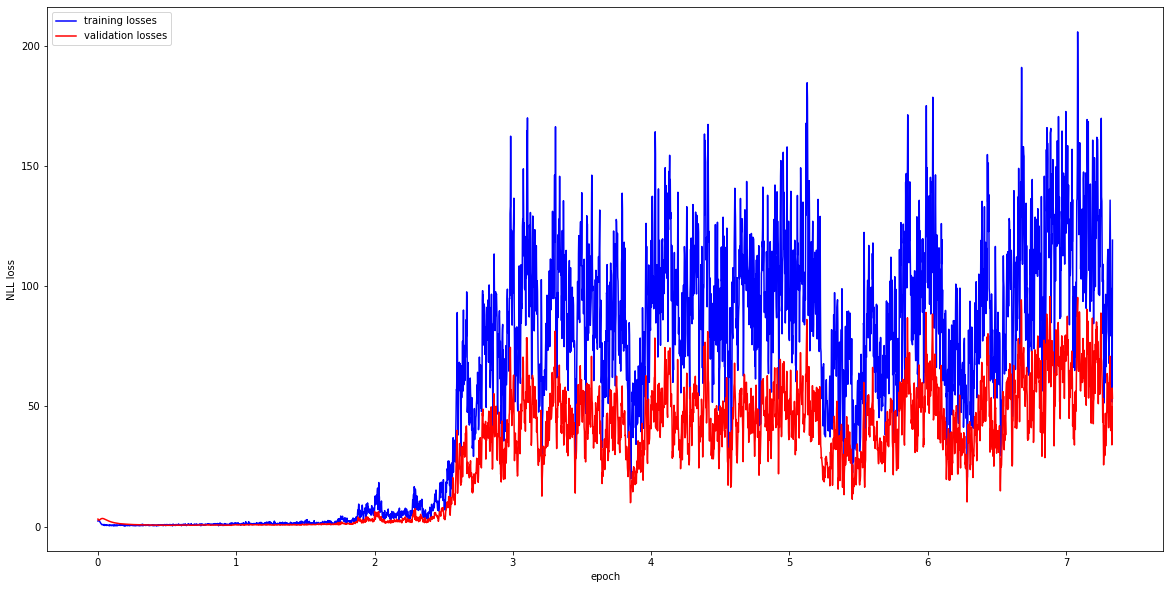

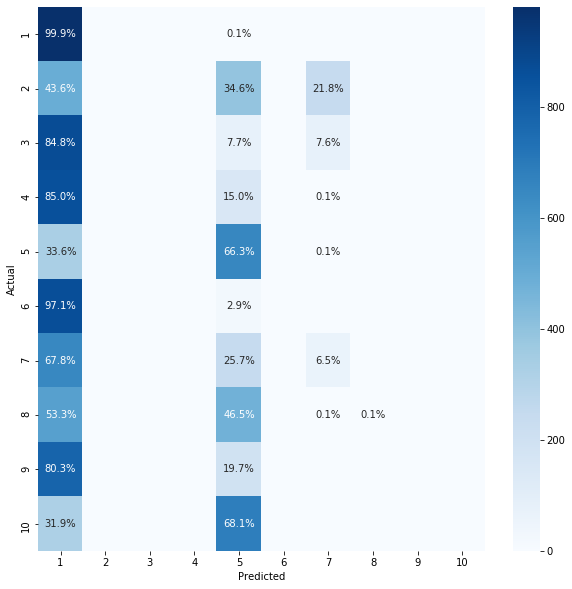

epoch  9 :  0 / 60000  (0 %)  | train loss:152.6909 | val loss:106.8238 | val acc:0.1074 | Time:4.5166
epoch  9 :  128 / 60000  (0 %)  | train loss:186.0335 | val loss:99.8920 | val acc:0.1070 | Time:9.0700
epoch  9 :  256 / 60000  (0 %)  | train loss:196.3920 | val loss:83.9821 | val acc:0.1100 | Time:13.4324
epoch  9 :  384 / 60000  (1 %)  | train loss:150.1758 | val loss:76.2489 | val acc:0.1100 | Time:17.7118
epoch  9 :  512 / 60000  (1 %)  | train loss:147.2697 | val loss:69.9843 | val acc:0.0914 | Time:22.0198
epoch  9 :  640 / 60000  (1 %)  | train loss:132.0314 | val loss:46.3348 | val acc:0.1174 | Time:26.2154
epoch  9 :  768 / 60000  (1 %)  | train loss:88.1617 | val loss:66.2814 | val acc:0.1058 | Time:31.0667
epoch  9 :  896 / 60000  (1 %)  | train loss:116.2326 | val loss:73.6994 | val acc:0.1184 | Time:35.3929
epoch  9 :  1024 / 60000  (2 %)  | train loss:133.2081 | val loss:77.9329 | val acc:0.1084 | Time:39.6043
epoch  9 :  1152 / 60000  (2 %)  | train loss:141.4965 | v

epoch  9 :  9856 / 60000  (16 %)  | train loss:67.7796 | val loss:43.1444 | val acc:0.1212 | Time:343.6559
epoch  9 :  9984 / 60000  (17 %)  | train loss:82.1494 | val loss:45.8996 | val acc:0.1204 | Time:348.2486
epoch  9 :  10112 / 60000  (17 %)  | train loss:92.5582 | val loss:24.9961 | val acc:0.1220 | Time:352.6433
epoch  9 :  10240 / 60000  (17 %)  | train loss:37.9173 | val loss:30.7163 | val acc:0.1054 | Time:357.3915
epoch  9 :  10368 / 60000  (17 %)  | train loss:57.1797 | val loss:40.7329 | val acc:0.1324 | Time:362.1341
epoch  9 :  10496 / 60000  (17 %)  | train loss:82.2527 | val loss:48.1016 | val acc:0.1208 | Time:366.5305
epoch  9 :  10624 / 60000  (18 %)  | train loss:88.1960 | val loss:55.3252 | val acc:0.0940 | Time:370.9593
epoch  9 :  10752 / 60000  (18 %)  | train loss:105.0667 | val loss:56.6137 | val acc:0.1118 | Time:375.3880
epoch  9 :  10880 / 60000  (18 %)  | train loss:96.4583 | val loss:48.4513 | val acc:0.1300 | Time:379.8352
epoch  9 :  11008 / 60000  (1

epoch  9 :  19584 / 60000  (33 %)  | train loss:102.2478 | val loss:60.3457 | val acc:0.1262 | Time:703.1715
epoch  9 :  19712 / 60000  (33 %)  | train loss:116.6309 | val loss:67.1352 | val acc:0.1182 | Time:707.6585
epoch  9 :  19840 / 60000  (33 %)  | train loss:135.9476 | val loss:61.6251 | val acc:0.1188 | Time:712.1158
epoch  9 :  19968 / 60000  (33 %)  | train loss:107.8636 | val loss:69.1421 | val acc:0.1014 | Time:716.7173
epoch  9 :  20096 / 60000  (33 %)  | train loss:129.5220 | val loss:80.7054 | val acc:0.0926 | Time:721.8937
epoch  9 :  20224 / 60000  (34 %)  | train loss:143.4745 | val loss:67.4691 | val acc:0.1294 | Time:726.7494
epoch  9 :  20352 / 60000  (34 %)  | train loss:145.8121 | val loss:68.6489 | val acc:0.1152 | Time:731.5257
epoch  9 :  20480 / 60000  (34 %)  | train loss:126.1632 | val loss:56.2881 | val acc:0.1382 | Time:736.0780
epoch  9 :  20608 / 60000  (34 %)  | train loss:104.1897 | val loss:40.7144 | val acc:0.1192 | Time:740.6660
epoch  9 :  20736 /

epoch  9 :  29312 / 60000  (49 %)  | train loss:123.8690 | val loss:62.0947 | val acc:0.1122 | Time:1084.4301
epoch  9 :  29440 / 60000  (49 %)  | train loss:115.4581 | val loss:70.7184 | val acc:0.1104 | Time:1089.3790
epoch  9 :  29568 / 60000  (49 %)  | train loss:168.3407 | val loss:55.2607 | val acc:0.1242 | Time:1094.2113
epoch  9 :  29696 / 60000  (49 %)  | train loss:95.8664 | val loss:63.2459 | val acc:0.1112 | Time:1099.0010
epoch  9 :  29824 / 60000  (50 %)  | train loss:102.1956 | val loss:68.6186 | val acc:0.0956 | Time:1103.7323
epoch  9 :  29952 / 60000  (50 %)  | train loss:147.7633 | val loss:63.2528 | val acc:0.1032 | Time:1108.2700
epoch  9 :  30080 / 60000  (50 %)  | train loss:114.0187 | val loss:68.6572 | val acc:0.1012 | Time:1113.3007
epoch  9 :  30208 / 60000  (50 %)  | train loss:136.3876 | val loss:55.0124 | val acc:0.1034 | Time:1118.4102
epoch  9 :  30336 / 60000  (51 %)  | train loss:97.8640 | val loss:55.4068 | val acc:0.1314 | Time:1123.1797
epoch  9 :  

epoch  9 :  38912 / 60000  (65 %)  | train loss:120.4148 | val loss:67.8149 | val acc:0.0902 | Time:1461.6888
epoch  9 :  39040 / 60000  (65 %)  | train loss:125.2412 | val loss:49.6291 | val acc:0.1320 | Time:1466.1941
epoch  9 :  39168 / 60000  (65 %)  | train loss:96.6888 | val loss:51.5415 | val acc:0.1246 | Time:1471.1890
epoch  9 :  39296 / 60000  (65 %)  | train loss:85.6341 | val loss:62.4713 | val acc:0.1230 | Time:1475.9478
epoch  9 :  39424 / 60000  (66 %)  | train loss:127.0412 | val loss:75.6137 | val acc:0.0962 | Time:1480.7595
epoch  9 :  39552 / 60000  (66 %)  | train loss:148.2781 | val loss:97.1812 | val acc:0.0944 | Time:1485.7440
epoch  9 :  39680 / 60000  (66 %)  | train loss:162.3066 | val loss:86.8640 | val acc:0.1028 | Time:1490.2995
epoch  9 :  39808 / 60000  (66 %)  | train loss:145.1205 | val loss:93.0609 | val acc:0.0970 | Time:1494.8503
epoch  9 :  39936 / 60000  (67 %)  | train loss:166.6781 | val loss:110.9366 | val acc:0.1006 | Time:1499.4414
epoch  9 : 

epoch  9 :  48512 / 60000  (81 %)  | train loss:87.8863 | val loss:57.3106 | val acc:0.1170 | Time:1815.4357
epoch  9 :  48640 / 60000  (81 %)  | train loss:107.8082 | val loss:38.7320 | val acc:0.1230 | Time:1820.1912
epoch  9 :  48768 / 60000  (81 %)  | train loss:75.0119 | val loss:37.6978 | val acc:0.1244 | Time:1824.9324
epoch  9 :  48896 / 60000  (81 %)  | train loss:69.0298 | val loss:54.3325 | val acc:0.1286 | Time:1829.7438
epoch  9 :  49024 / 60000  (82 %)  | train loss:110.0382 | val loss:63.8794 | val acc:0.1116 | Time:1834.5462
epoch  9 :  49152 / 60000  (82 %)  | train loss:118.7179 | val loss:71.4215 | val acc:0.1080 | Time:1839.0975
epoch  9 :  49280 / 60000  (82 %)  | train loss:120.0721 | val loss:59.0012 | val acc:0.1298 | Time:1843.6884
epoch  9 :  49408 / 60000  (82 %)  | train loss:113.0328 | val loss:71.3742 | val acc:0.1100 | Time:1848.2679
epoch  9 :  49536 / 60000  (83 %)  | train loss:133.0212 | val loss:70.6455 | val acc:0.1346 | Time:1852.8877
epoch  9 :  4

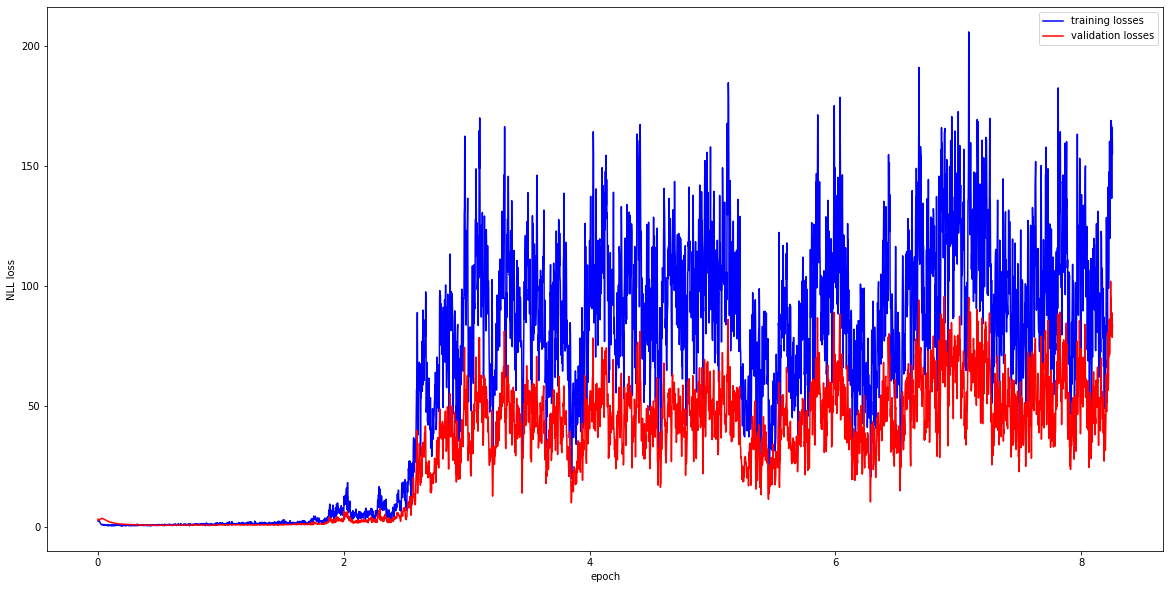

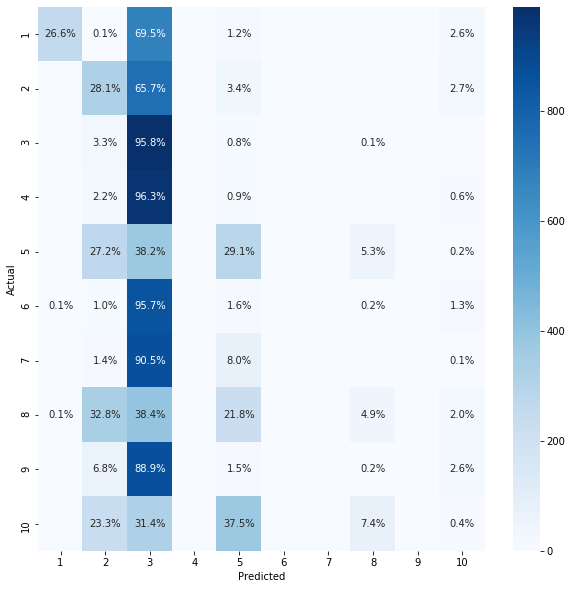

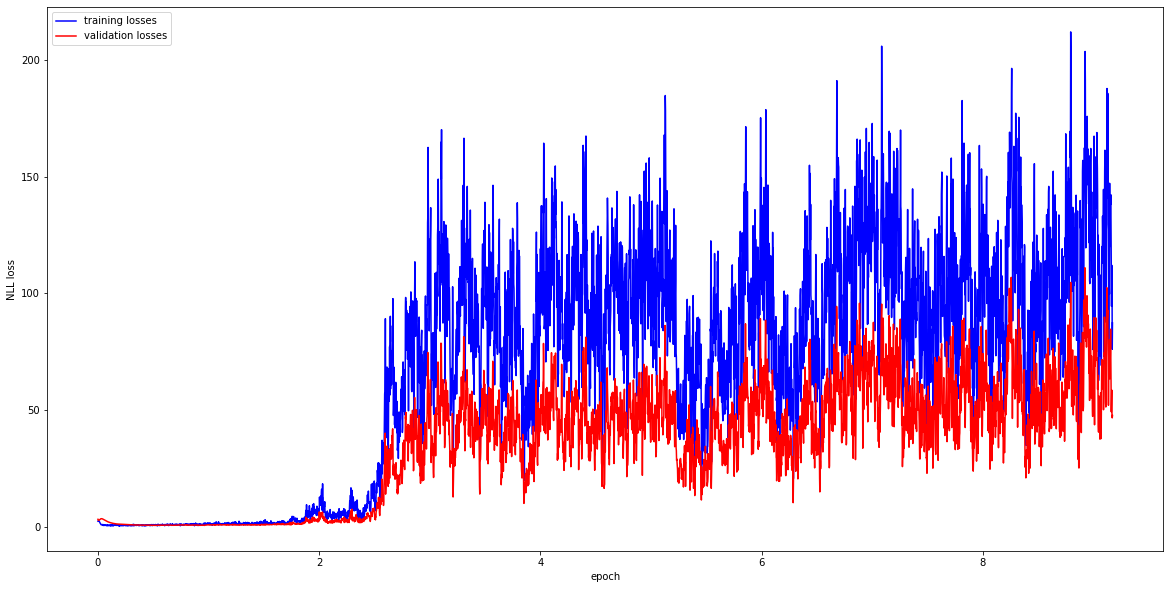

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 5
n_down = 7
p_down = 0.01

name = 'rnnrn-uam'
model = RNNRN_UAM()
model.to(device)
# rnn.cuda()
isImbalanced = False
getMDL = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 10
train_losses = []
val_losses = []
test_acces = []
l_list = []

# training and testing
for epoch in range(EPOCH):
    if epoch == 0:
        x_history_stack=None
        COMP_stack=None
        
    train_losses, val_losses, x_history_stack, COMP_stack, used_train_size, l = train_RN(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses,x_history_stack,COMP_stack,isImbalanced=isImbalanced,getMDL=getMDL)
    test_acces, x_history_stack_test, COMP_stack_test, confusion_mtx, _ = test_RN(model, device, test_loader, test_acces,x_history_stack,COMP_stack,getMDL=getMDL)
    for bl in l:
         l_list.append(bl)
            
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')


    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])
    
np.save('models/'+name+'_mdl.npy',np.array(l_list))
l_rnnrn_list = l_list

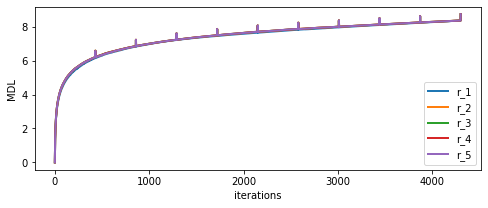

In [18]:
l_list = np.load('models/rnnrn-uam_mdl.npy',allow_pickle=True)

T = np.arange(l_list.shape[0]) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

for t in np.arange(1,l_list.shape[1]):
    ax.plot(T,l_list[:,t],label='r_'+str(t),linewidth=lw)

ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()

fig.savefig('./figures/l_rnnrn.png',layout='tight')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 1
n_down = 1
p_down = 0.01

name = 'imb_nn_uam_'+str(n_down)+'_'+str(p_down)'
model = NN_UAM()
model.to(device)
# rnn.cuda()

isImbalanced = True
getMDL = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 1
train_losses = []
val_losses = []
test_acces = []
l_list = []

# training and testing
for epoch in range(EPOCH):
    if epoch == 0:
        x_history_stack=None
        COMP_stack=None
        
    train_losses, val_losses, x_history_stack, COMP_stack, used_train_size, l = train_RN(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses,x_history_stack,COMP_stack,isImbalanced=isImbalanced,getMDL=getMDL)
    test_acces, x_history_stack_test, COMP_stack_test, confusion_mtx, _ = test_RN(model, device, test_loader, test_acces,x_history_stack,COMP_stack,getMDL=getMDL)
    for bl in l:
         l_list.append(bl)
    
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')


    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])

np.save('models/'+name+'_mdl.npy',np.array(l_list))
 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 1
n_down = 1
p_down = 0.01

name = 'imb_nnrn_uam_'+str(n_down)+'_'+str(p_down)'
model = NNRN_UAM()
model.to(device)
# rnn.cuda()

isImbalanced = True
getMDL = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 1
train_losses = []
val_losses = []
test_acces = []
l_list = []

# training and testing
for epoch in range(EPOCH):
    if epoch == 0:
        x_history_stack=None
        COMP_stack=None
        
    train_losses, val_losses, x_history_stack, COMP_stack, used_train_size, l = train_RN(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses,x_history_stack,COMP_stack,isImbalanced=isImbalanced,getMDL=getMDL)
    test_acces, x_history_stack_test, COMP_stack_test, confusion_mtx, _ = test_RN(model, device, test_loader, test_acces,x_history_stack,COMP_stack,getMDL=getMDL)
    for bl in l:
         l_list.append(bl)
    
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')


    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])

np.save('models/'+name+'_mdl.npy',np.array(l_list))


In [ ]:
l_list = np.load('models/imb_nn_uam_1_0.01_mdl.npy',allow_pickle=True)
# l_list = np.array(l_list)
T = np.arange(l_list.shape[0]-1) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

ax.plot(T,l_list[:-1,1],label='NN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN fc_2',linewidth=lw)

l_list = np.load('models/imb_nnrn_uam_1_0.01_mdl.npy',allow_pickle=True)

ax.plot(T,l_list[:-1,1],label='NN+RN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN+RN fc_2',linewidth=lw)


ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()
ax.set_title('imbalanced n = 1')

fig.savefig('./figures/l_imb_1.png',layout='tight')

In [ ]:
l_list = np.load('models/imb_nn_uam_2_0.01_mdl.npy',allow_pickle=True)
# l_list = np.array(l_list)
T = np.arange(l_list.shape[0]-1) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

ax.plot(T,l_list[:-1,1],label='NN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN fc_2',linewidth=lw)

l_list = np.load('models/imb_nnrn_uam_2_0.01_mdl.npy',allow_pickle=True)

ax.plot(T,l_list[:-1,1],label='NN+RN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN+RN fc_2',linewidth=lw)


ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()
ax.set_title('imbalanced n = 2')

fig.savefig('./figures/l_imb_2.png',layout='tight')

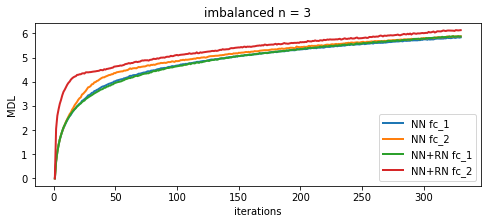

In [29]:
l_list = np.load('models/imb_nn_uam_3_0.01_mdl.npy',allow_pickle=True)
# l_list = np.array(l_list)
T = np.arange(l_list.shape[0]-1) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

ax.plot(T,l_list[:-1,1],label='NN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN fc_2',linewidth=lw)

l_list = np.load('models/imb_nnrn_uam_3_0.01_mdl.npy',allow_pickle=True)

ax.plot(T,l_list[:-1,1],label='NN+RN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN+RN fc_2',linewidth=lw)


ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()
ax.set_title('imbalanced n = 3')

fig.savefig('./figures/l_imb_3.png',layout='tight')

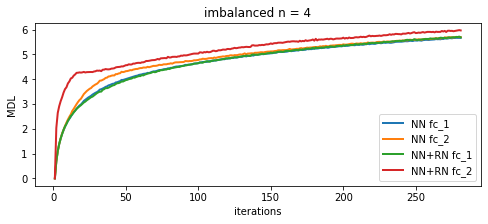

In [28]:
l_list = np.load('models/imb_nn_uam_4_0.01_mdl.npy',allow_pickle=True)
# l_list = np.array(l_list)
T = np.arange(l_list.shape[0]-1) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

ax.plot(T,l_list[:-1,1],label='NN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN fc_2',linewidth=lw)

l_list = np.load('models/imb_nnrn_uam_4_0.01_mdl.npy',allow_pickle=True)

ax.plot(T,l_list[:-1,1],label='NN+RN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN+RN fc_2',linewidth=lw)


ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()
ax.set_title('imbalanced n = 4')

fig.savefig('./figures/l_imb_4.png',layout='tight')

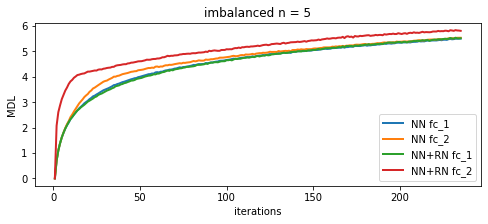

In [27]:
l_list = np.load('models/imb_nn_uam_5_0.01_mdl.npy',allow_pickle=True)
# l_list = np.array(l_list)
T = np.arange(l_list.shape[0]-1) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

ax.plot(T,l_list[:-1,1],label='NN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN fc_2',linewidth=lw)

l_list = np.load('models/imb_nnrn_uam_5_0.01_mdl.npy',allow_pickle=True)

ax.plot(T,l_list[:-1,1],label='NN+RN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN+RN fc_2',linewidth=lw)


ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()
ax.set_title('imbalanced n = 5')

fig.savefig('./figures/l_imb_5.png',layout='tight')

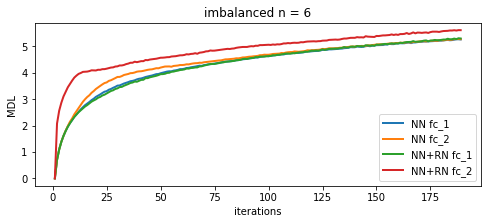

In [24]:
l_list = np.load('models/imb_nn_uam_6_0.01_mdl.npy',allow_pickle=True)
# l_list = np.array(l_list)
T = np.arange(l_list.shape[0]-1) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

ax.plot(T,l_list[:-1,1],label='NN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN fc_2',linewidth=lw)

l_list = np.load('models/imb_nnrn_uam_6_0.01_mdl.npy',allow_pickle=True)

ax.plot(T,l_list[:-1,1],label='NN+RN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN+RN fc_2',linewidth=lw)


ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()
ax.set_title('imbalanced n = 6')

fig.savefig('./figures/l_imb_6.png',layout='tight')

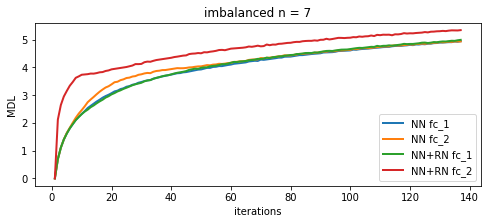

In [23]:
l_list = np.load('models/imb_nn_uam_7_0.01_mdl.npy',allow_pickle=True)
# l_list = np.array(l_list)
T = np.arange(l_list.shape[0]-1) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

ax.plot(T,l_list[:-1,1],label='NN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN fc_2',linewidth=lw)

l_list = np.load('models/imb_nnrn_uam_7_0.01_mdl.npy',allow_pickle=True)

ax.plot(T,l_list[:-1,1],label='NN+RN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN+RN fc_2',linewidth=lw)


ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()
ax.set_title('imbalanced n = 7')

fig.savefig('./figures/l_imb_7.png',layout='tight')

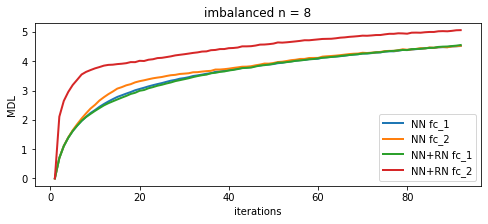

In [22]:
l_list = np.load('models/imb_nn_uam_8_0.01_mdl.npy',allow_pickle=True)
# l_list = np.array(l_list)
T = np.arange(l_list.shape[0]-1) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

ax.plot(T,l_list[:-1,1],label='NN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN fc_2',linewidth=lw)

l_list = np.load('models/imb_nnrn_uam_8_0.01_mdl.npy',allow_pickle=True)

ax.plot(T,l_list[:-1,1],label='NN+RN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN+RN fc_2',linewidth=lw)

ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()
ax.set_title('imbalanced n = 8')

fig.savefig('./figures/l_imb_8.png',layout='tight')

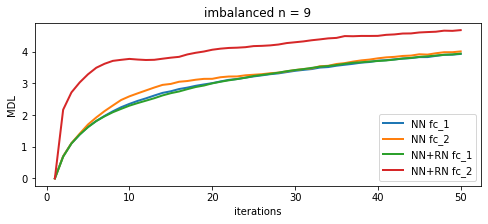

In [20]:
l_list = np.load('models/imb_nn_uam_9_0.01_mdl.npy',allow_pickle=True)
# l_list = np.array(l_list)
T = np.arange(l_list.shape[0]-1) + 1
lw = 2

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot()

ax.plot(T,l_list[:-1,1],label='NN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN fc_2',linewidth=lw)

l_list = np.load('models/imb_nnrn_uam_9_0.01_mdl.npy',allow_pickle=True)

ax.plot(T,l_list[:-1,1],label='NN+RN fc_1',linewidth=lw)
ax.plot(T,l_list[:-1,2],label='NN+RN fc_2',linewidth=lw)


ax.set_ylabel('MDL')
ax.set_xlabel('iterations')
ax.legend()
ax.set_title('imbalanced n = 9')

fig.savefig('./figures/l_imb_9.png',layout='tight')